# Object detection algorithm for Isaac Sim environment
#### The algorithm works for a scene containing a jetbot and a simple sphere object.

Declare a configuration for the simulation application:<br>
Properties:<br>
PathTracing renderer <br>
Headless True - thanks to this approach there is no need to open a kitremote instance of Isaac Sim and being connected. <br>
Width and height: 1280x720 - fixed <br>
Link: https://docs.omniverse.nvidia.com/py/isaacsim/source/extensions/omni.isaac.kit/docs/index.html?highlight=usdcontext

In [1]:
import getpass
user = getpass.getuser()
from omni.isaac.kit import SimulationApp
# Set the path below to your desired nucleus server
CONFIG = {"renderer":"PathTracing", "headless":True, "width":1280, "height":720, "sync_loads": True}
kit = simulation_app = SimulationApp(launch_config=CONFIG)

Passing the following args to the base kit application:  ['-f', '/home/student/.local/share/jupyter/runtime/kernel-64cea0a4-ae6a-4689-b508-fa7dbbbdd39f.json']
[Warning] [omni.kit.app.plugin] No crash reporter present, dumps uploading isn't available.
[Info] [carb] Logging to file: /home/student/.local/share/ov/pkg/isaac_sim-2021.2.1/kit/logs/Kit/Isaac-Sim/2021.2/kit_20220510_103927.log
2022-05-10 08:39:27 s] [Warning] [omni.ext.plugin] [ext: omni.jetbot.opencv] Extensions config 'extension.toml' doesn't exist anywhere in '/home/student/.local/share/ov/pkg/isaac_sim-2021.2.1/exts/omni.jetbot.opencv/**'
[0.043s] [ext: omni.kit.pipapi-0.0.0] startup
[0.052s] [ext: omni.kit.pip_archive-0.0.0] startup
[0.056s] [ext: omni.isaac.pip_archive-0.1.0] startup
[0.210s] [ext: omni.usd.config-1.0.0] startup
[0.212s] [ext: omni.usd.libs-1.0.0] startup
[0.353s] [ext: omni.stats-0.0.0] startup
[0.355s] [ext: omni.gpu_foundation-0.0.0] startup
[0.360s] [ext: omni.kit.async_engine-0.0.0] startup
[0.361s]

2022-05-10 08:39:27 s] [Error] [carb.windowing-glfw.plugin] GLFW initialization failed.
2022-05-10 08:39:27 s] [Error] [carb] Failed to startup plugin carb.windowing-glfw.plugin (interfaces: [carb::windowing::IGLContext v1.0],[carb::windowing::IWindowing v1.2]) (impl: carb.windowing-glfw.plugin)
2022-05-10 08:39:28 s] [Error] [carb.windowing-glfw.plugin] GLFW initialization failed.
2022-05-10 08:39:28 s] [Error] [carb] Failed to startup plugin carb.windowing-glfw.plugin (interfaces: [carb::windowing::IGLContext v1.0],[carb::windowing::IWindowing v1.2]) (impl: carb.windowing-glfw.plugin)
2022-05-10 08:39:28 s] [Error] [carb.windowing-glfw.plugin] GLFW initialization failed.
2022-05-10 08:39:28 s] [Error] [carb] Failed to startup plugin carb.windowing-glfw.plugin (interfaces: [carb::windowing::IGLContext v1.0],[carb::windowing::IWindowing v1.2]) (impl: carb.windowing-glfw.plugin)
2022-05-10 08:39:28 s] [Error] [carb.windowing-glfw.plugin] GLFW initialization failed.
2022-05-10 08:39:28 s

[0.366s] [ext: omni.client-0.1.0] startup
[0.372s] [ext: omni.kit.renderer.core-0.0.0] startup

|---------------------------------------------------------------------------------------------|
| Driver Version: 470.103     | Graphics API: Vulkan
|=============================================================================================|
| GPU | Name                             | Active | LDA | GPU Memory | Vendor-ID | LUID       |
|     |                                  |        |     |            | Device-ID | UUID       |
|---------------------------------------------------------------------------------------------|
| 0   | NVIDIA GeForce RTX 3070          | Yes: 0 |     | 8438    MB | 10de      | 0          |
|     |                                  |        |     |            | 2488      | 68a19bb3.. |
|=============================================================================================|
| OS: Linux colima, Version: 5.4.0-105-generic
| Processor: 11th Gen Intel(R) Core(

Omni isaac.core libraries should be declared after the simulation app has be initialized

In [2]:
import carb
import omni.ext
import omni.appwindow
import gc
import numpy as np
from omni.isaac.core.utils.viewports import set_camera_view
from omni.isaac.core.utils.nucleus import find_nucleus_server

Declare a viewport handler and a SynteticDataHelper to obtain the rgb image

In [3]:
from omni.isaac.synthetic_utils import SyntheticDataHelper
viewport = omni.kit.viewport.get_viewport_interface()
sd_helper = SyntheticDataHelper()

Get the stage of the simulation

In [4]:
stage = simulation_app.context.get_stage()

Find an active nucleus server and load the scenario of the simulation. After that open the stage following the path

In [5]:
result, nucleus_server = find_nucleus_server()
if result is False:
    print("Could not find nucleus server")
if result:
    #Load the scenario to test the algorithm on
    scenario_path = "omniverse://localhost/Projects/trabelsi/second_sphere_only_testing.usd"
    stage= omni.usd.get_context().open_stage(scenario_path)
#Wait two frames so that the stage starts to load
kit.update()
kit.update()

In [6]:
from omni.isaac.core.utils.stage import is_stage_loading
while is_stage_loading():
    kit.update()
print("Loading complete")

Loading complete


Play the scene.<br>
The simulation has to run before there is any call made to the dynamic control

In [7]:
import omni
omni.timeline.get_timeline_interface().play()

simulation_app.update()

Create an articulation object using the dynamic_control library. This approach allows to access the joints of the robot and apply velocity change. 

In [8]:
import matplotlib.pyplot as plt
import cv2
from omni.isaac.dynamic_control import _dynamic_control
dc = _dynamic_control.acquire_dynamic_control_interface()
from IPython.display import clear_output

#Define the path of the object to control
ARTICULATION_PATH = "/World/jetbot"

articulation = dc.get_articulation(ARTICULATION_PATH)
if articulation == _dynamic_control.INVALID_HANDLE:
    print(str(ARTICULATION_PATH) + " is not an articulation" )
else:
    print("Found articulation for path: " + str(ARTICULATION_PATH) )
    root = dc.get_articulation_root_body(articulation)
    print(str("Articulation handle %d \n" % articulation) + str("--- Hierarchy\n"))
    
    body_states = dc.get_articulation_body_states(articulation, _dynamic_control.STATE_ALL)
    print(str("--- Body states:\n") + str(body_states) + "\n")
    
    dof_states = dc.get_articulation_dof_states(articulation, _dynamic_control.STATE_ALL)
    print(str("--- DOF states:\n") + str(dof_states) + "\n")
    
    dof_props = dc.get_articulation_dof_properties(articulation)
    print(str("--- DOF properties:\n") + str(dof_props) + "\n")
    
    dc.wake_up_articulation(articulation)
    right_joint = dc.find_articulation_dof(articulation, "right_wheel_joint")
    left_joint = dc.find_articulation_dof(articulation, "left_wheel_joint")


Found articulation for path: /World/jetbot
Articulation handle 2216203124737 
--- Hierarchy

--- Body states:
[(((-1016.0956 , -1050.1306, 3.371566), ( 1.9905739e-05, -0.00403182,  0.00387518, 0.99998444)), (( 0.03972899, 0.03615671, -0.0273291 ), (0.00945804,  0.00689274, 0.00438977)))
 (((-1016.1318 , -1045.4608, 3.371607), (-2.2804402e-03, -0.00230425,  0.70983803, 0.7043576 )), ((-0.00488662, 0.06920913,  0.01688258), (0.00942847,  0.01070788, 0.00438981)))
 (((-1016.05945, -1054.8007, 3.371528), ( 2.5894472e-03, -0.00256343, -0.70435697, 0.7098367 )), (( 0.04609402, 0.0695859 , -0.09350771), (0.00954126, -0.00385428, 0.00439933)))]

--- DOF states:
[(0.00157993,  0.00381525, 2.1210960e-06)
 (0.00077639, -0.01074735, 2.1908886e-06)]

--- DOF properties:
[(1, False, 0., 0.e+00, 0, 12.56, 3.4028235e+38, 0., 10000.)
 (1, False, 0., 4.e-45, 0, 12.56, 3.4028235e+38, 0., 10000.)]



The actual object detection algorithm. <br>
It defines the viewport and sets the camera from which the image will be read. <br>
While the simulation is running the image is achieved from the viewport using the SyntheticDataHelper. <br>
In the next phase the image is passed to the DNN and the detection is generated on the output. Basing on the confidence percentage a box with the label is drawn on the image. <br>
If the detected object is on the right side of the image, then the jetbot will turn right. Otherwise it will turn left. Finally the image is displayed on the output. <br>
At the end the simulation is stopped and the app is closed.

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 816


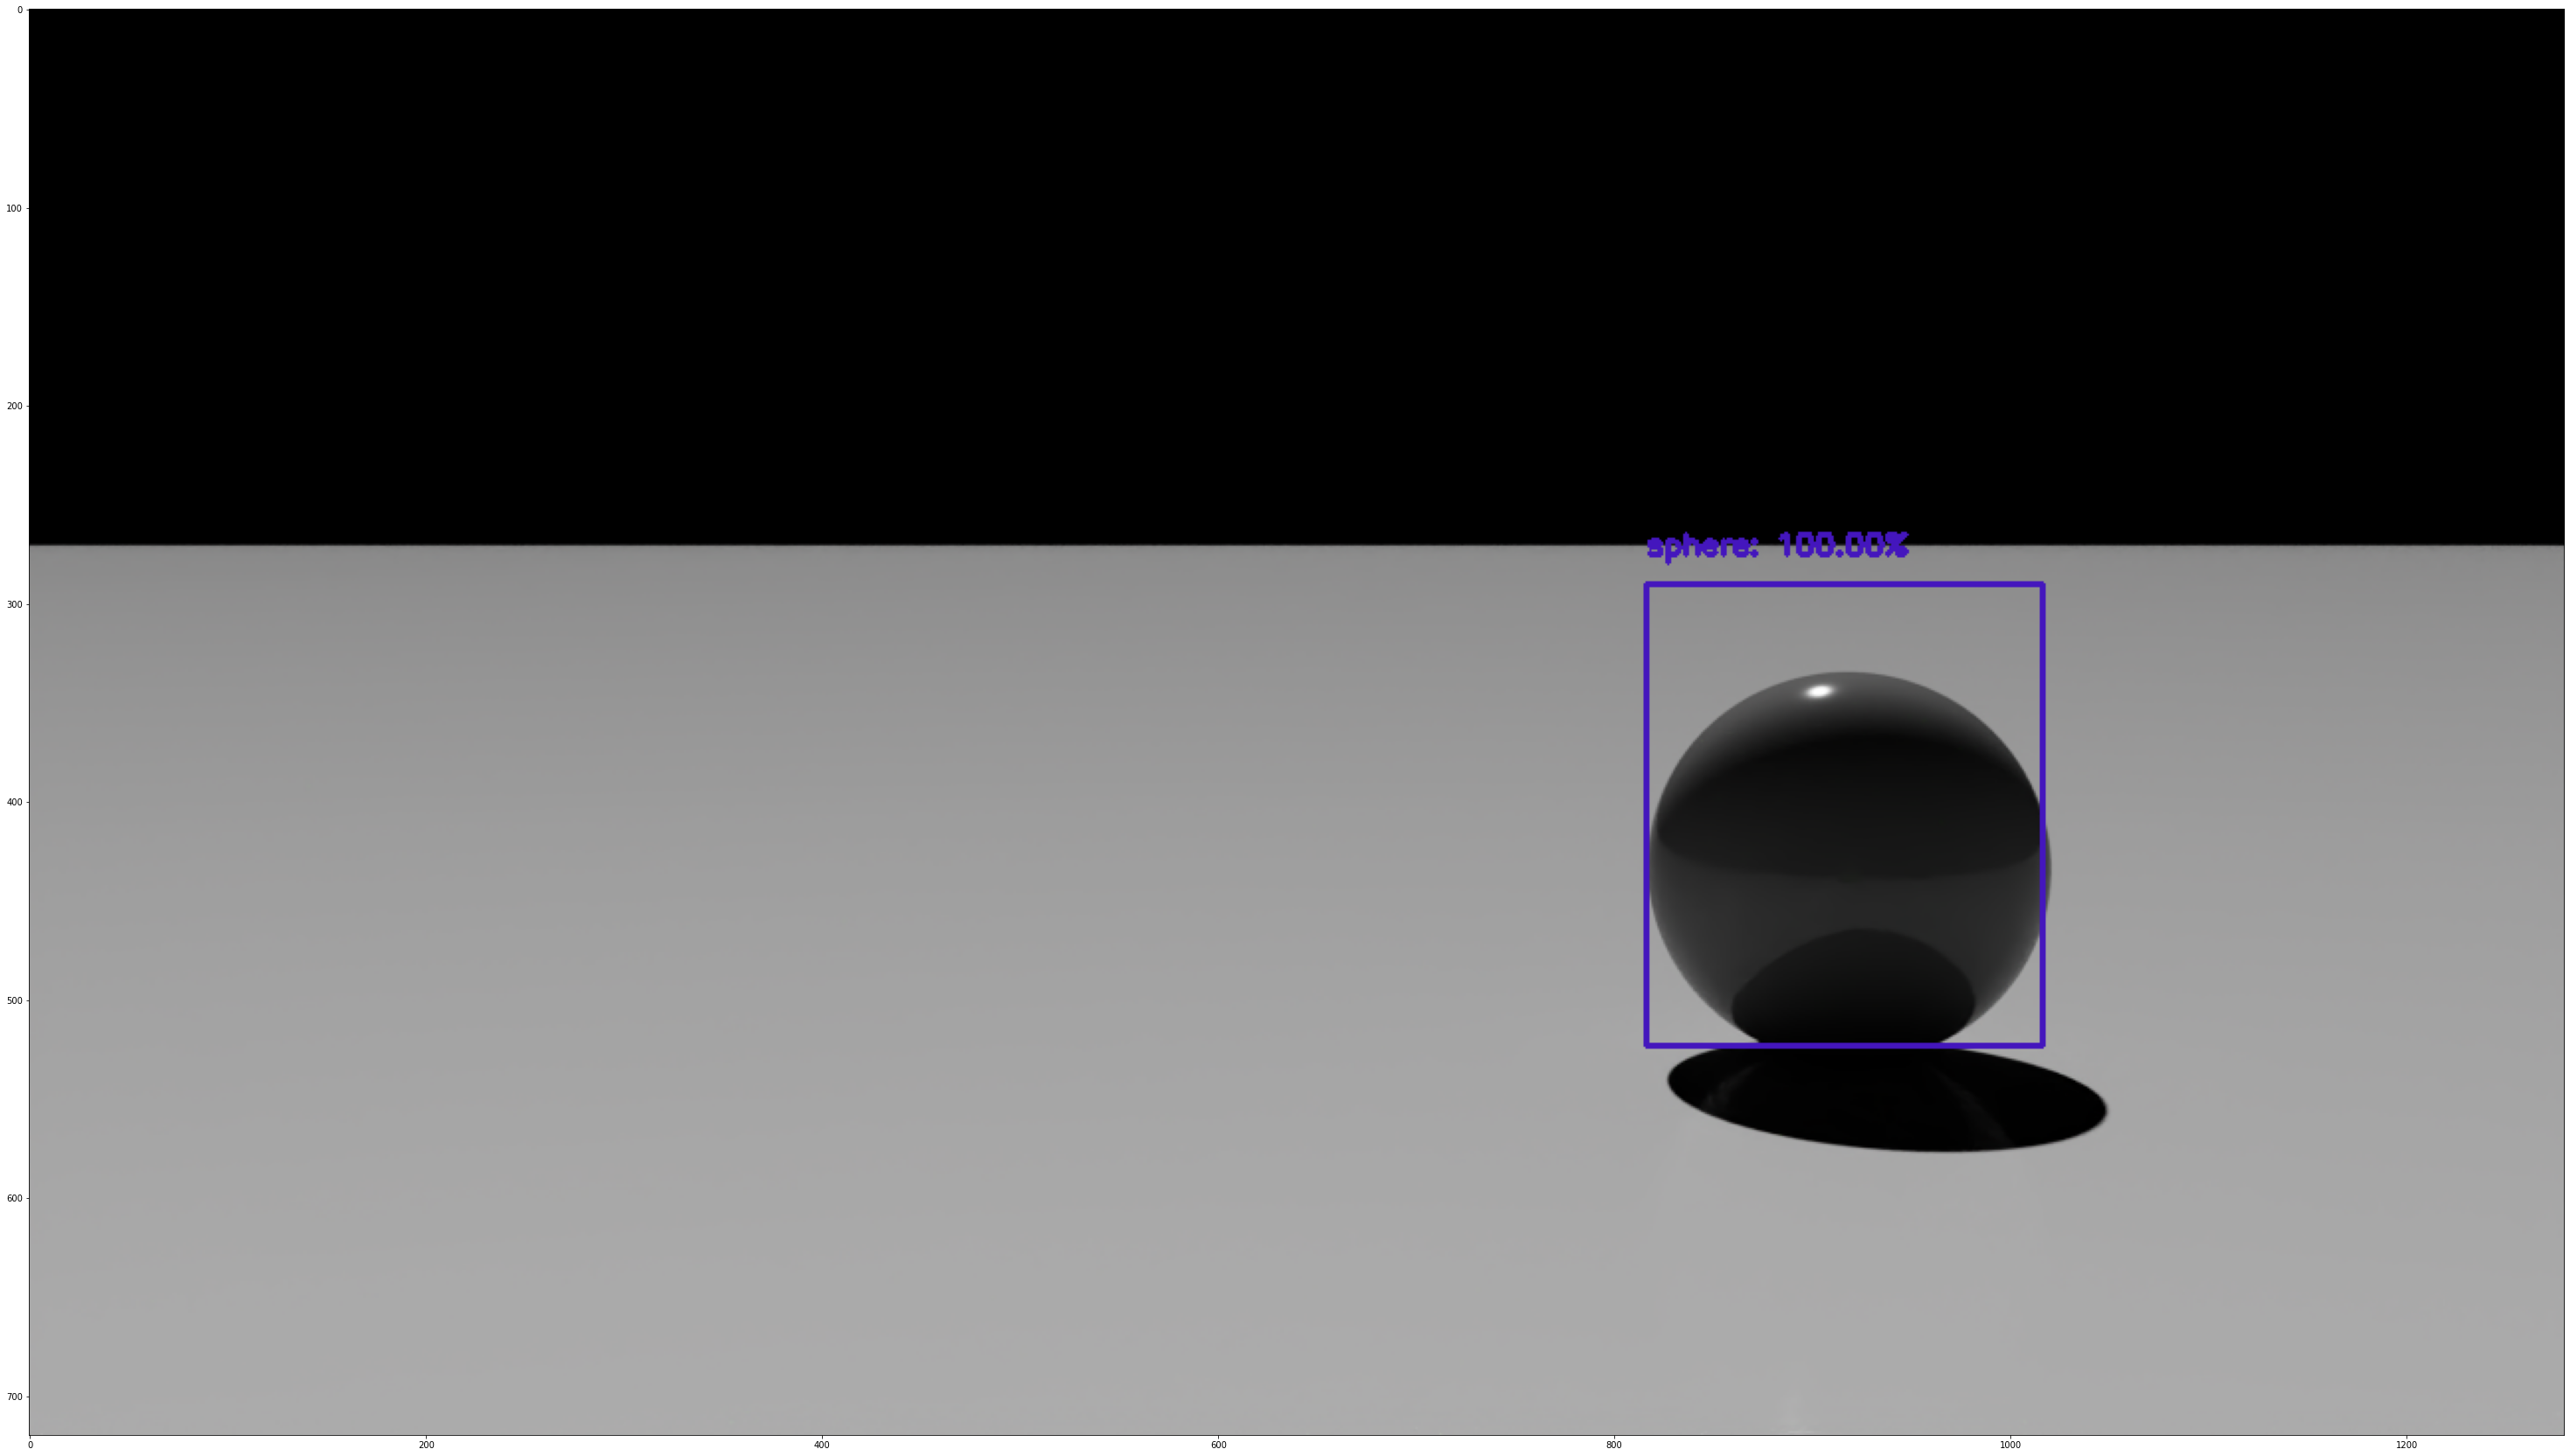

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 816


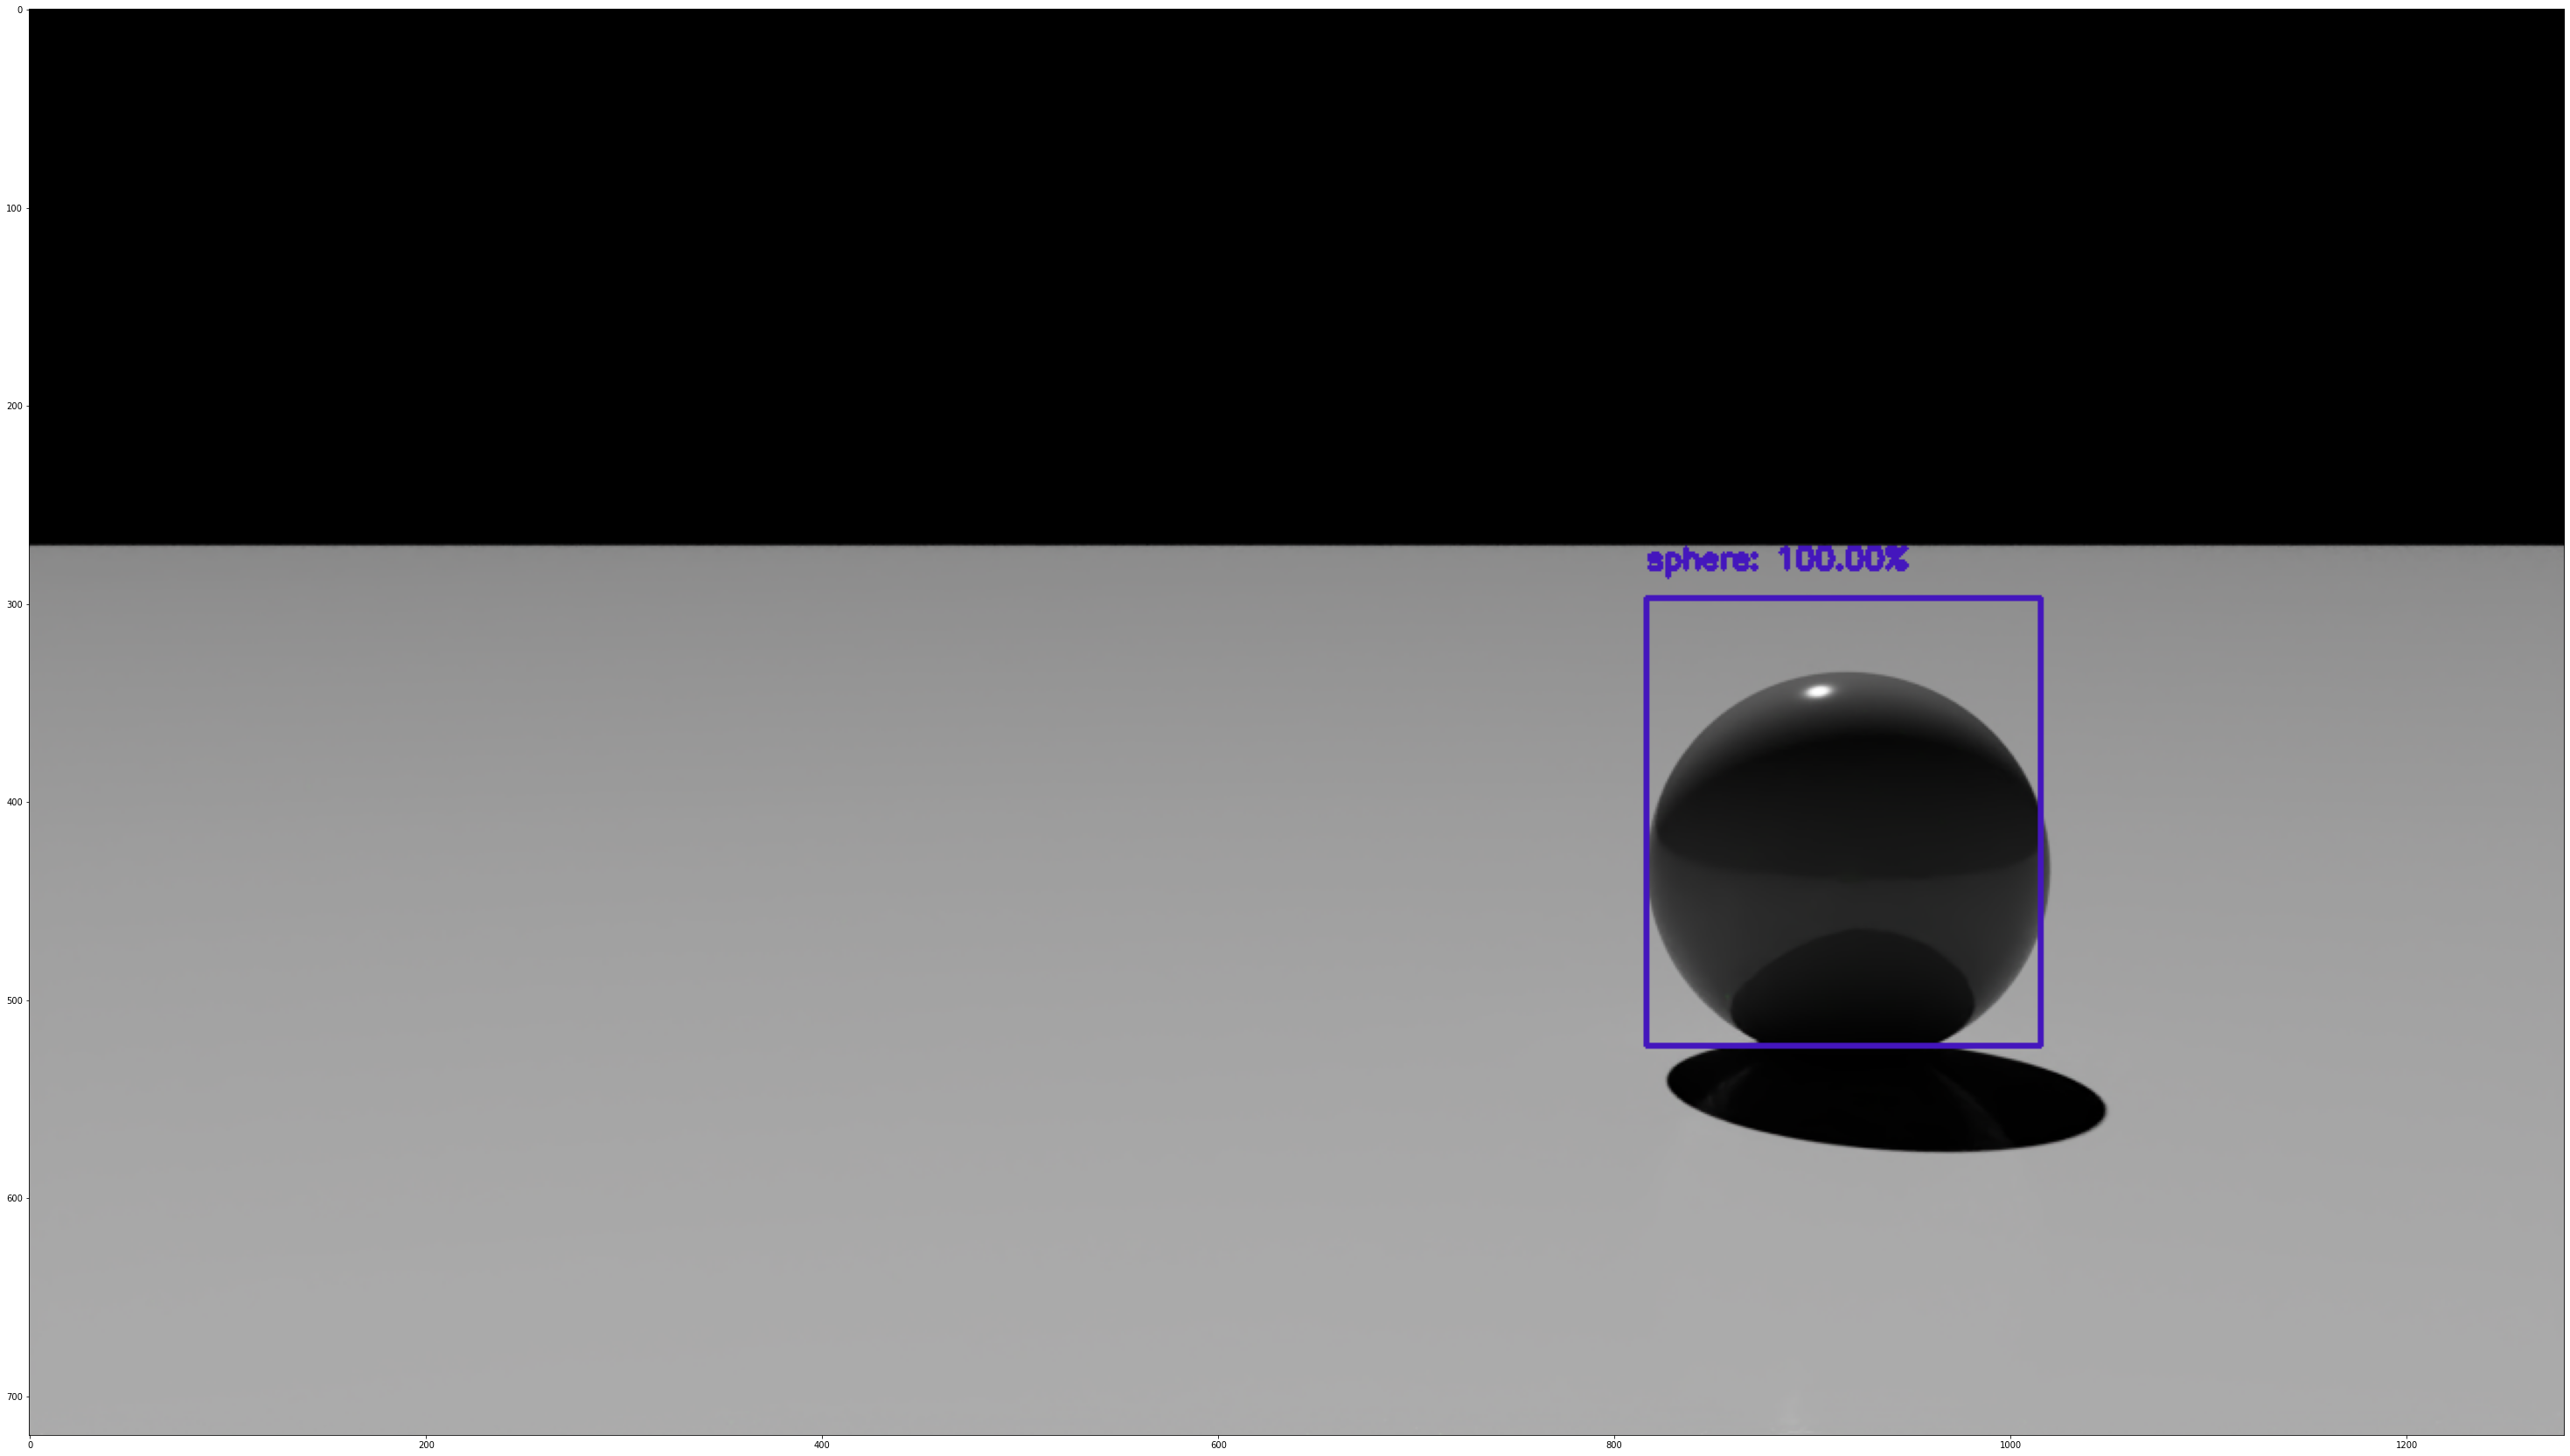

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 792


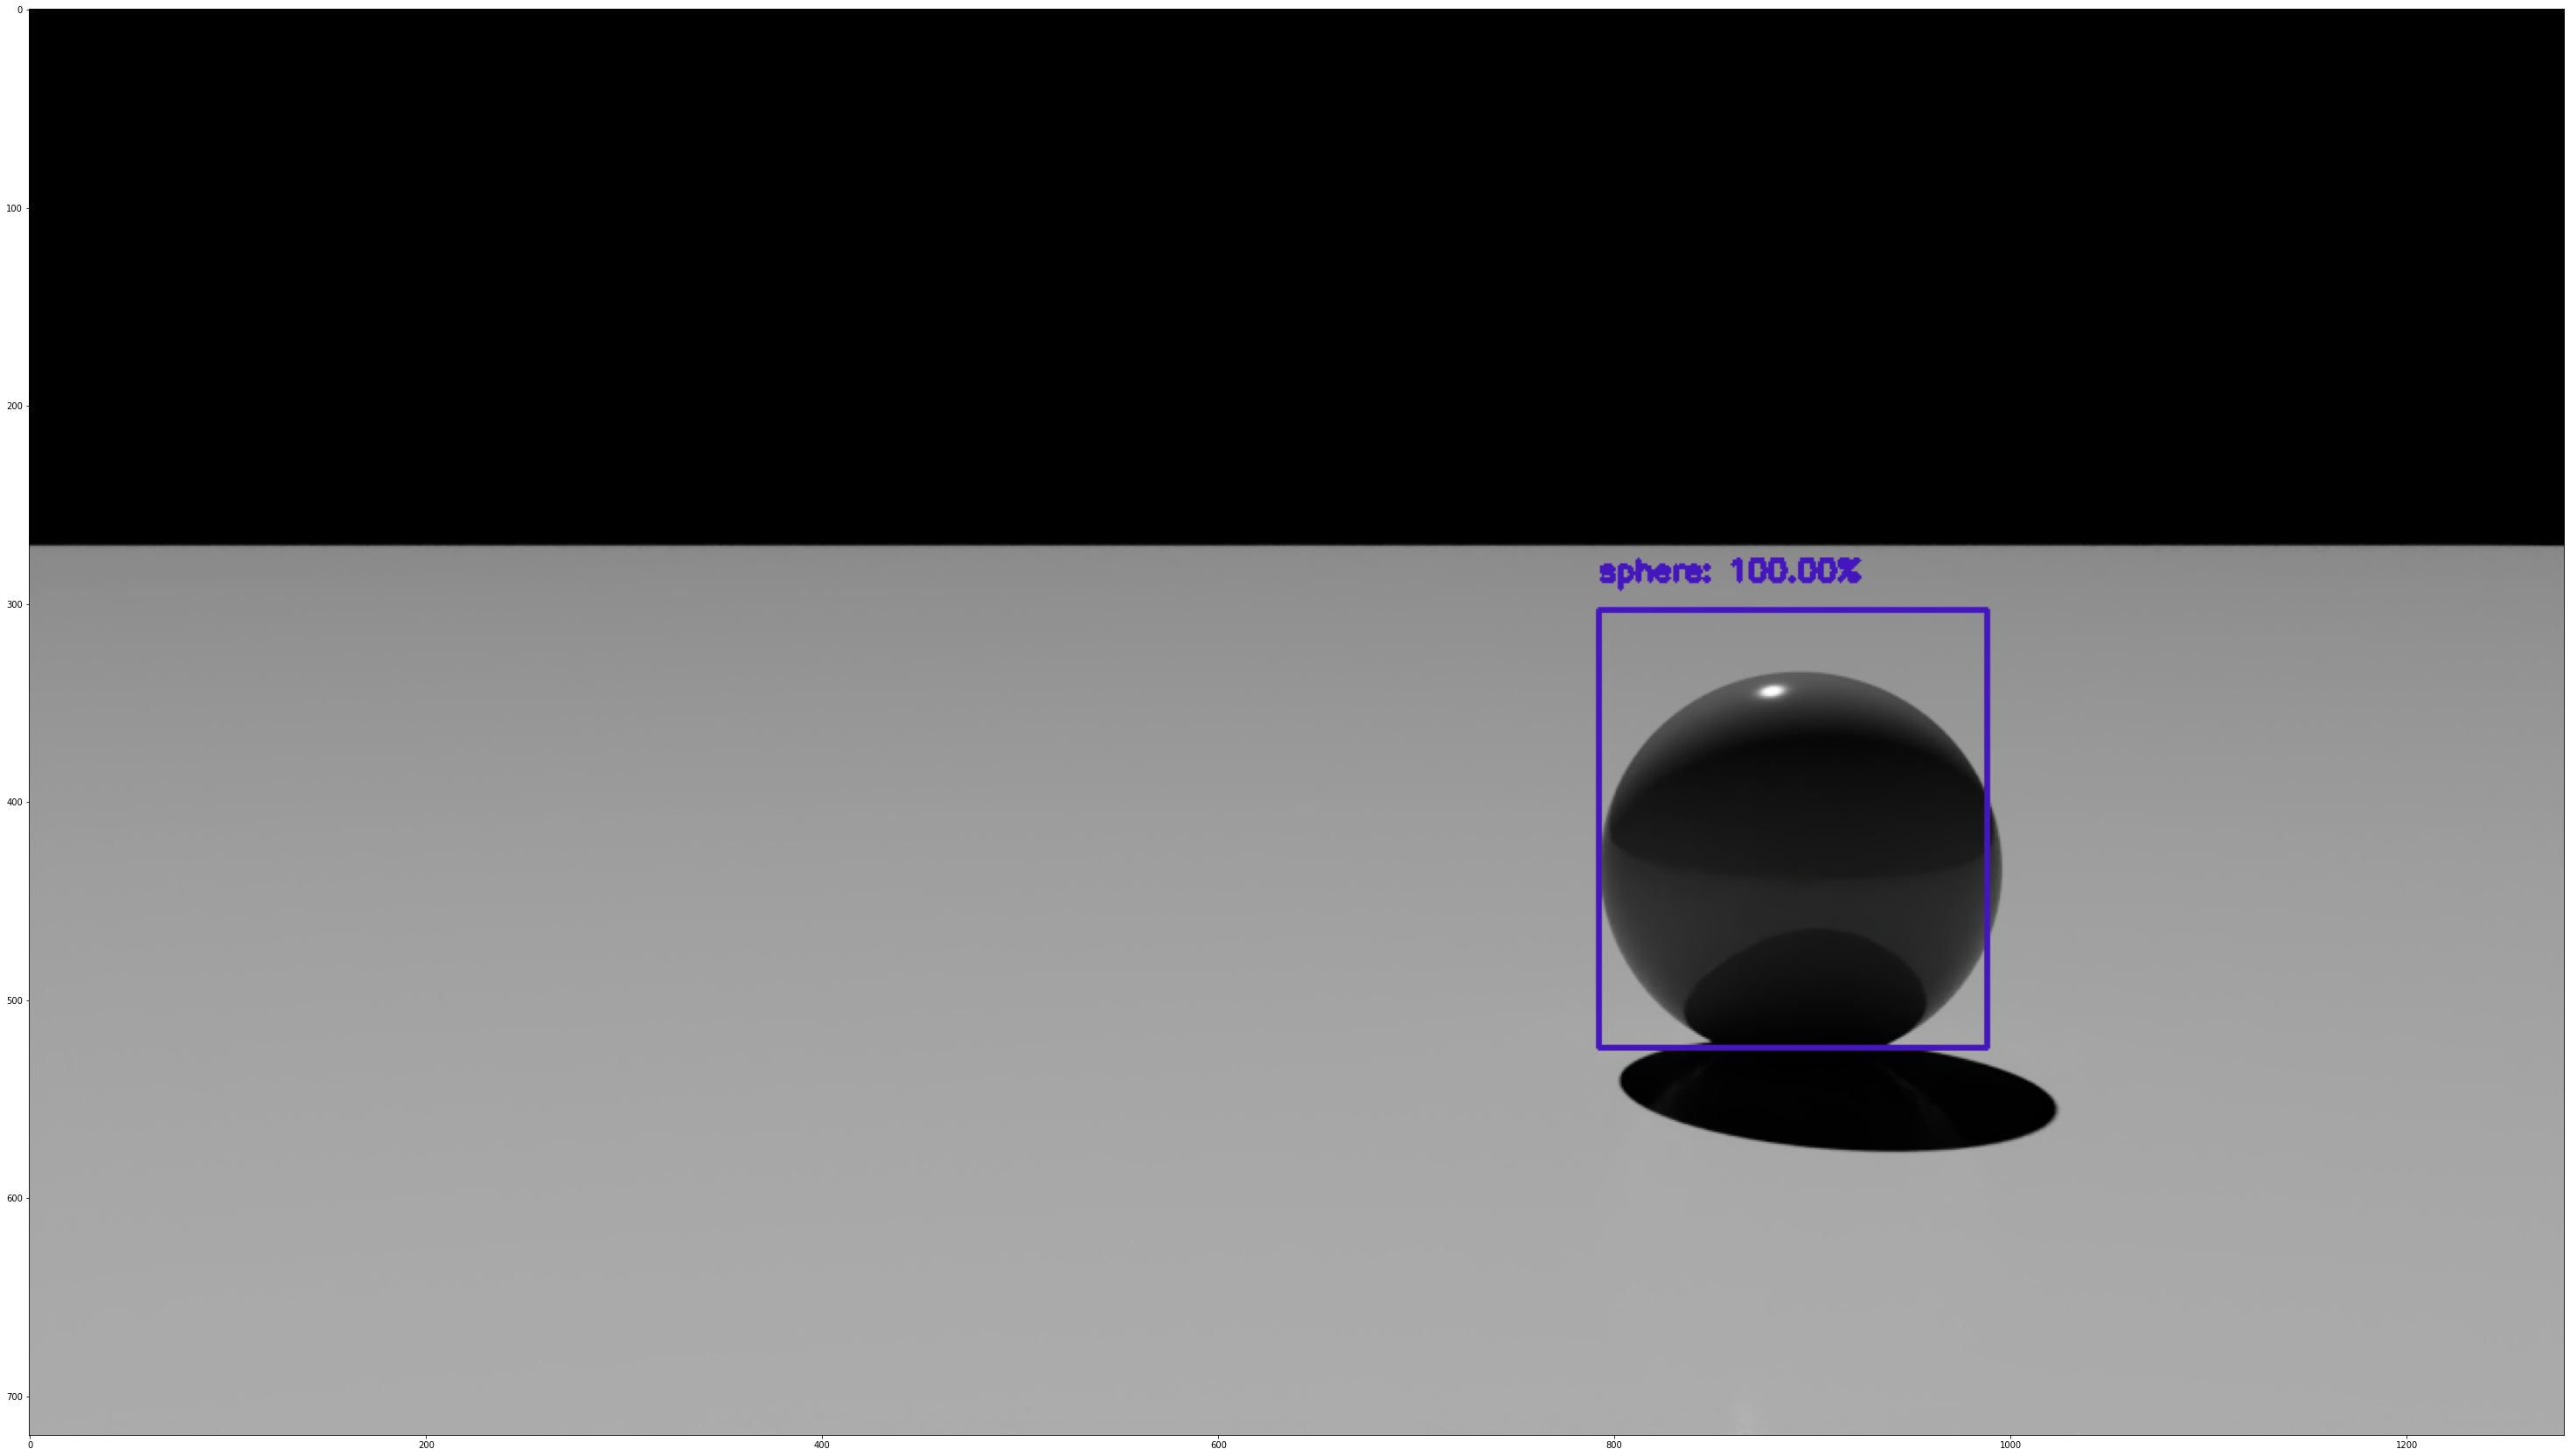

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 772


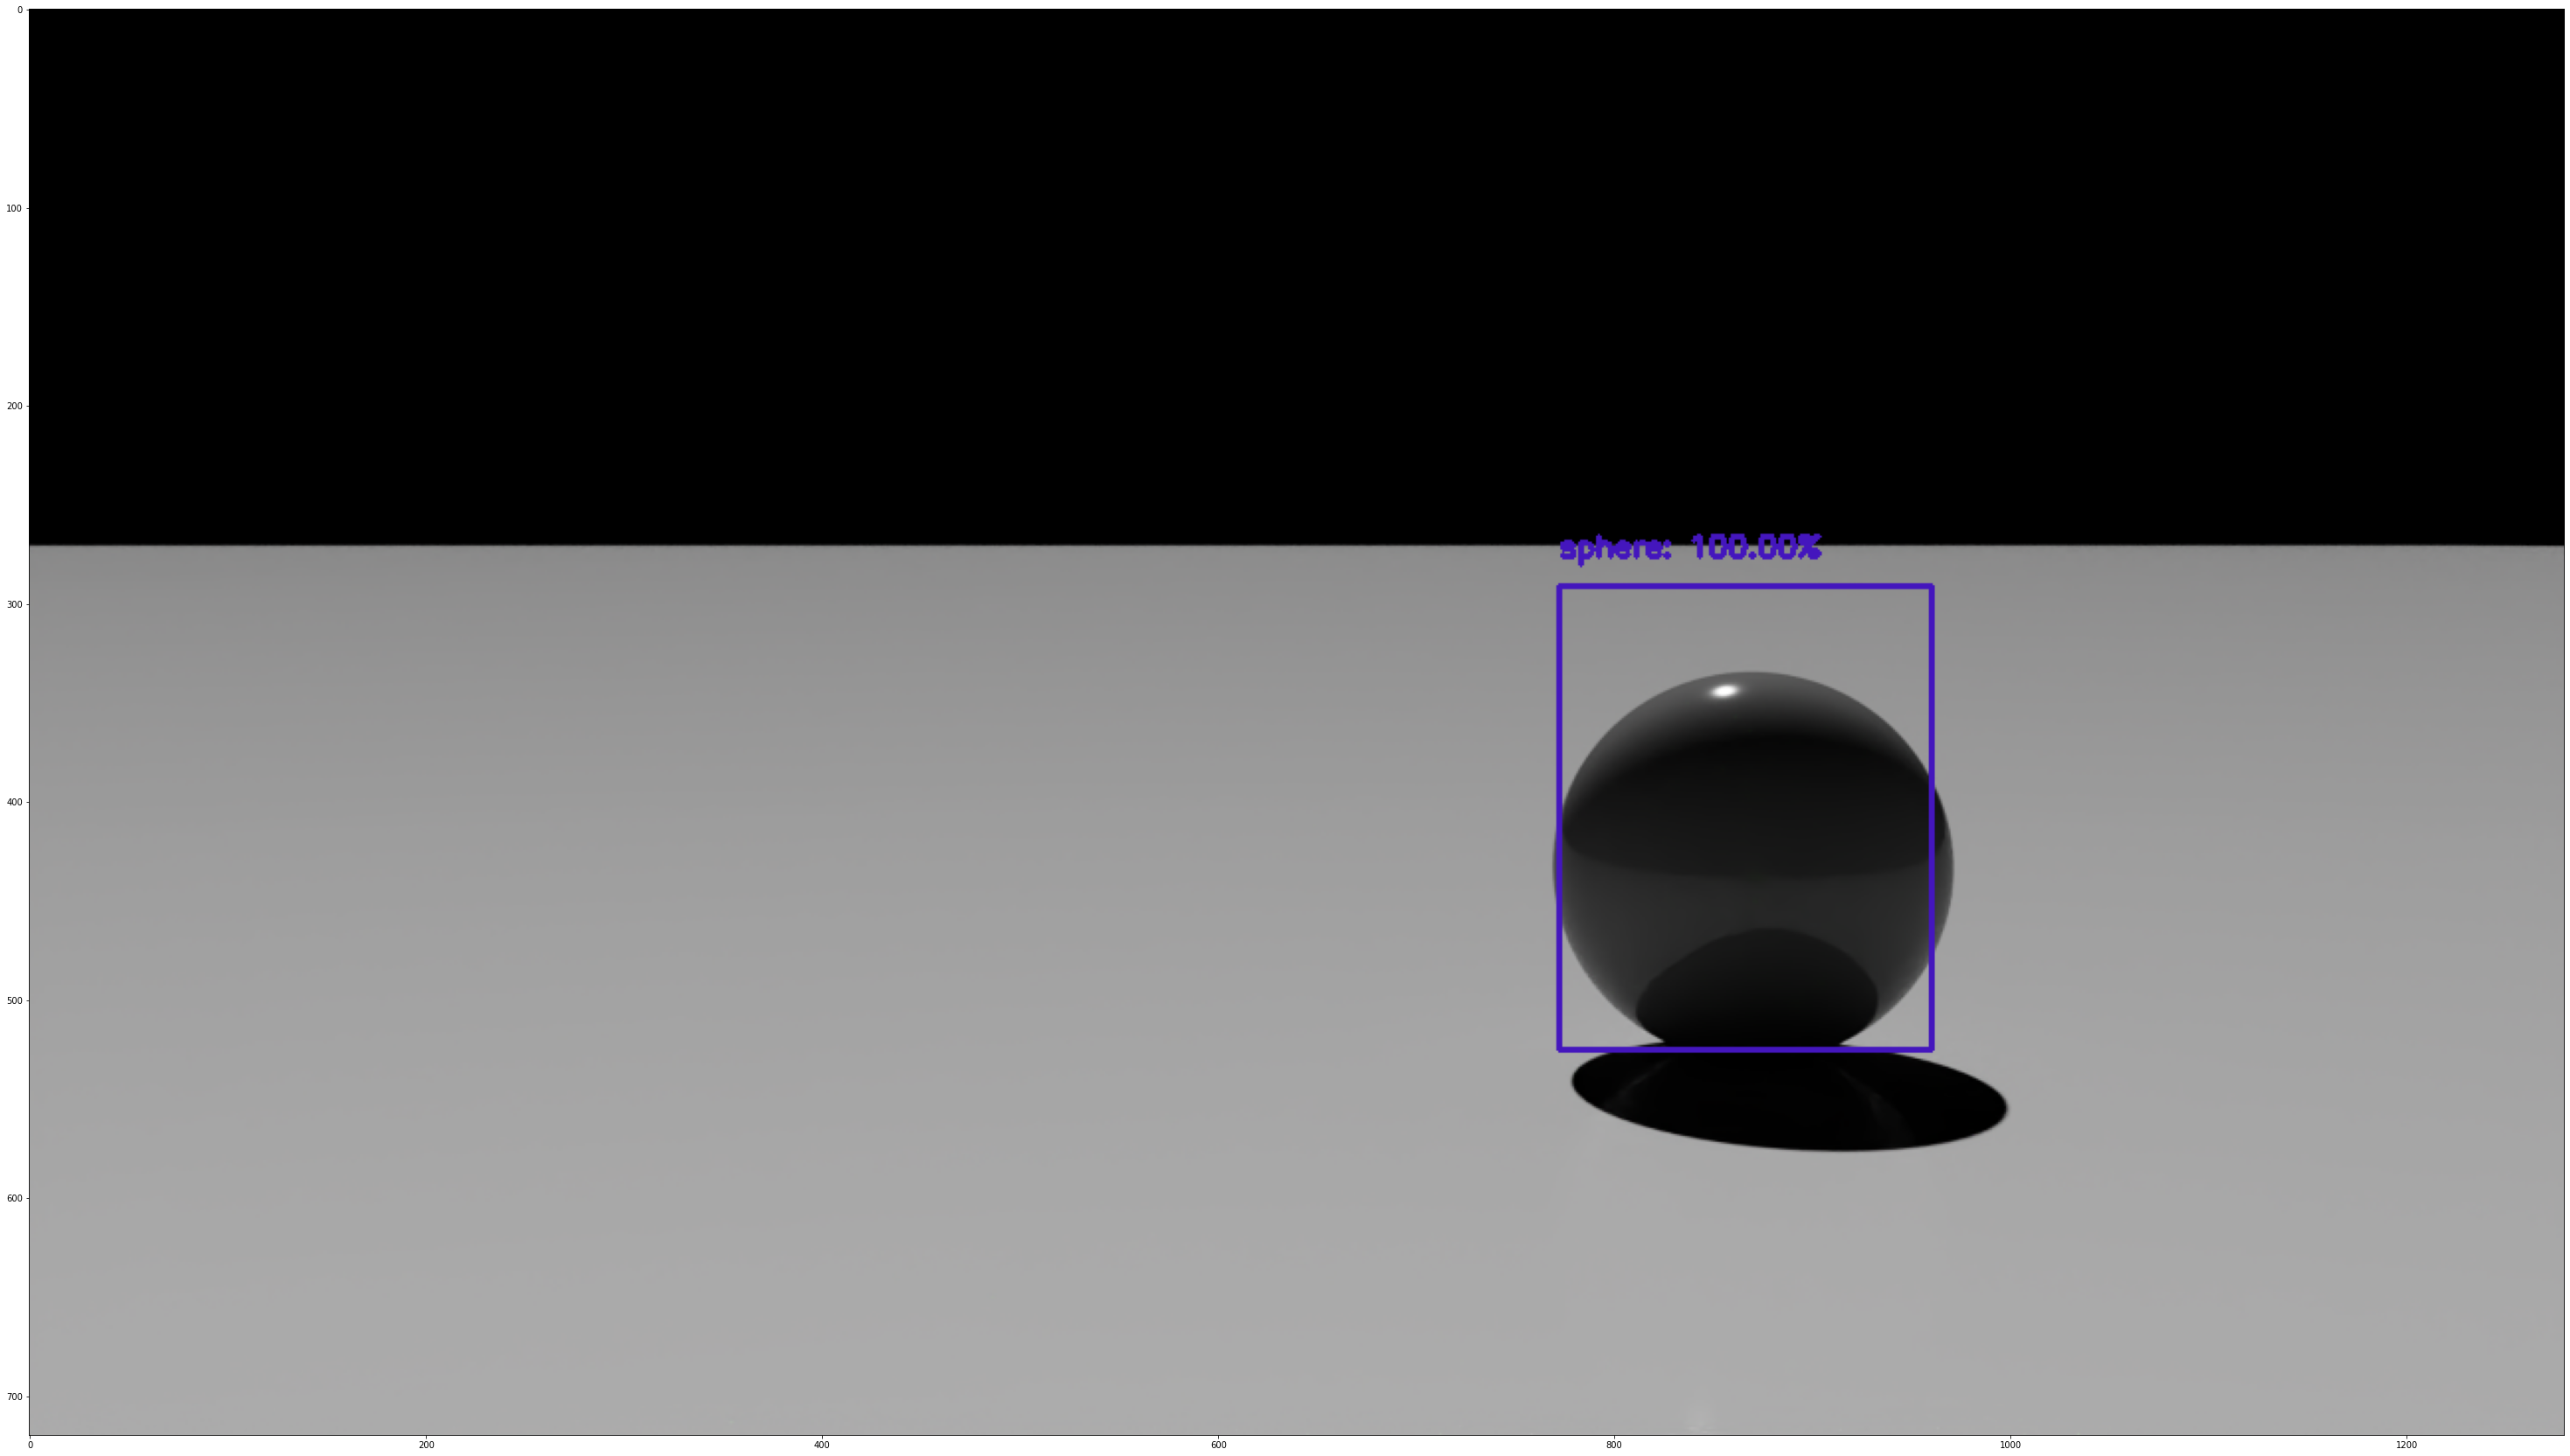

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 745


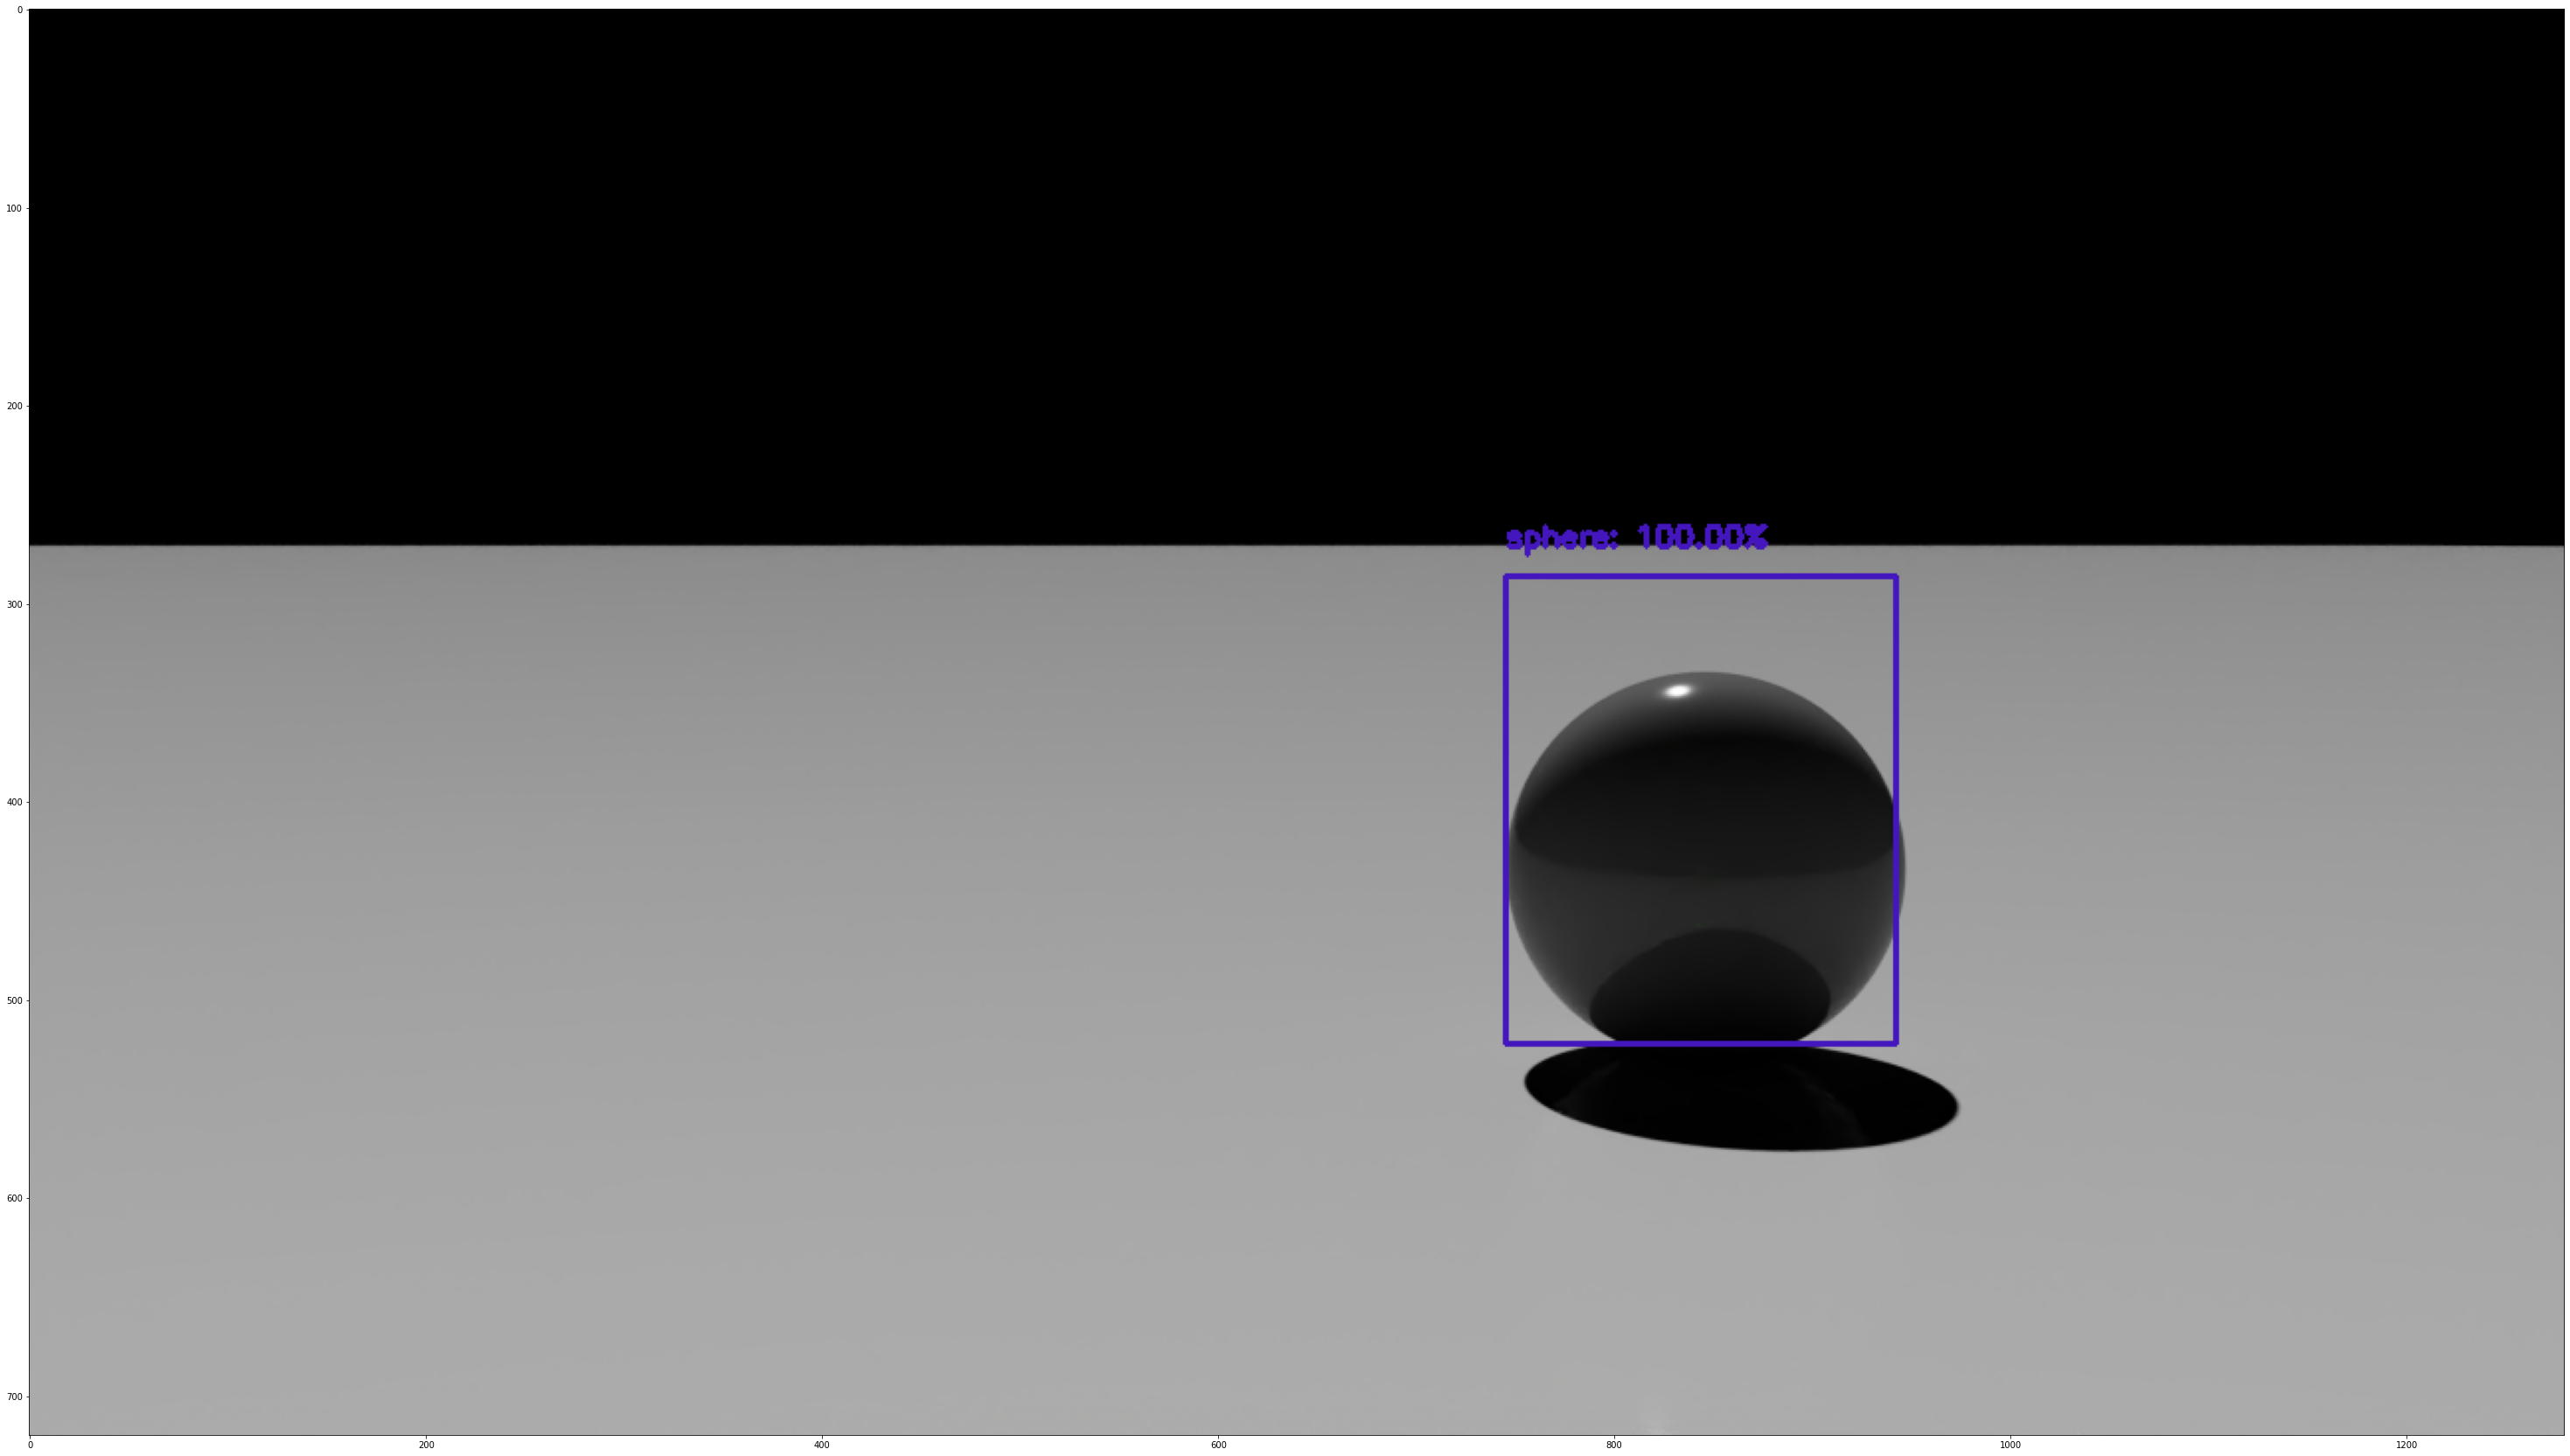

Image input size: 720, 1280
Id: 1
sphere: 99.92%
Detected sphere at X position: 719


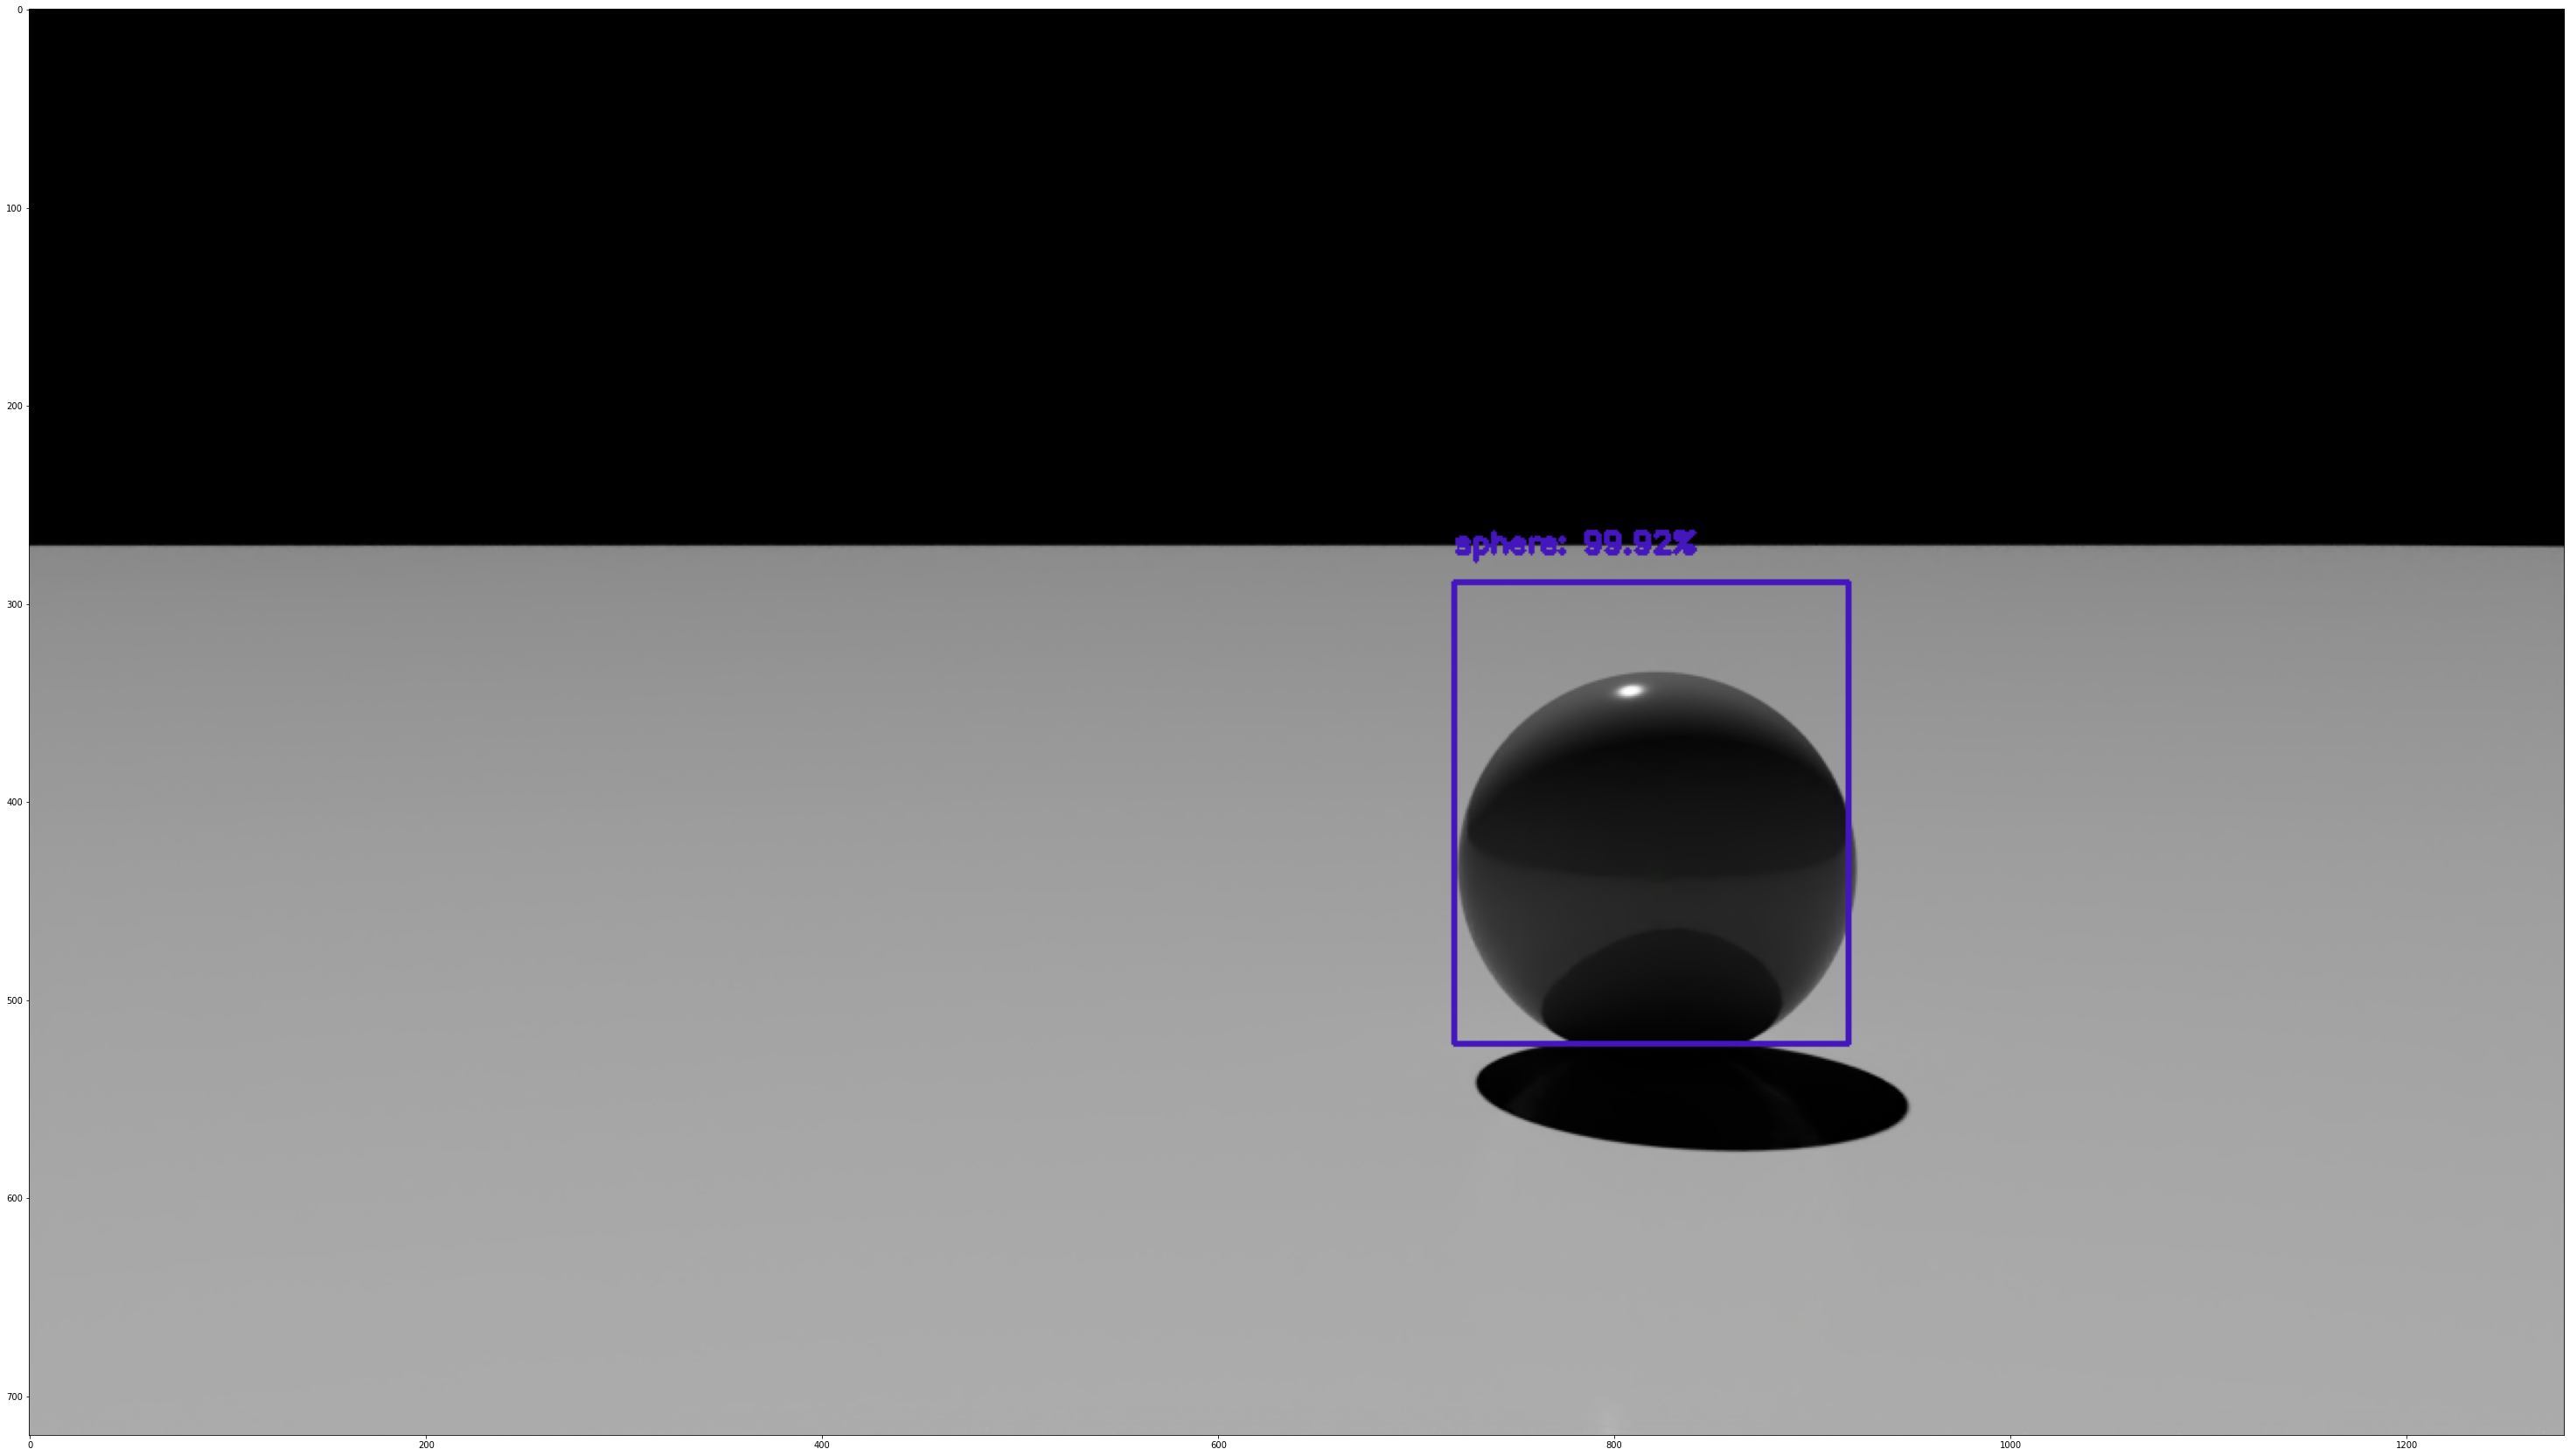

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 698


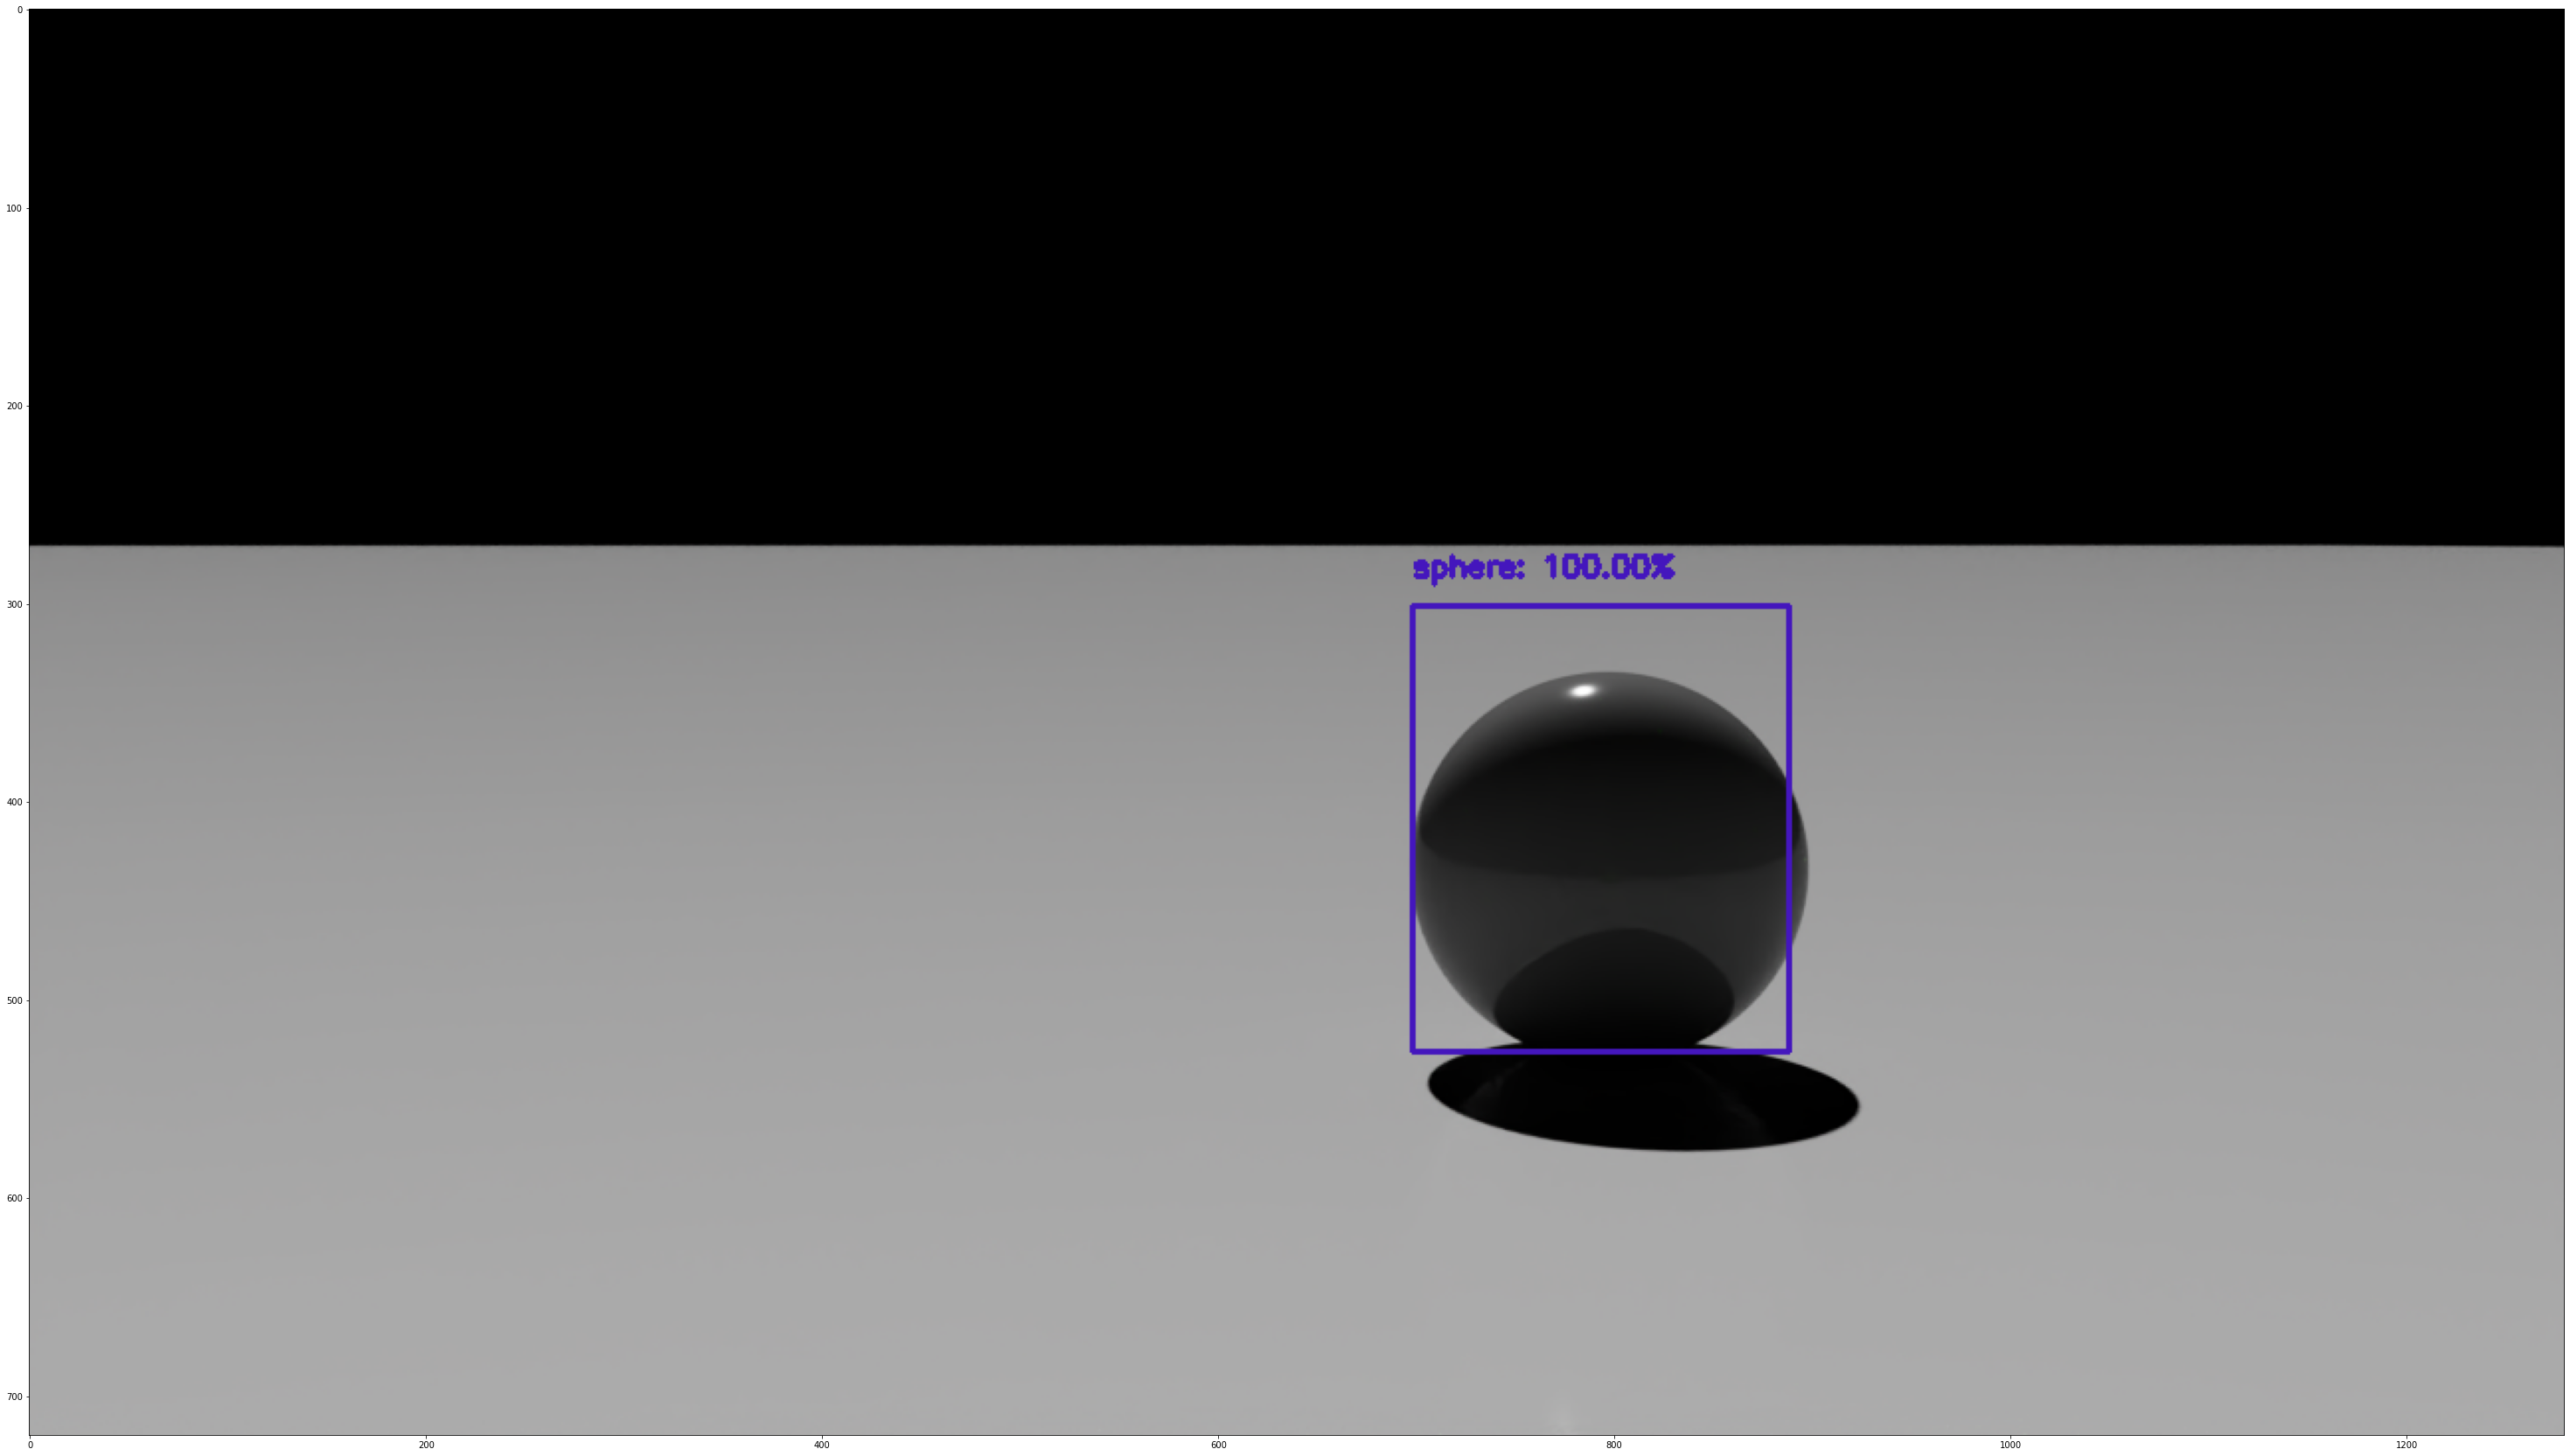

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 671


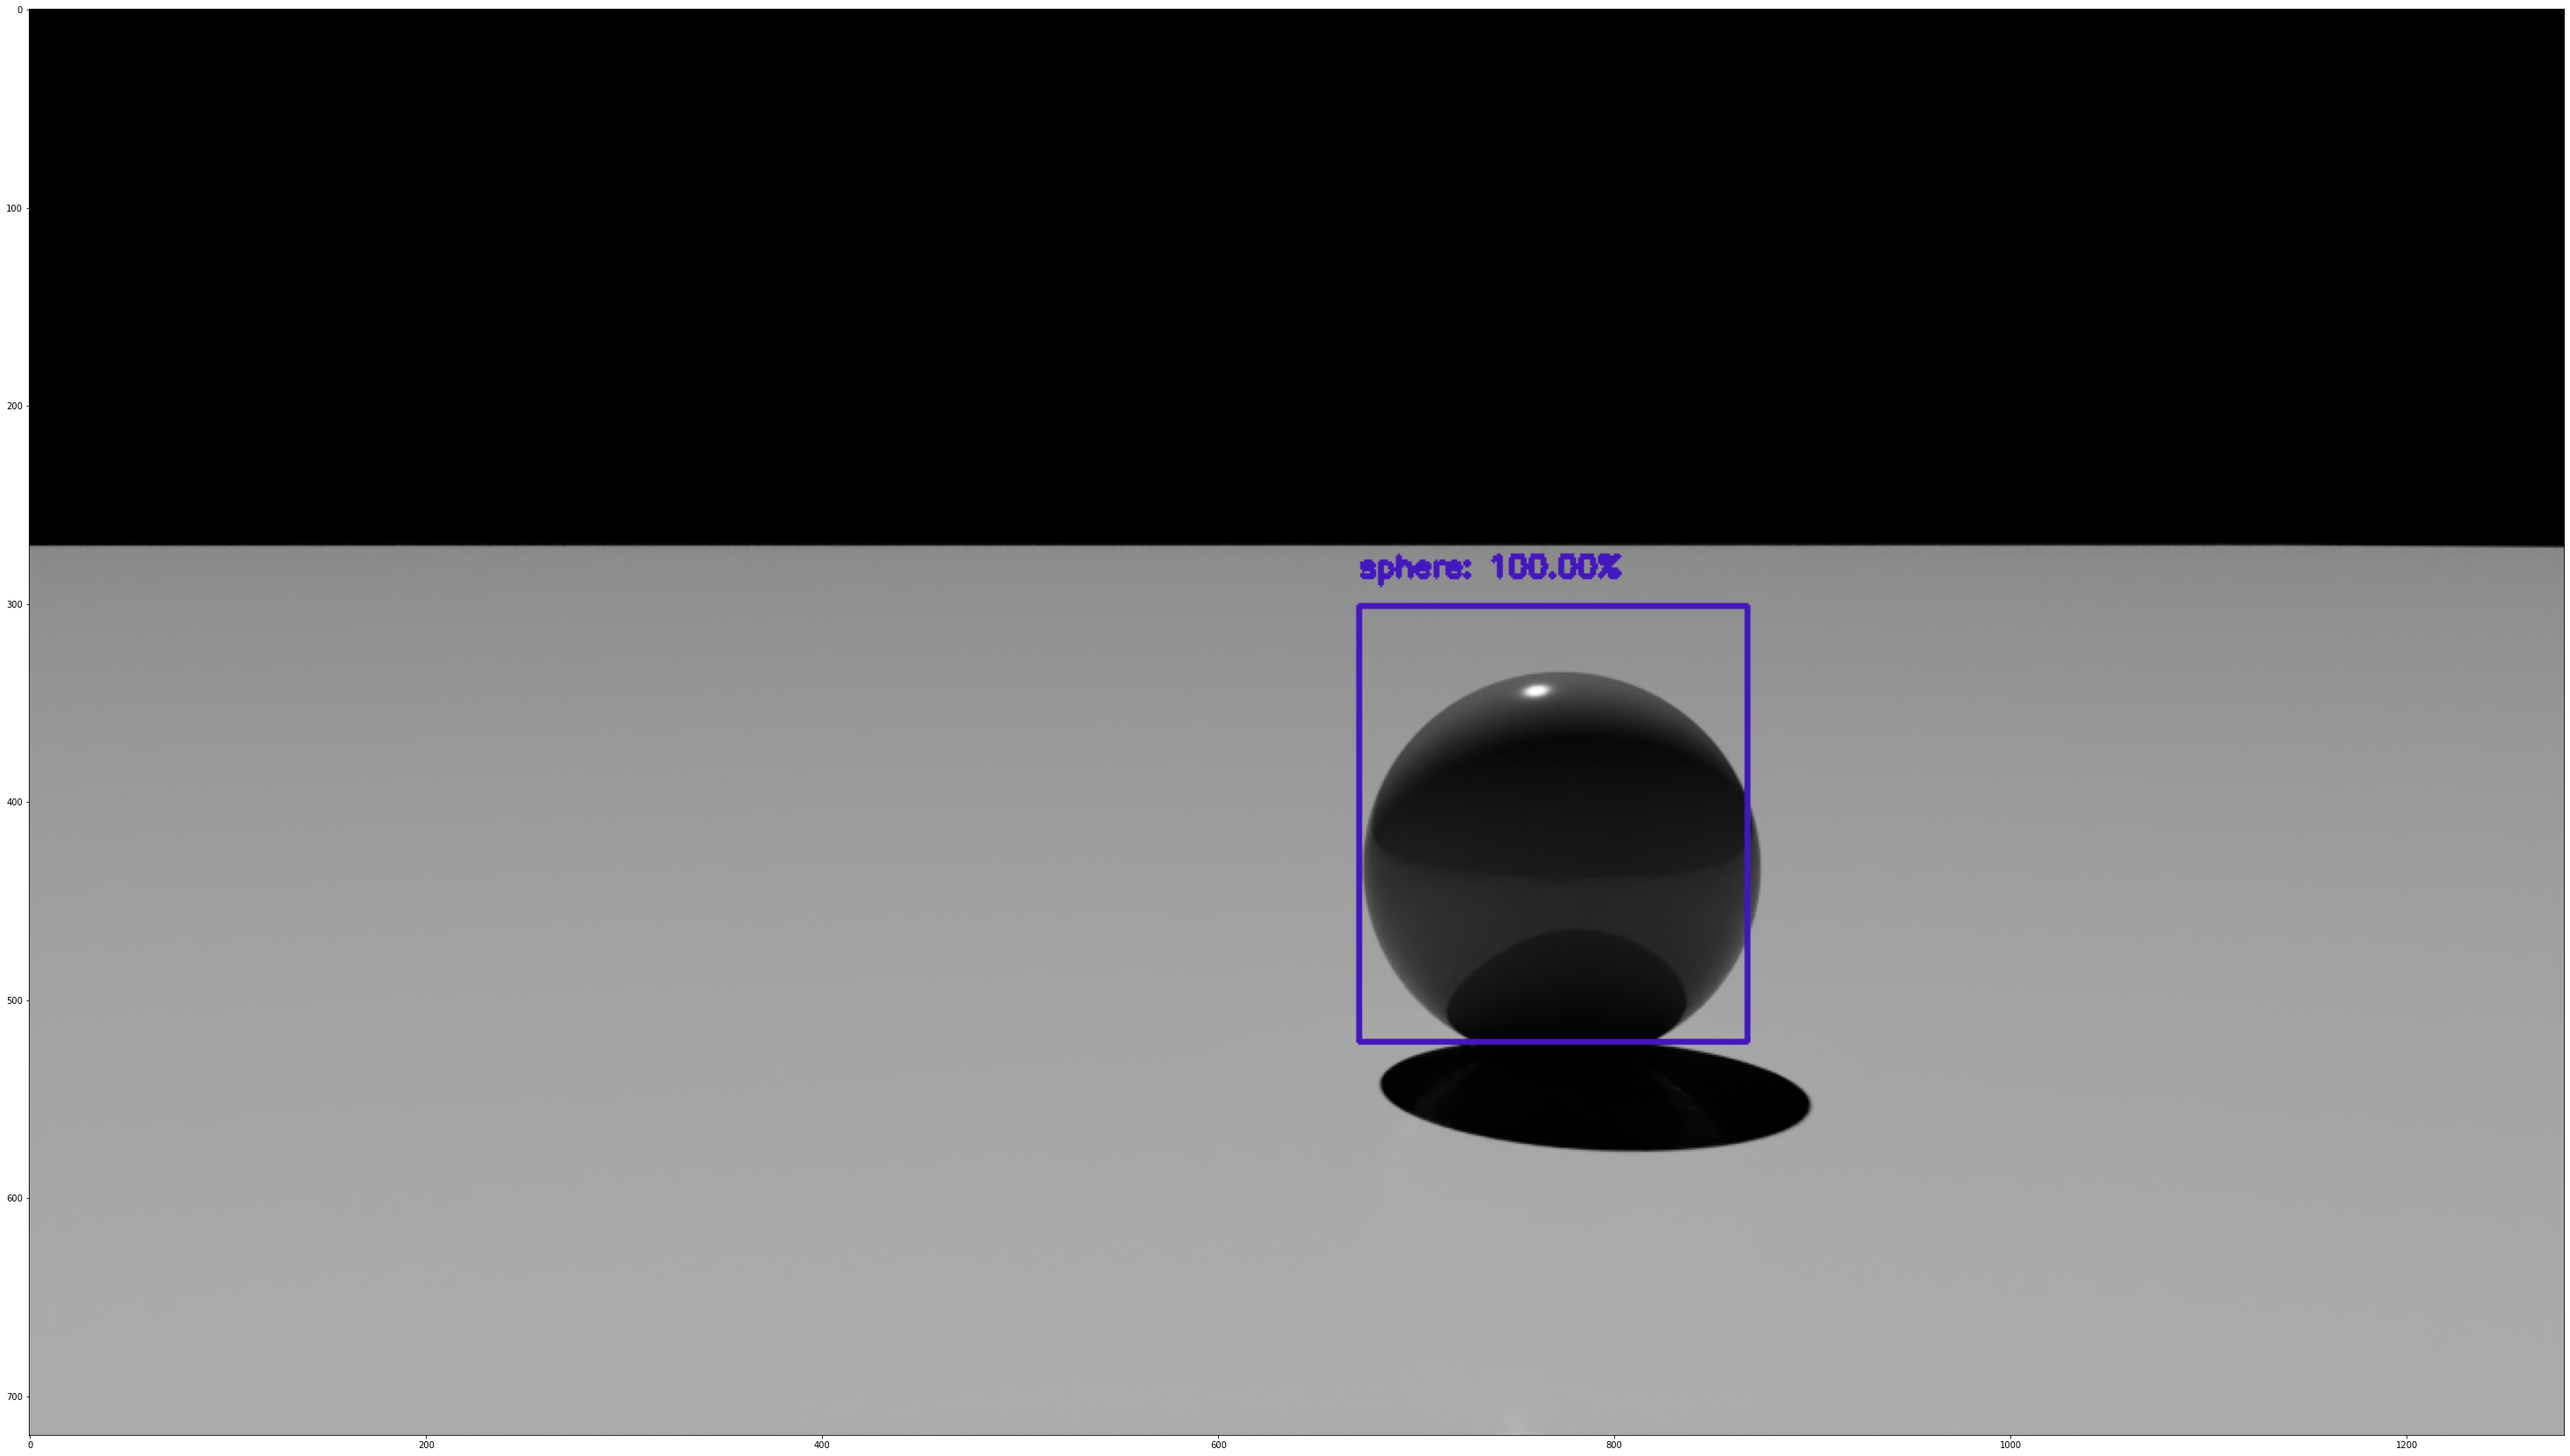

Image input size: 720, 1280
Id: 1
sphere: 99.58%
Detected sphere at X position: 645


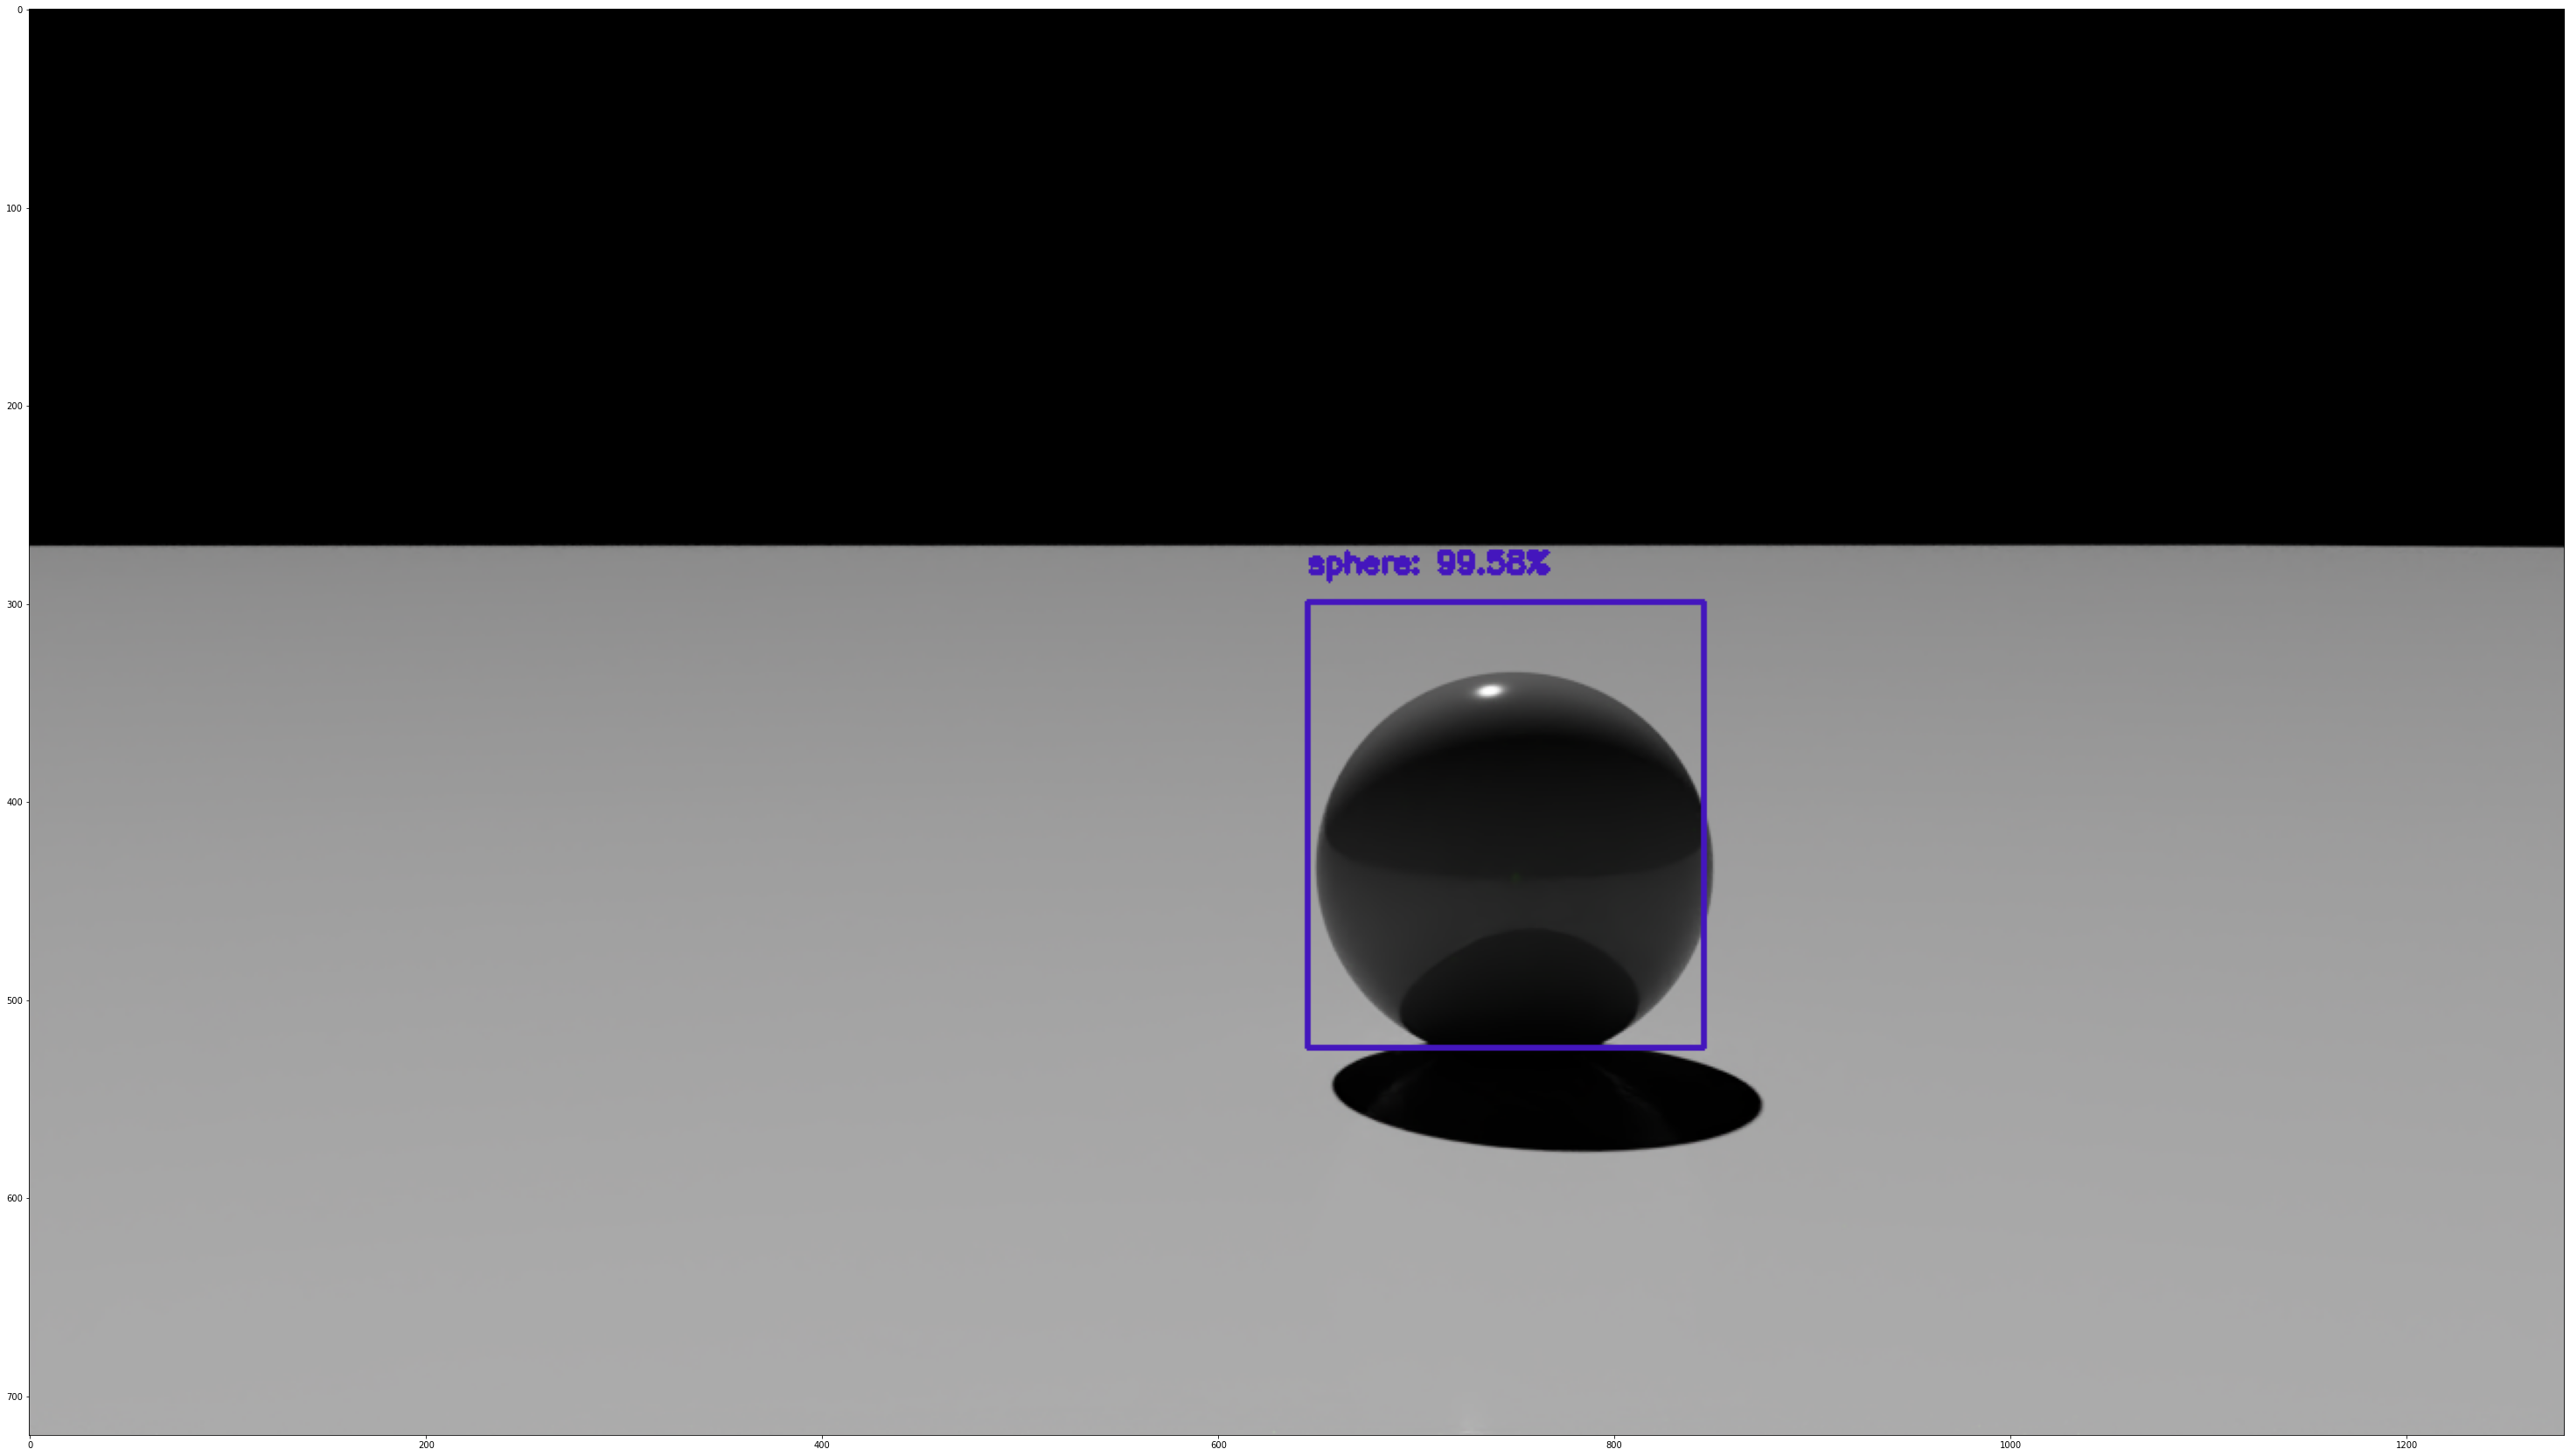

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 629


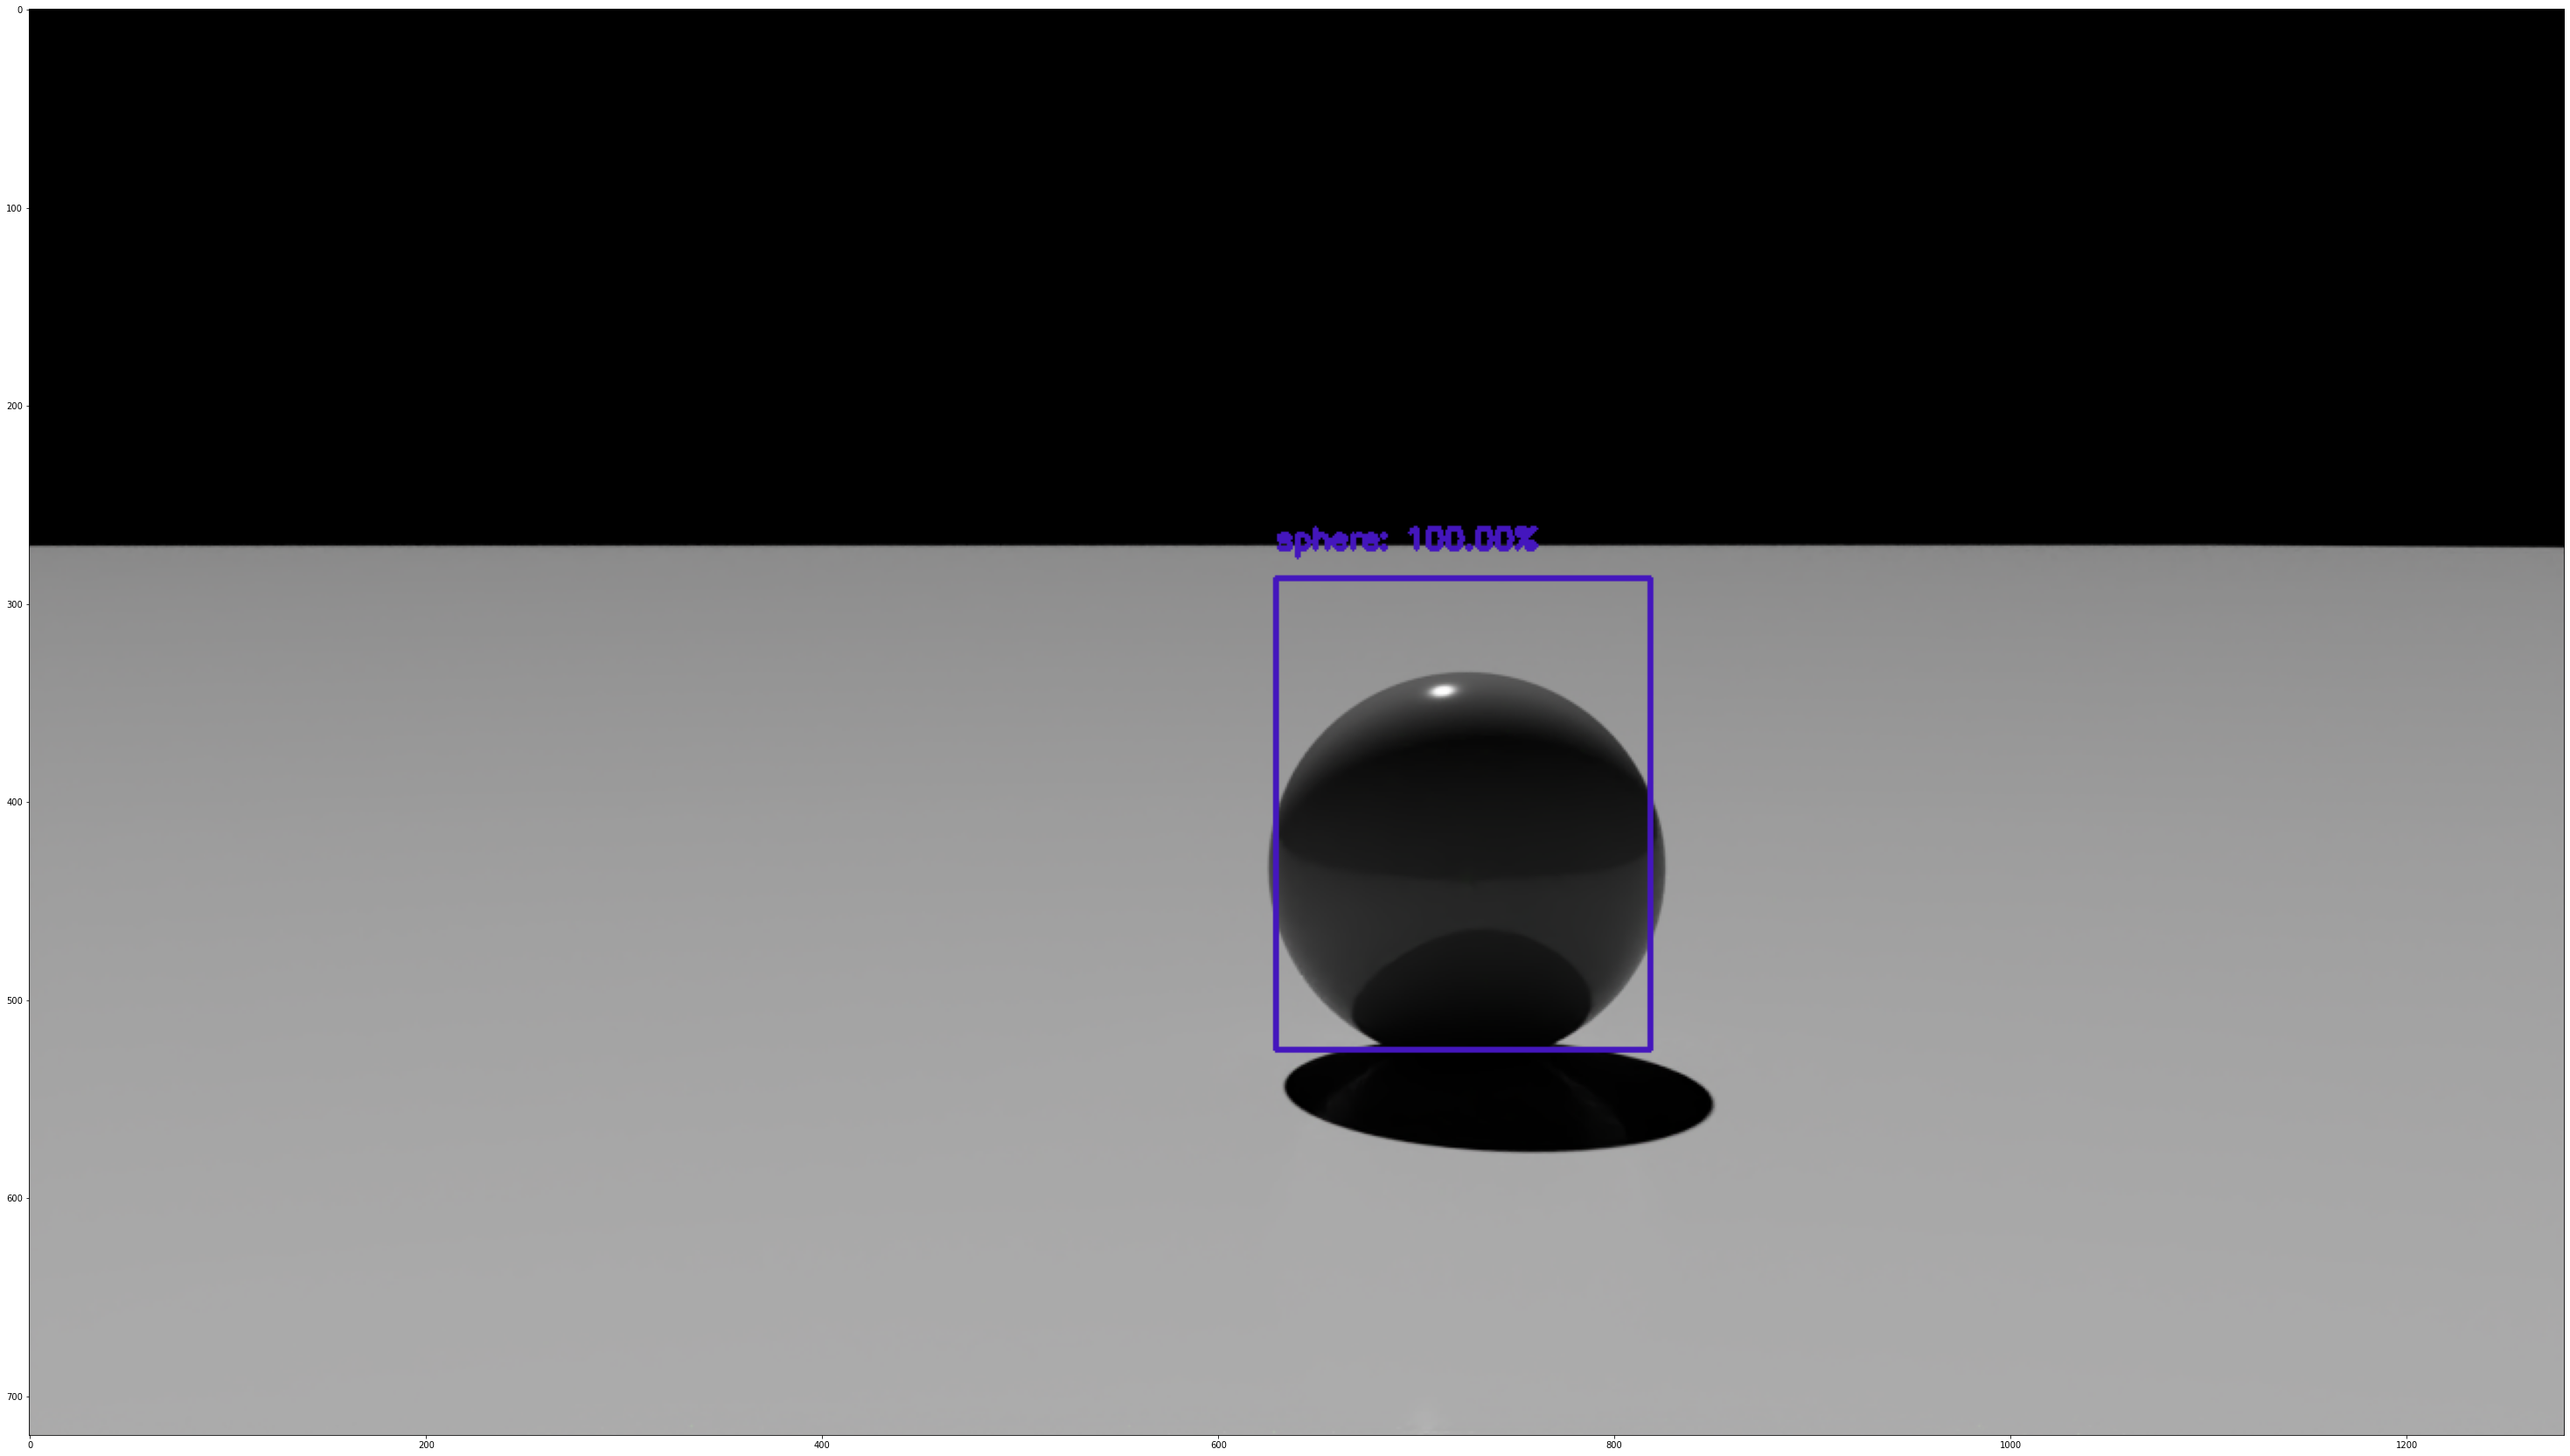

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 601


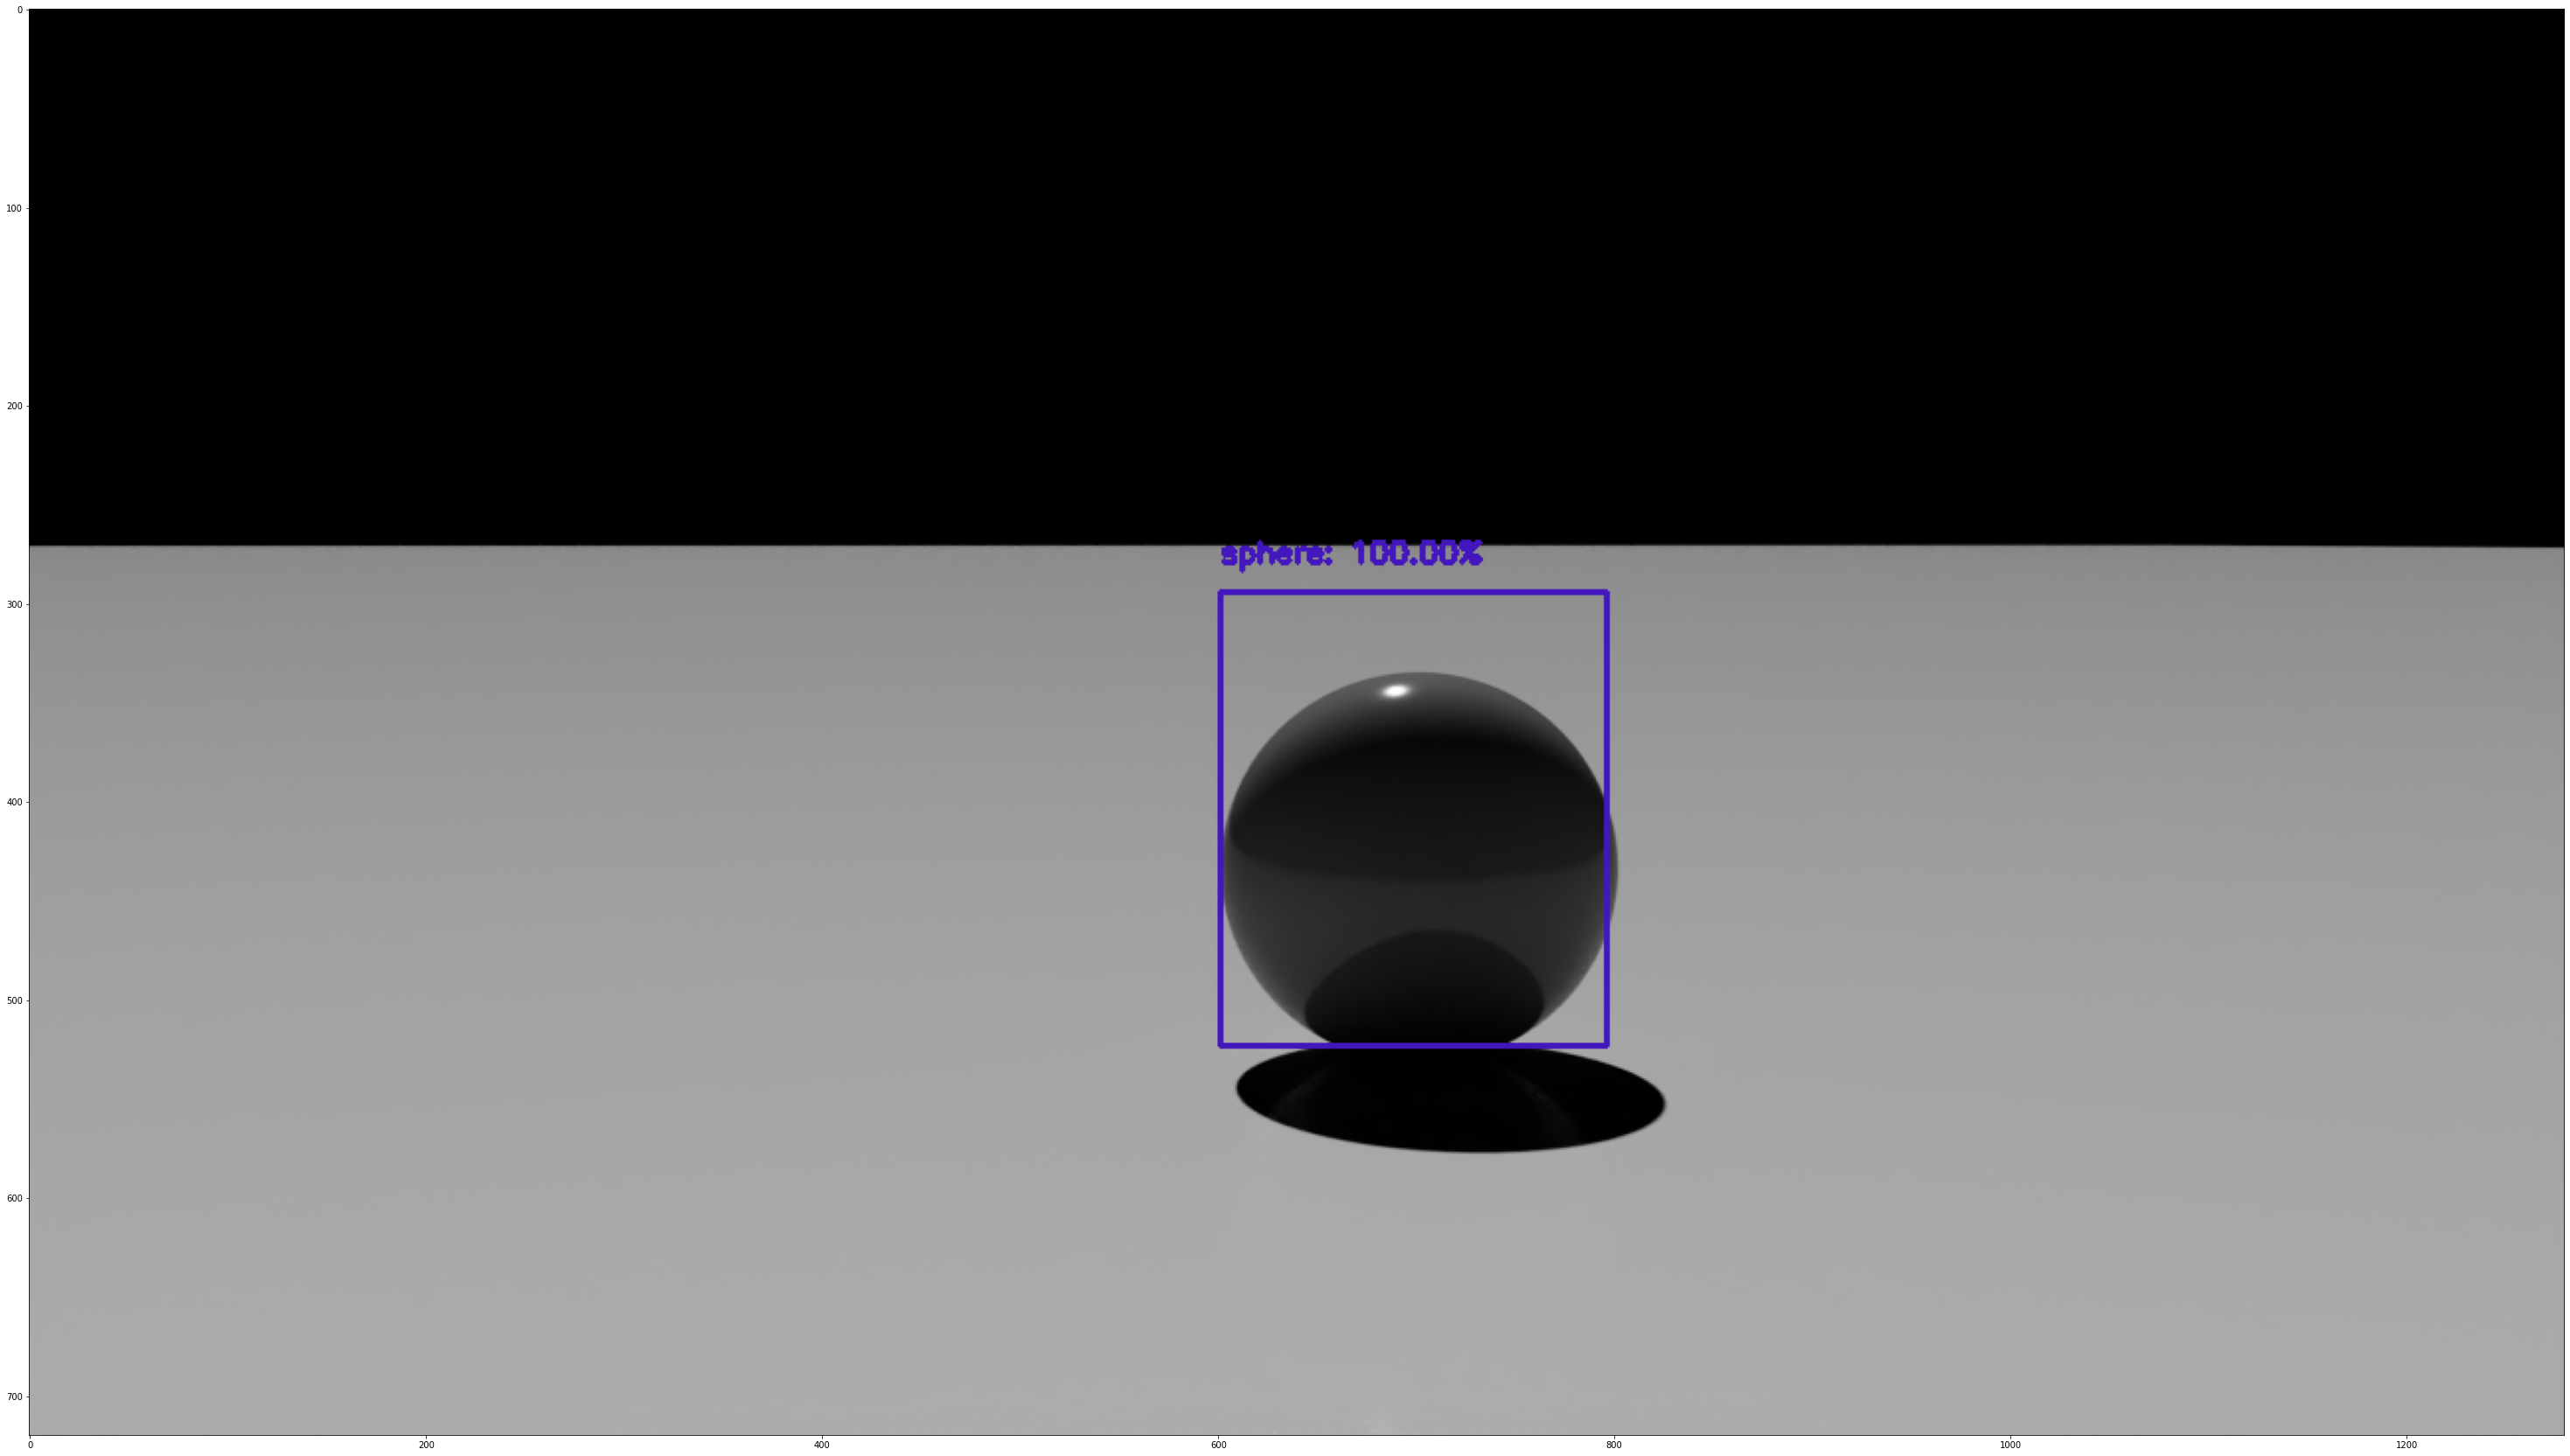

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 622


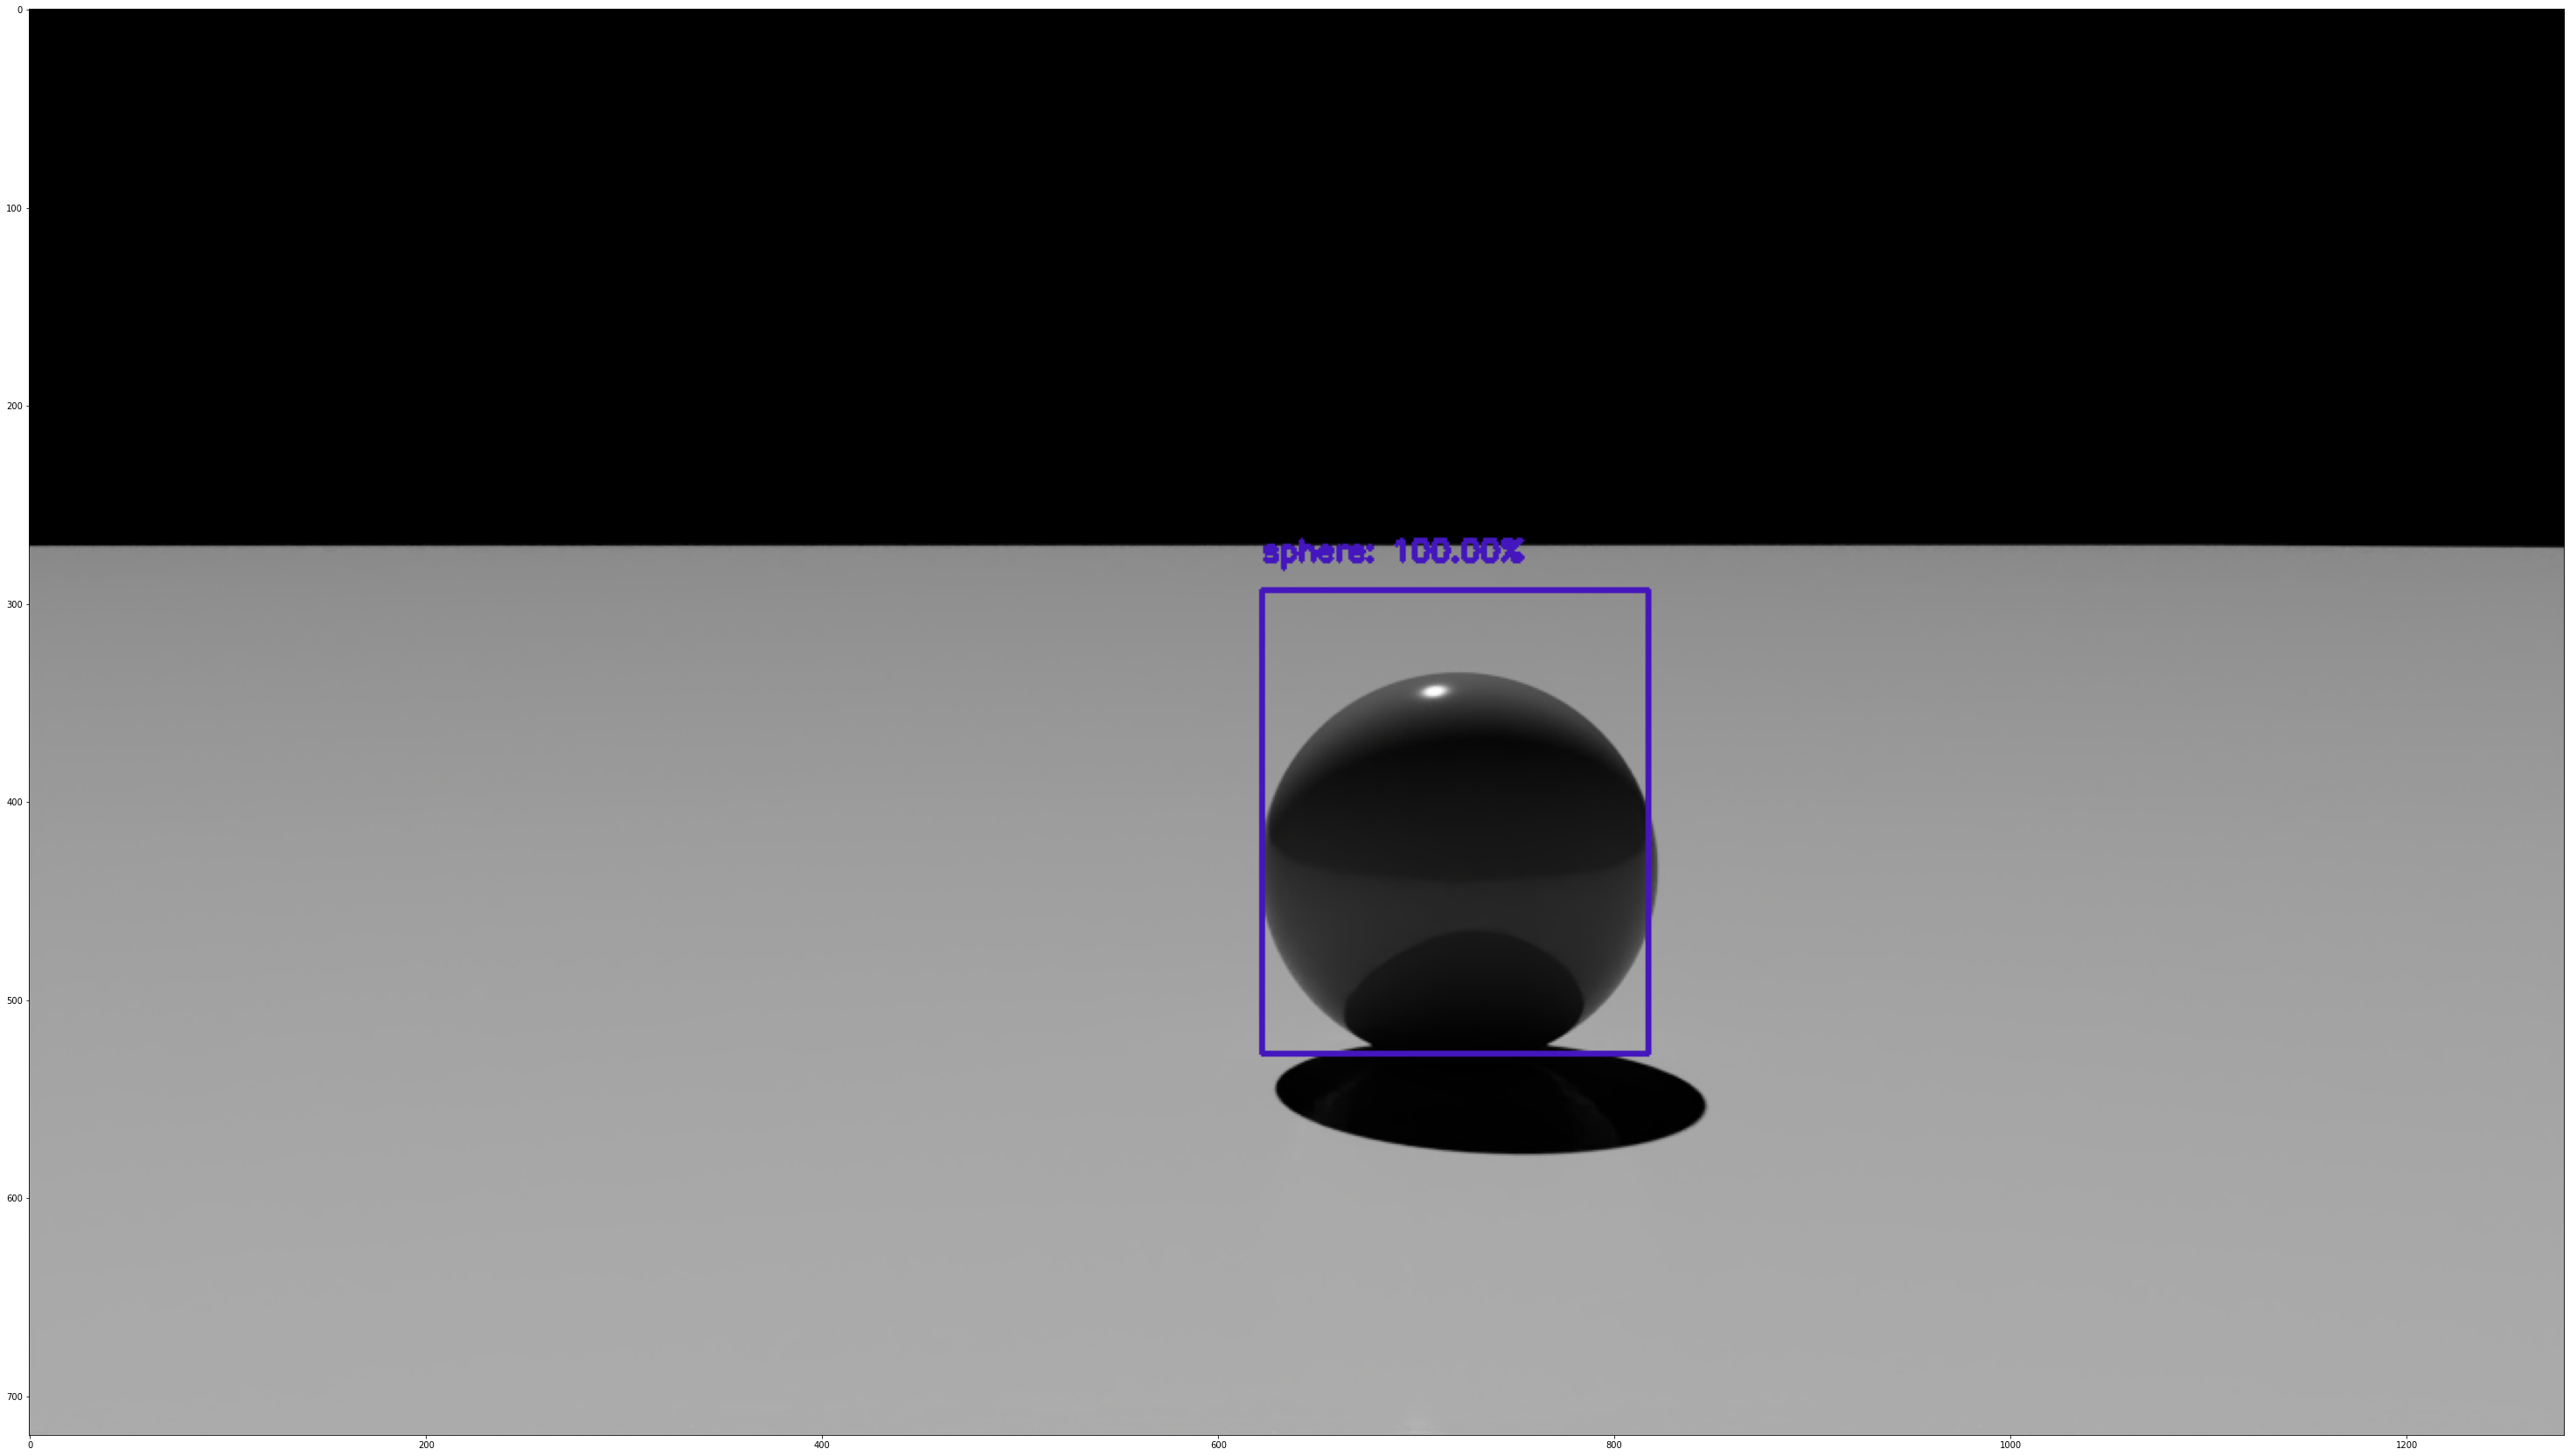

Image input size: 720, 1280
Id: 1
sphere: 99.98%
Detected sphere at X position: 642


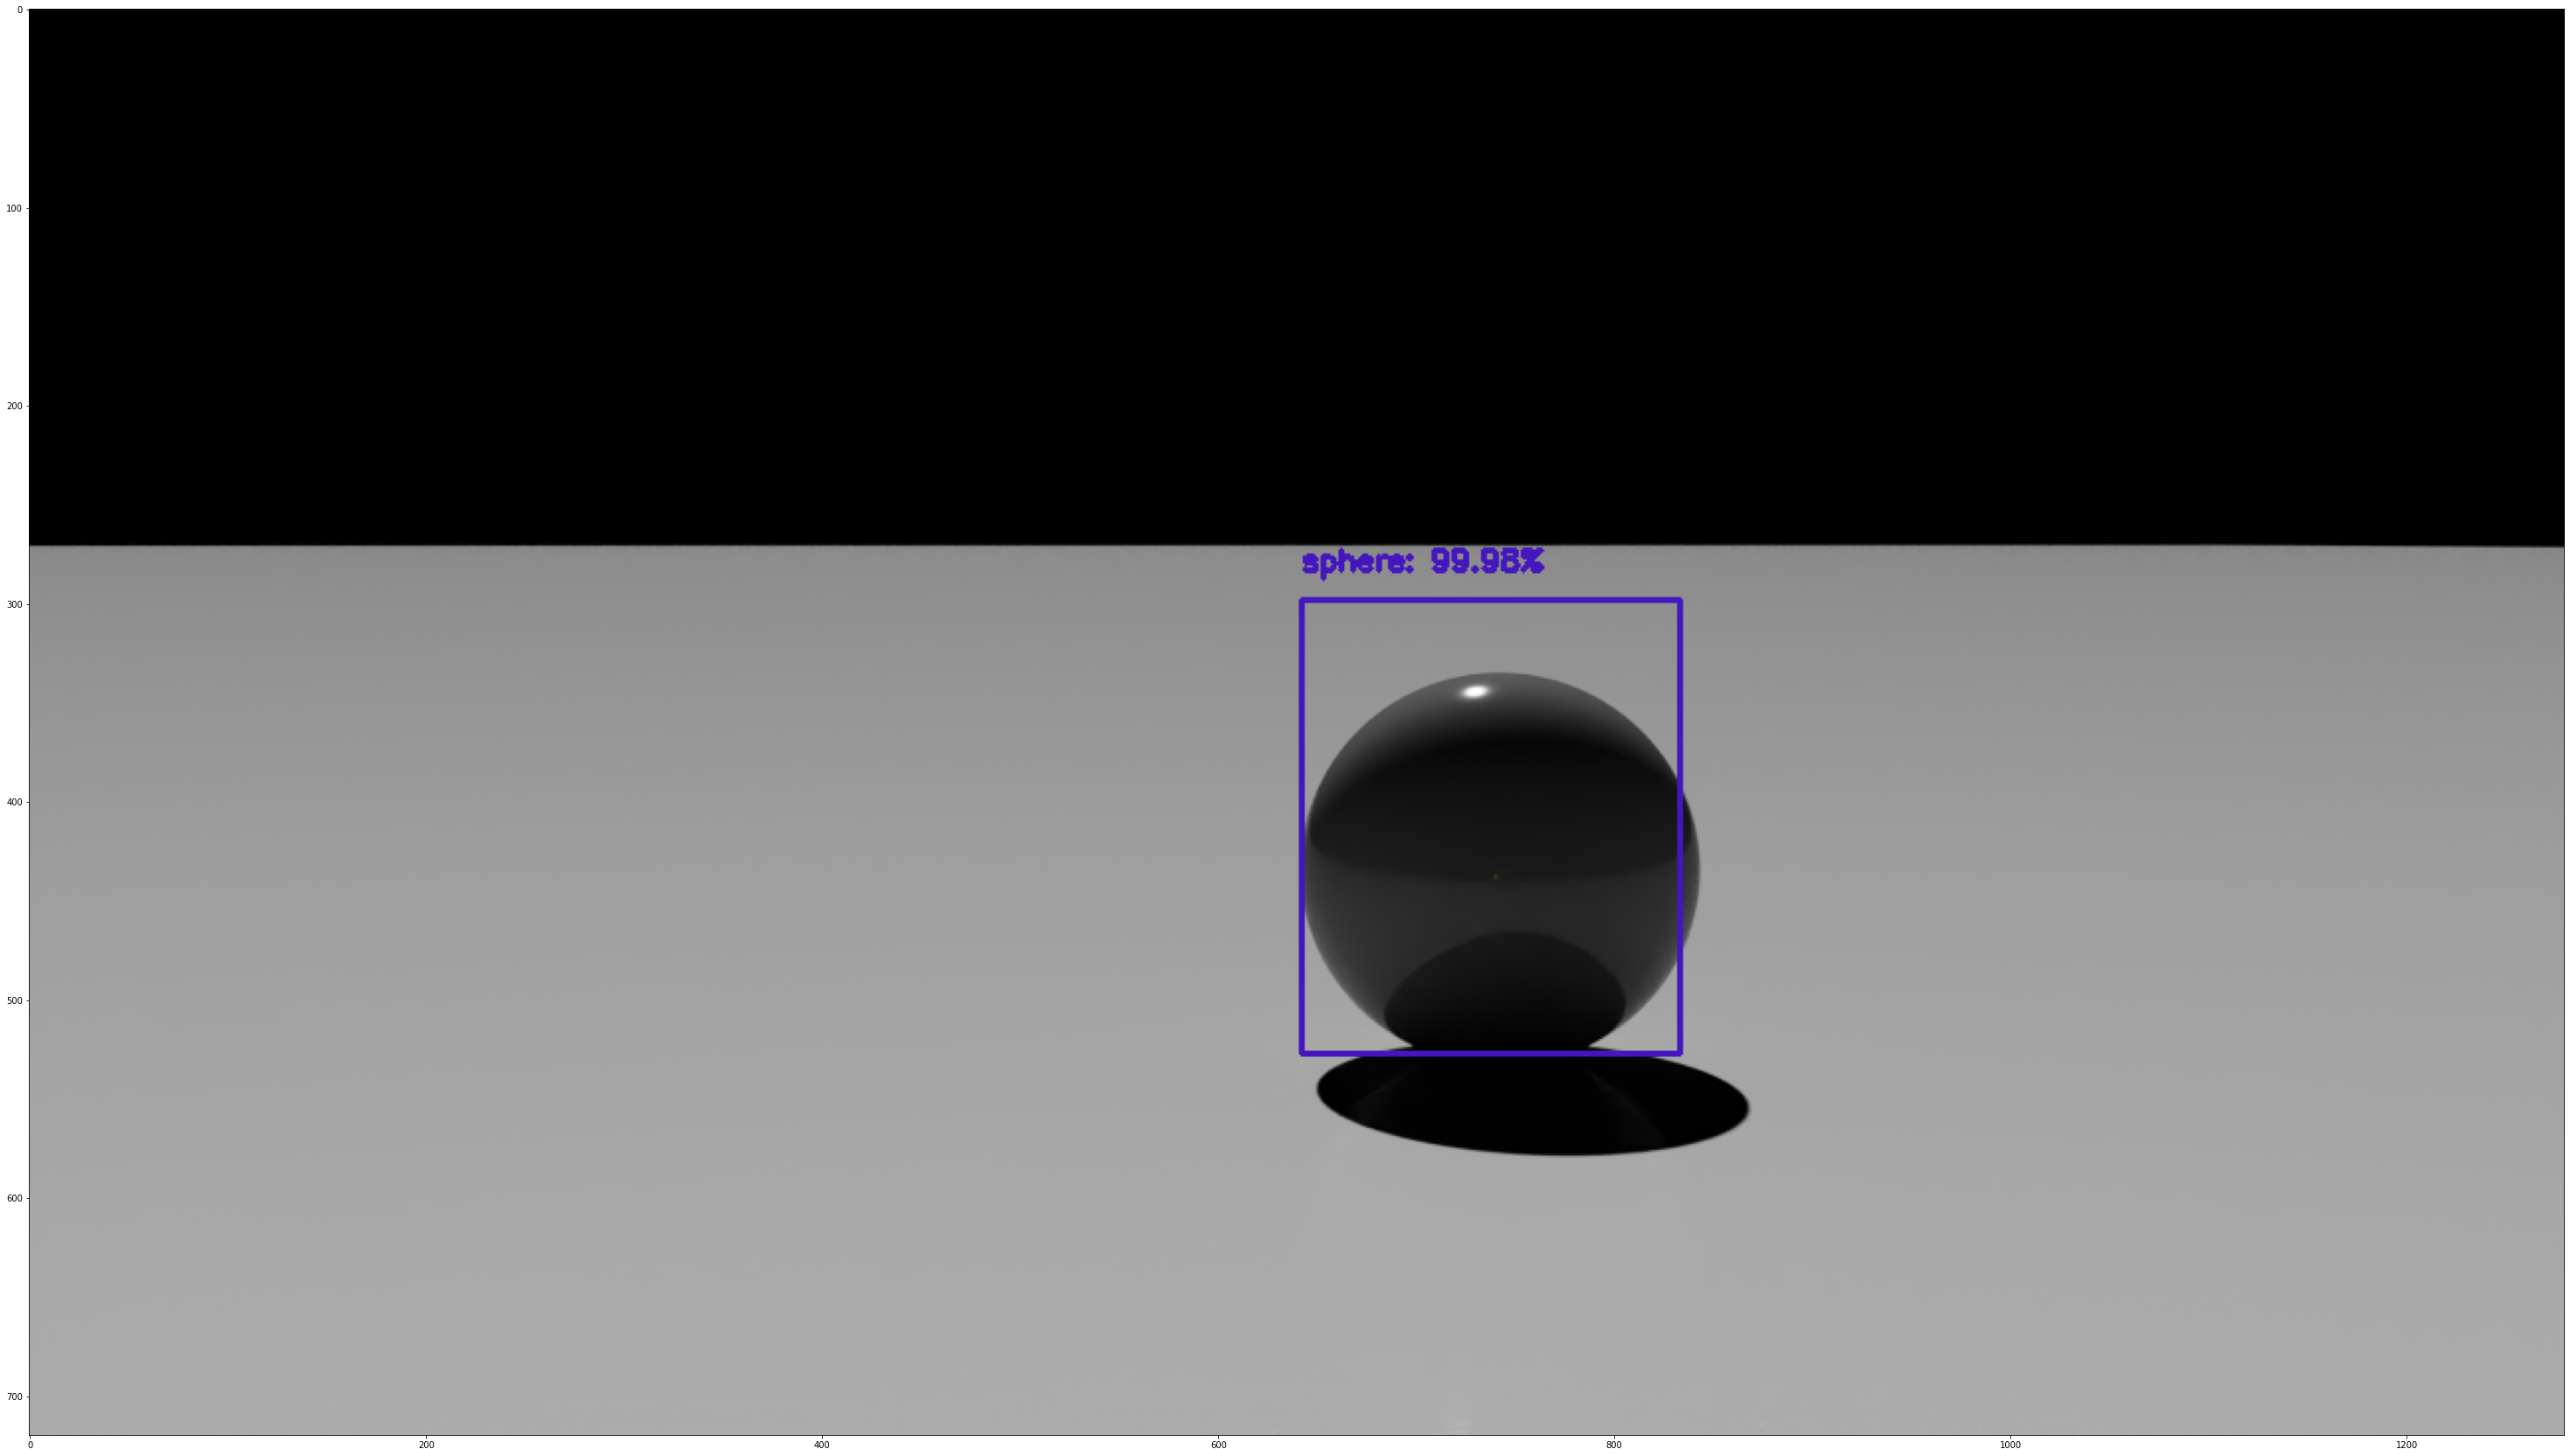

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 662


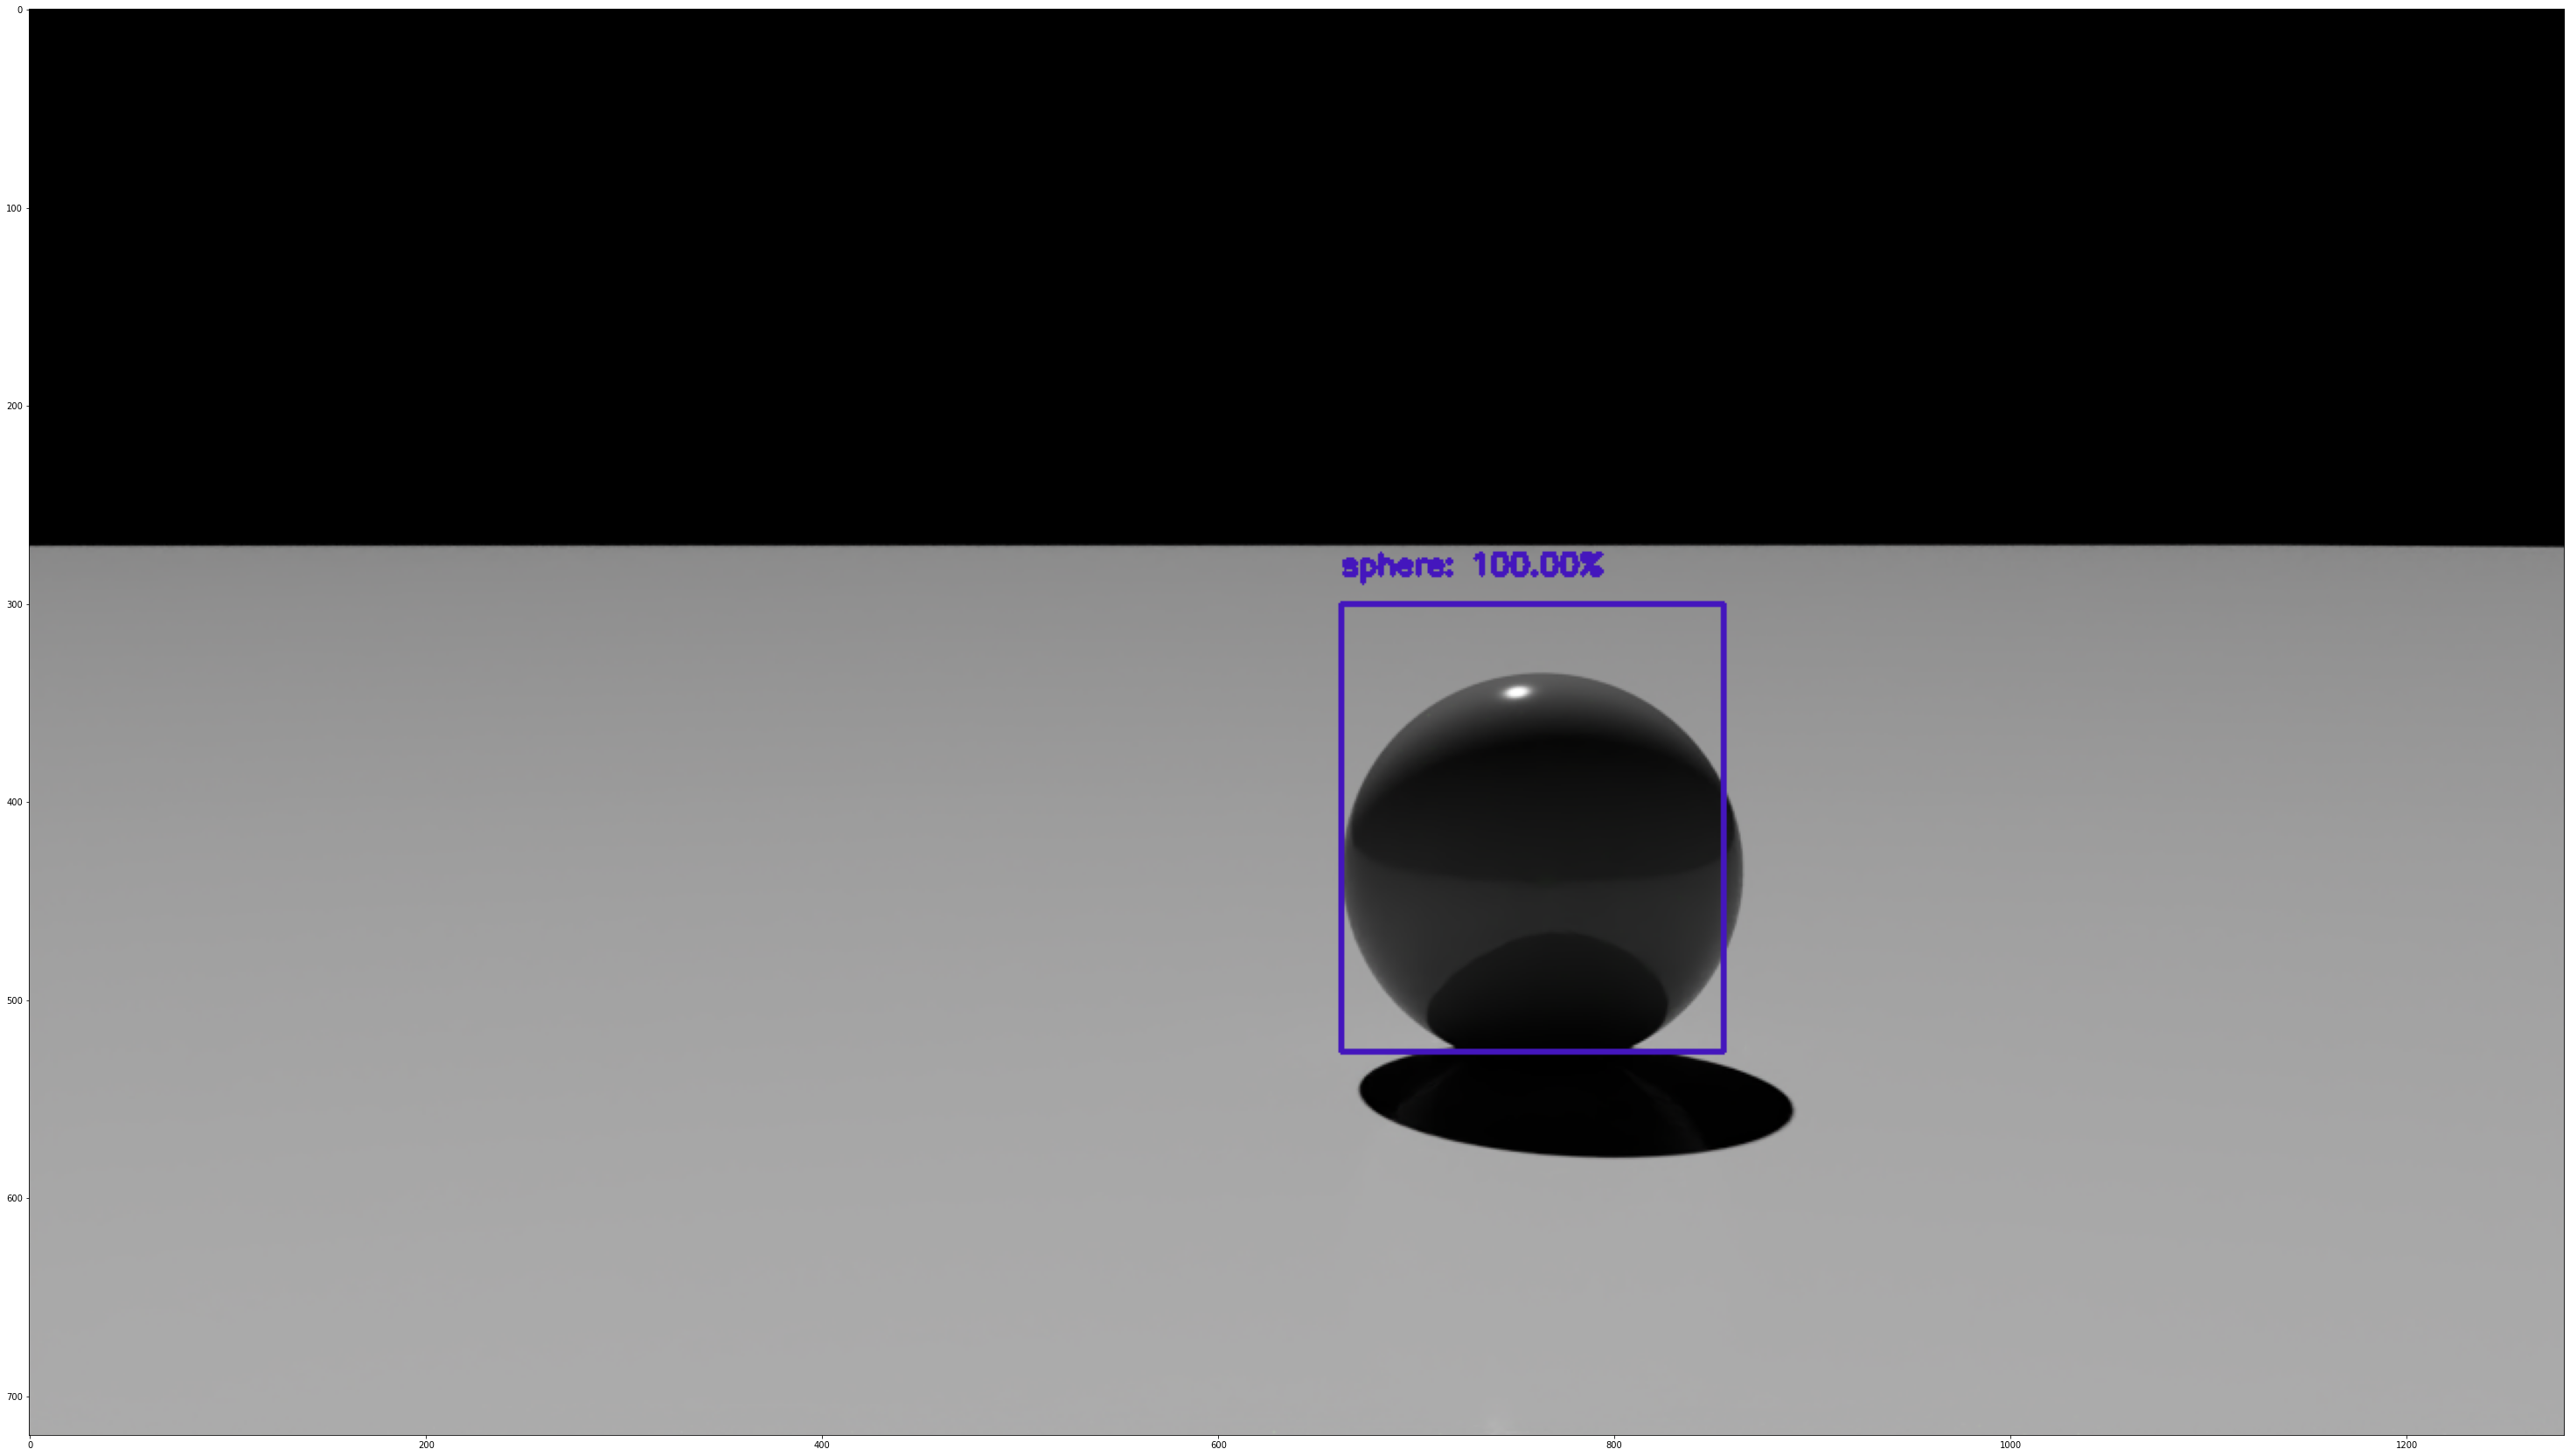

Image input size: 720, 1280
Id: 1
sphere: 99.99%
Detected sphere at X position: 640


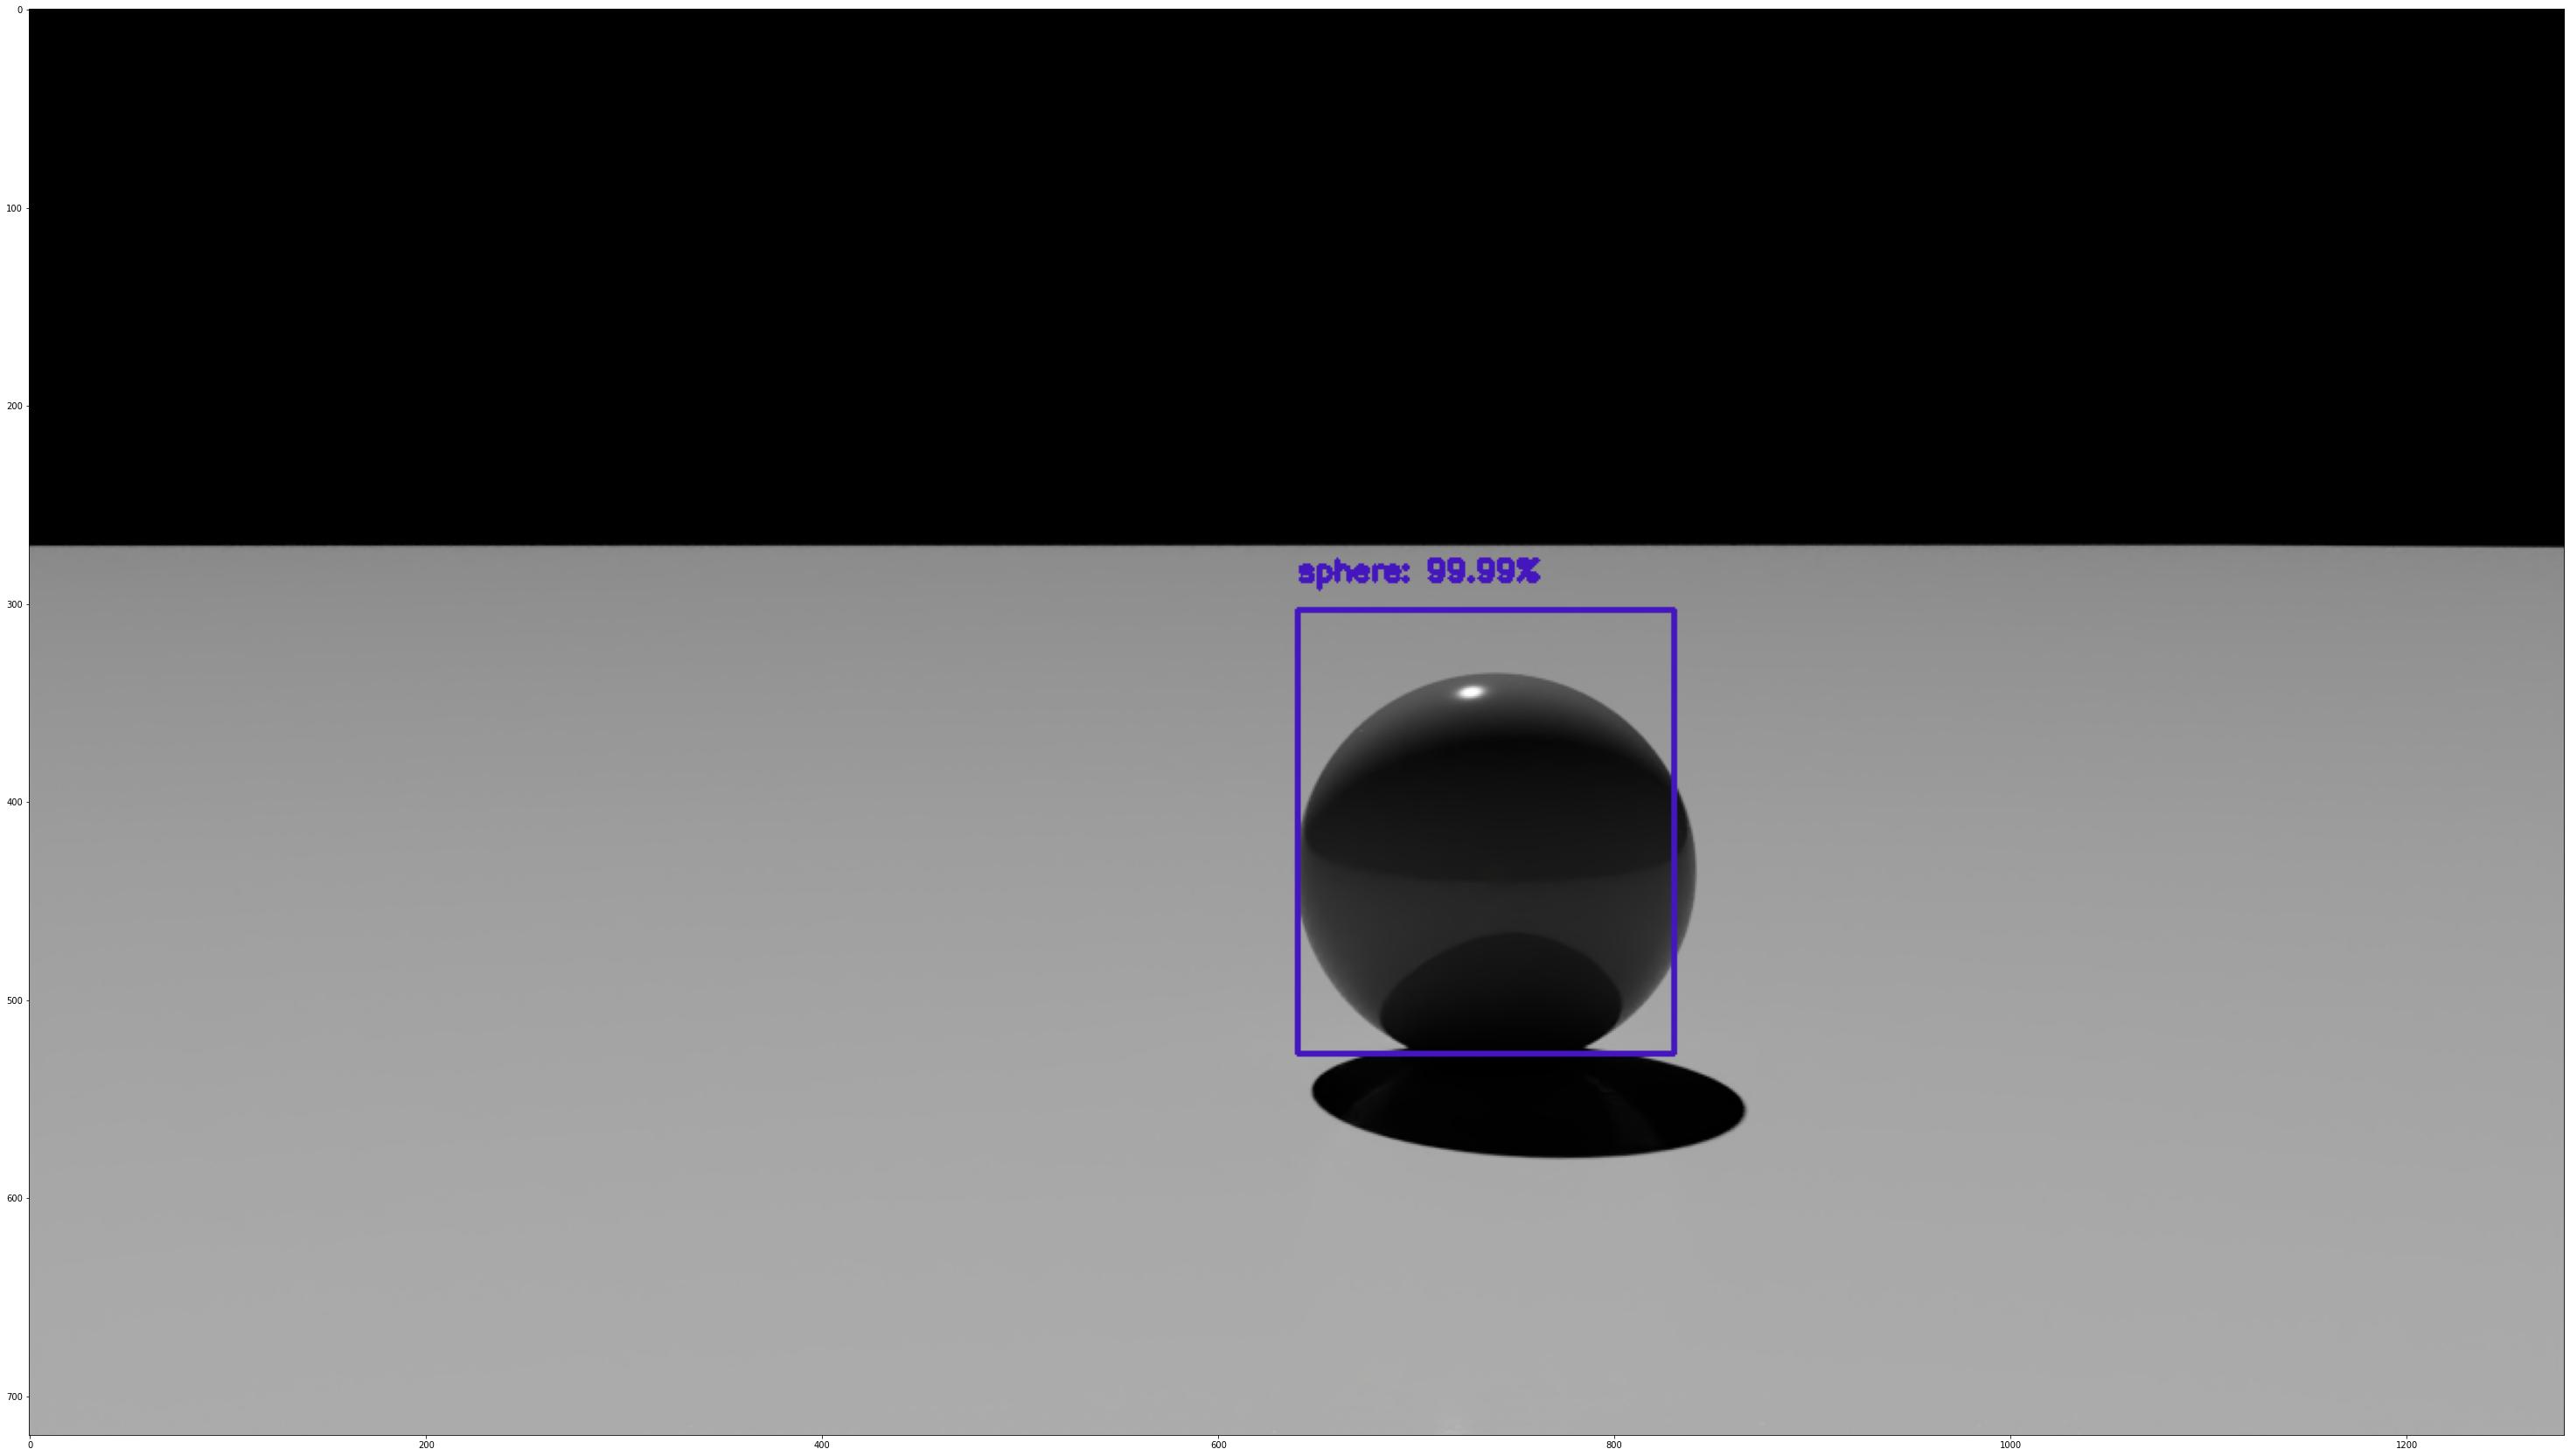

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 617


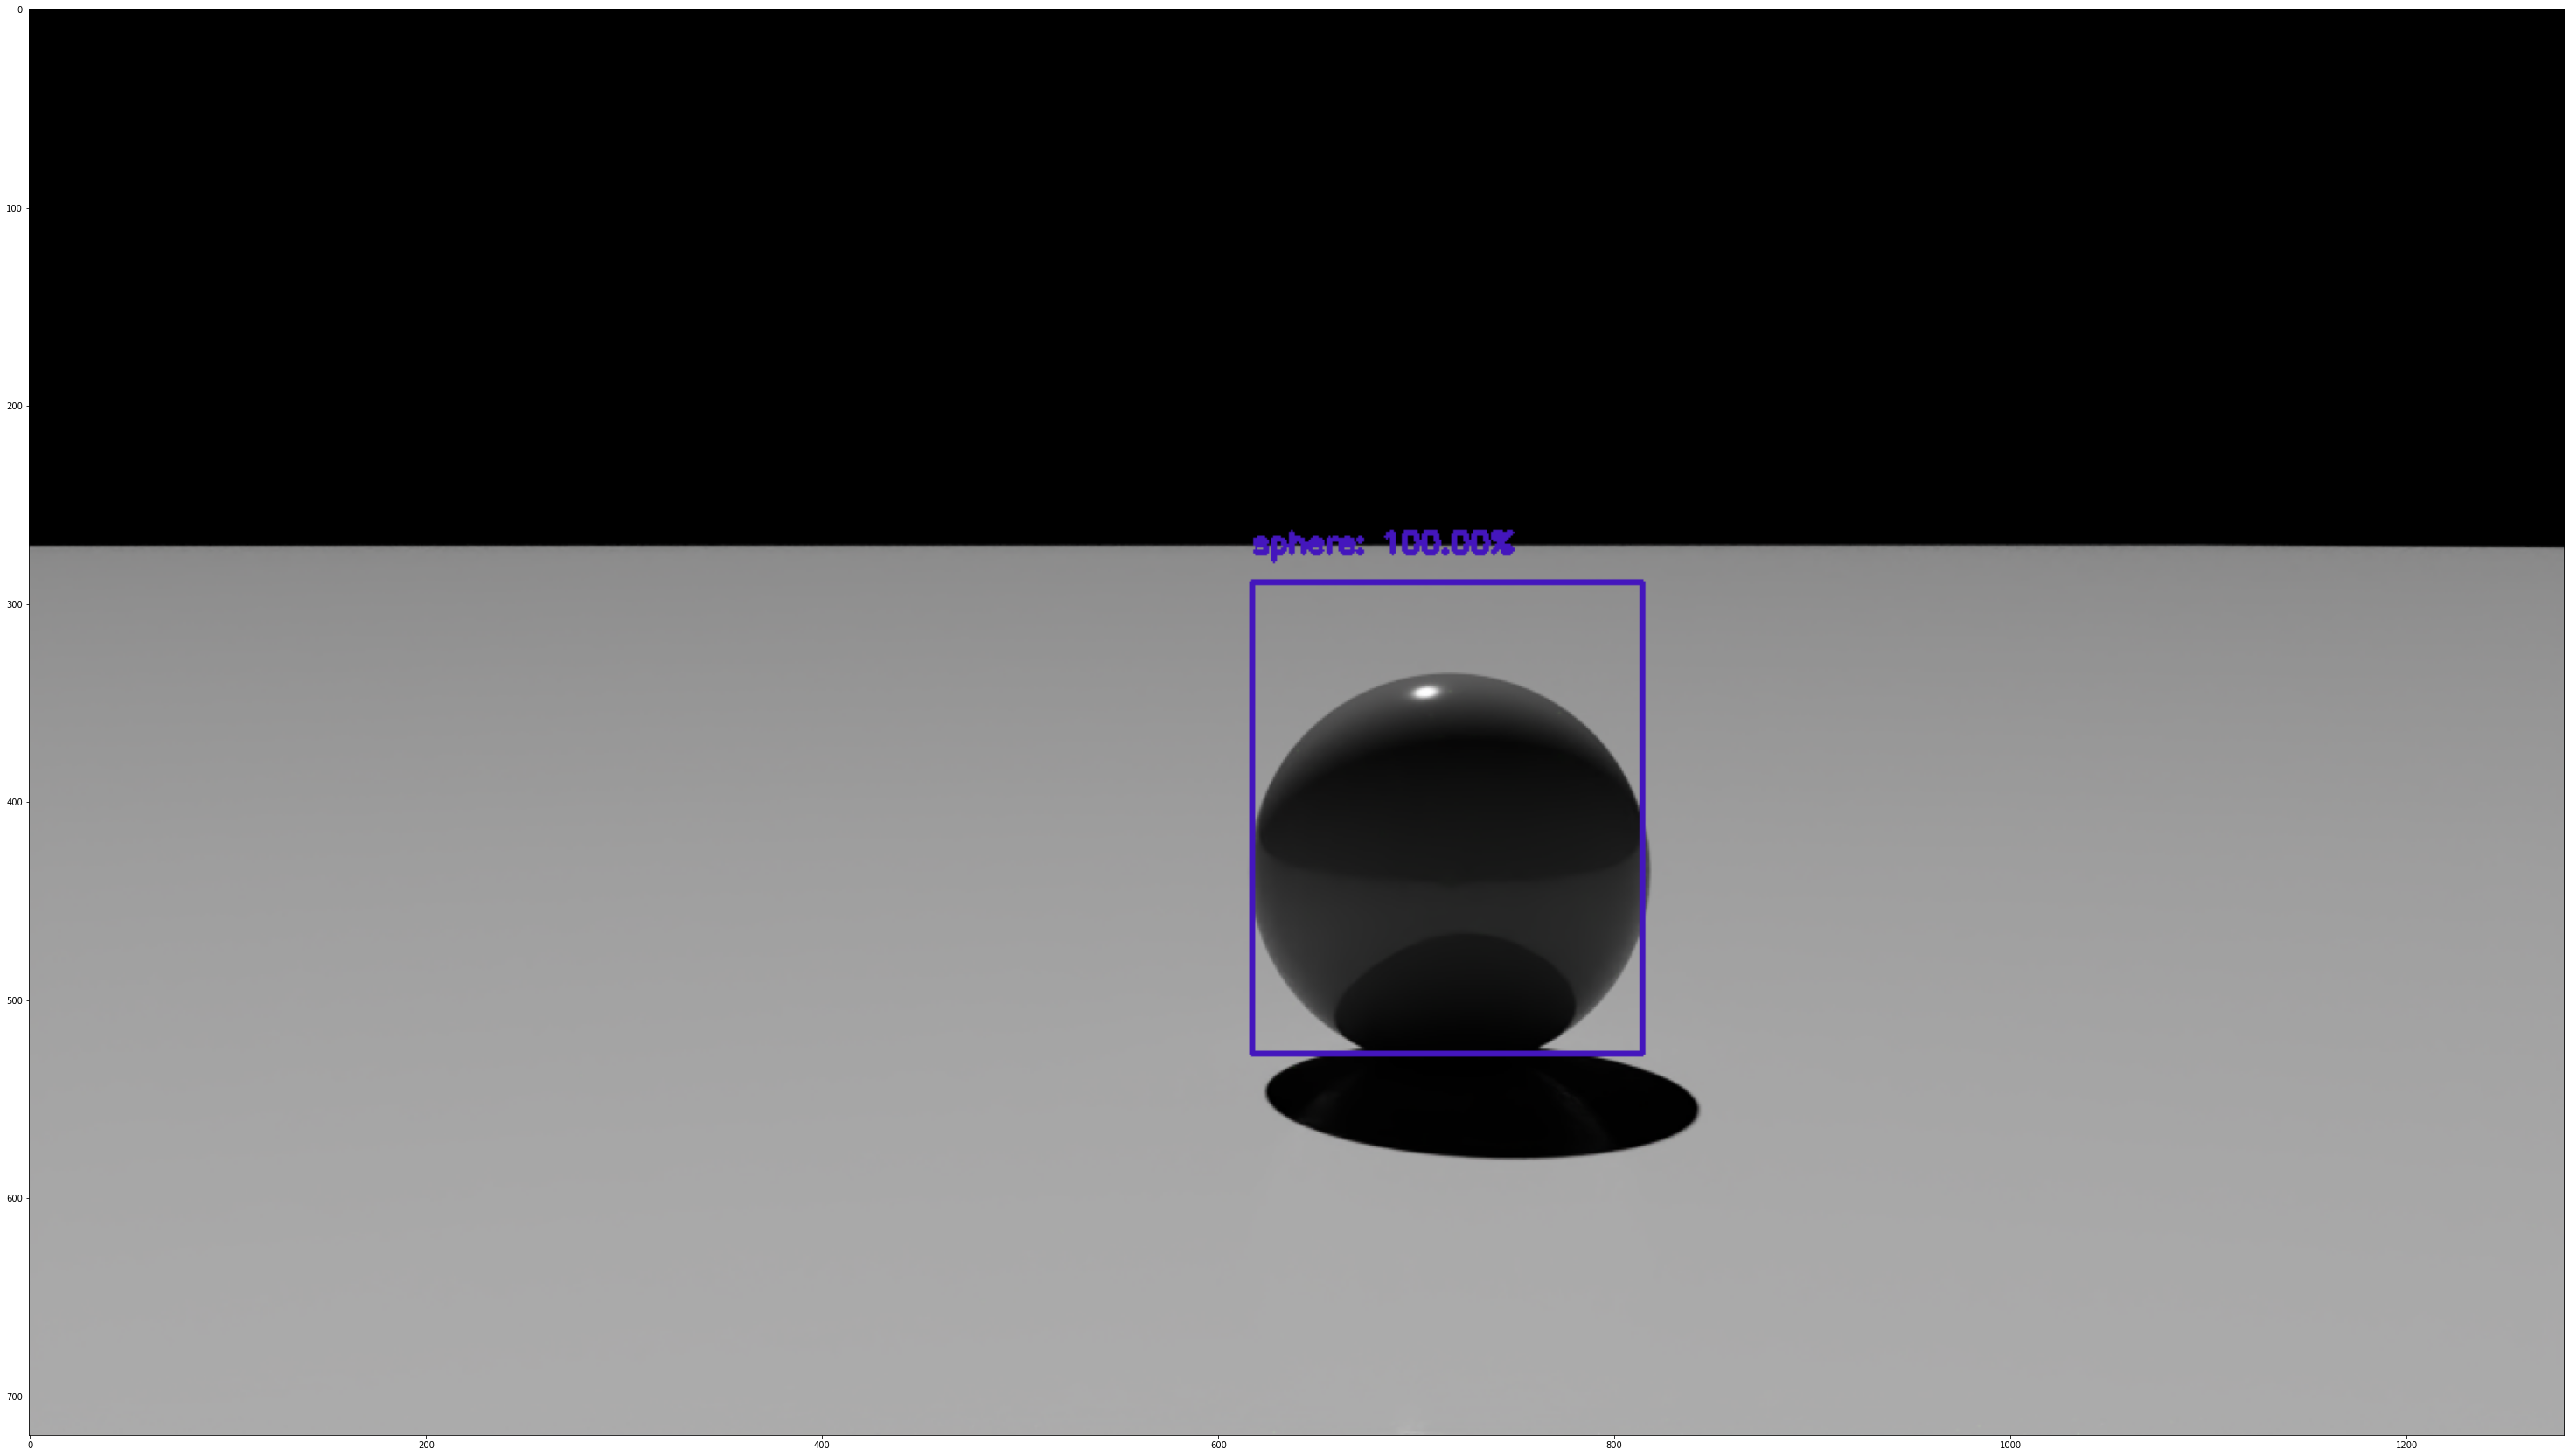

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 594


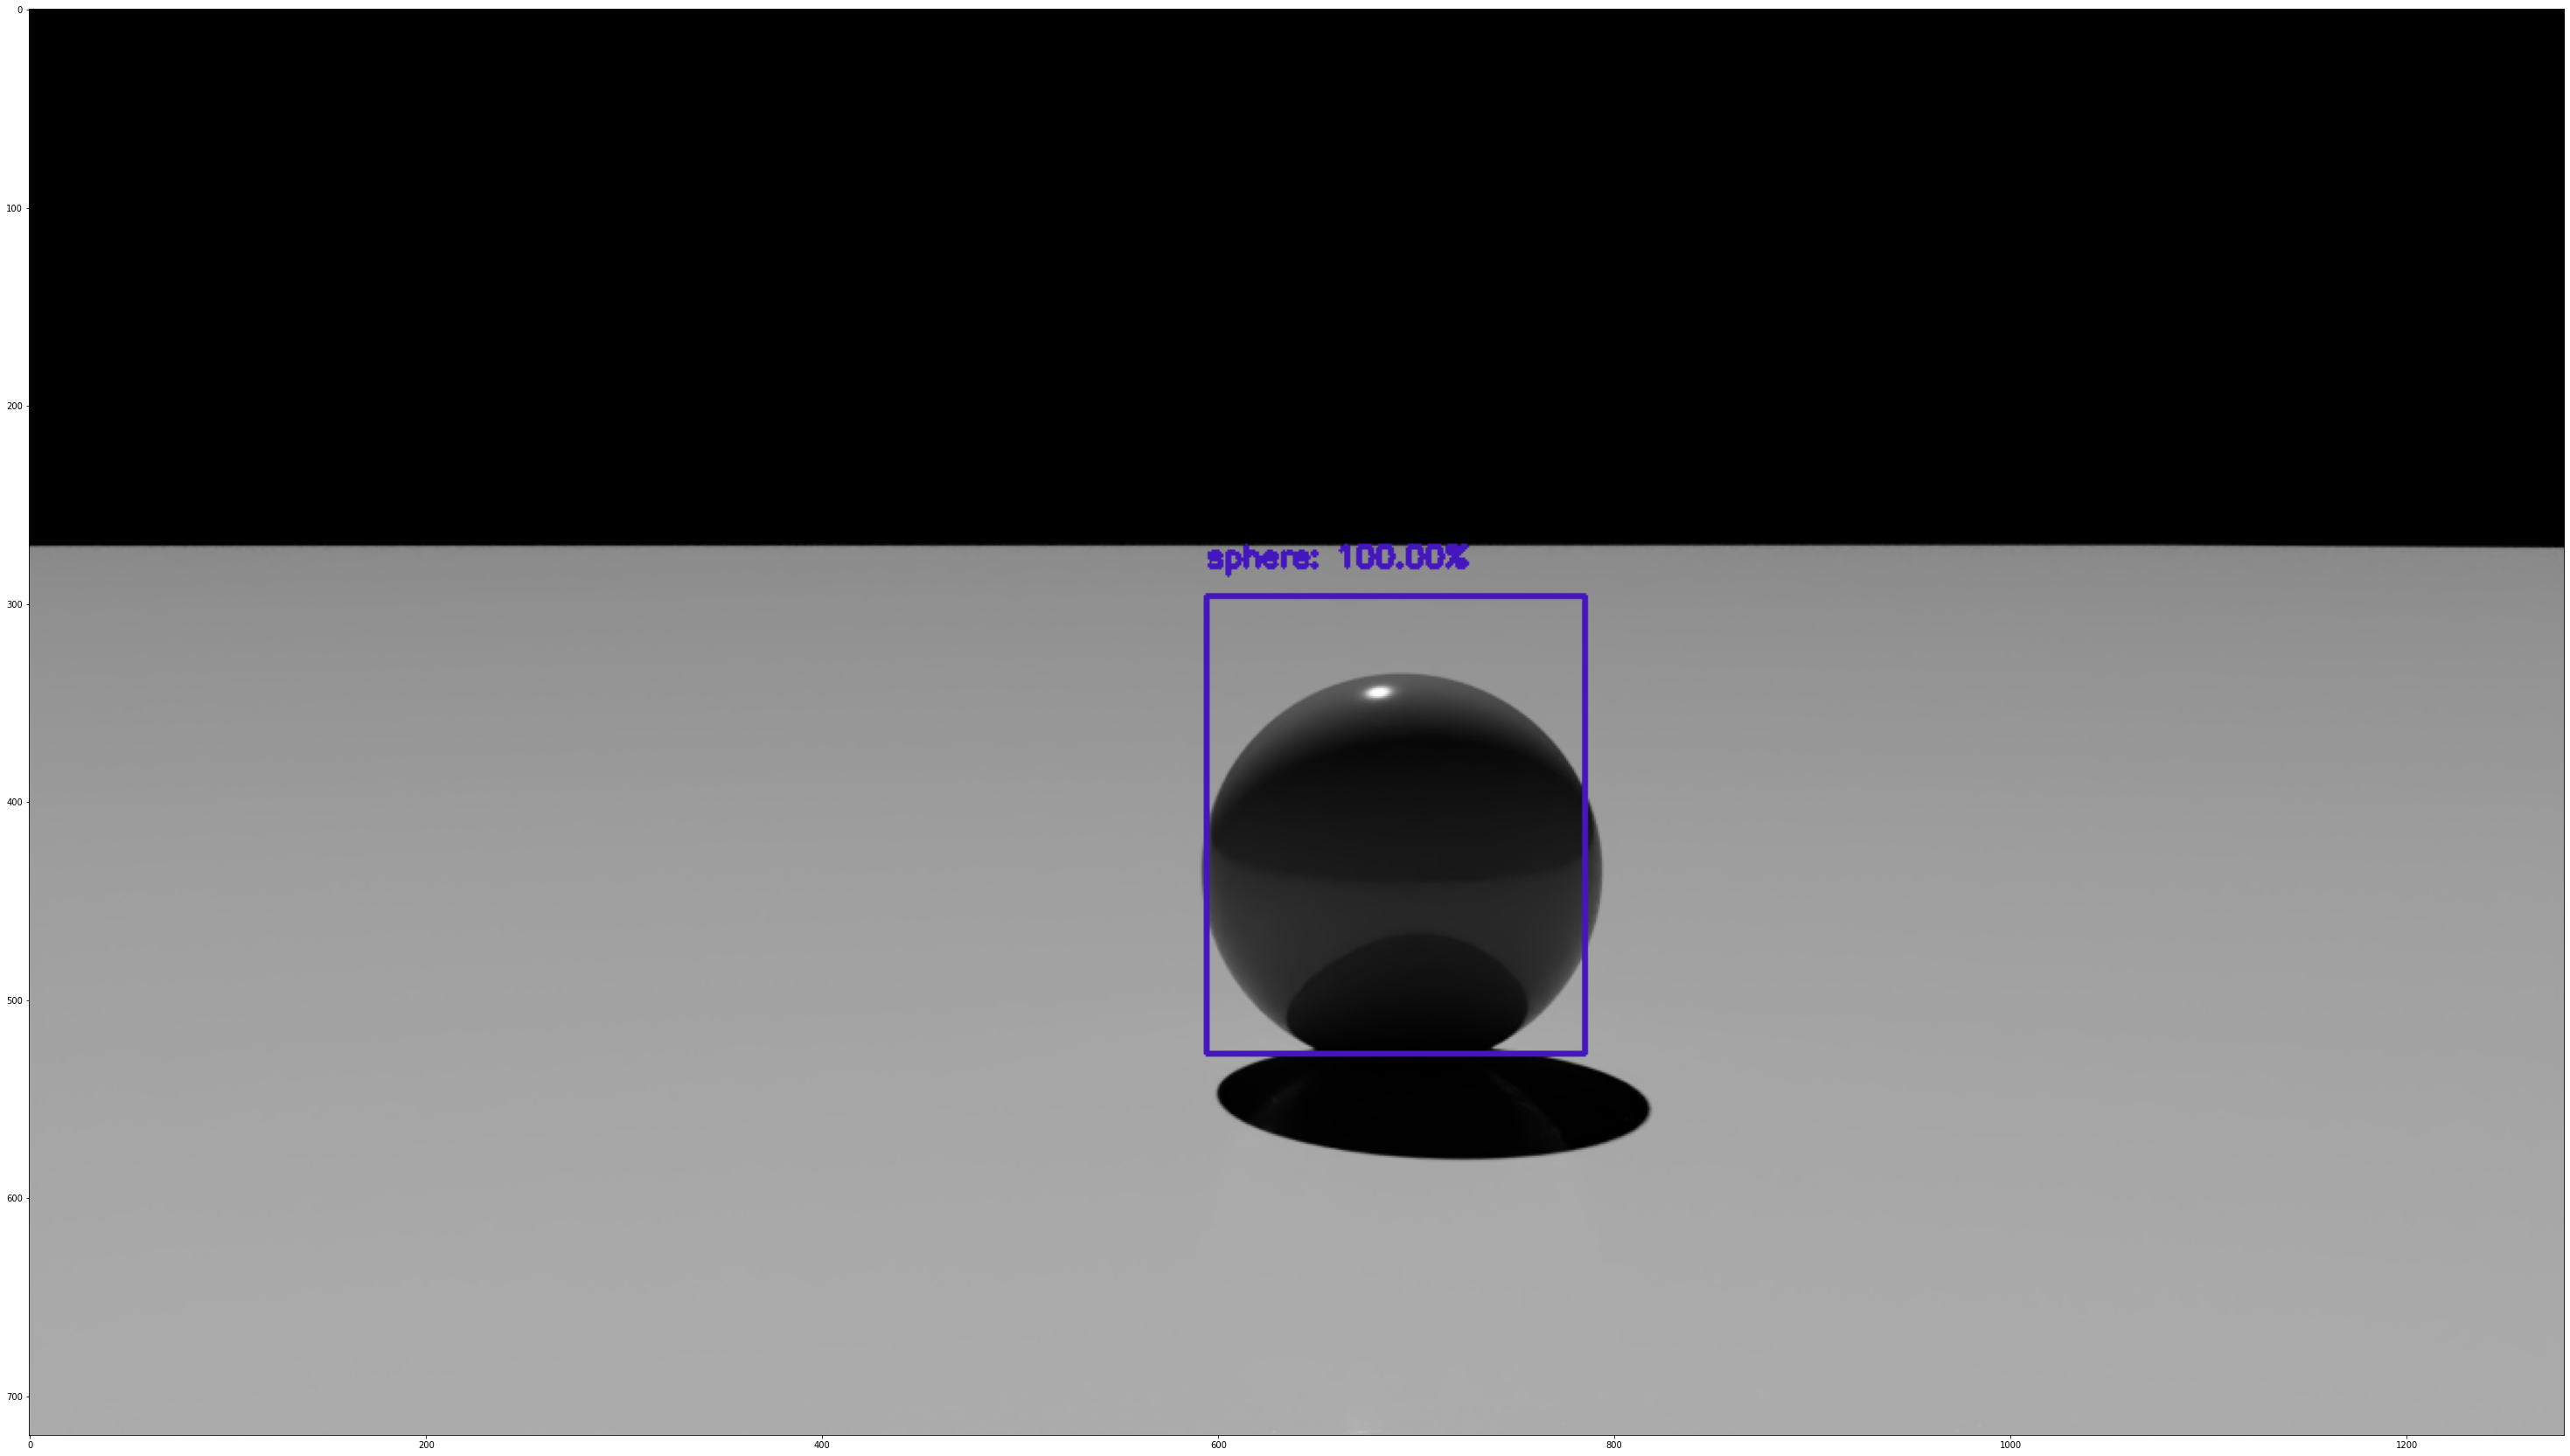

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 613


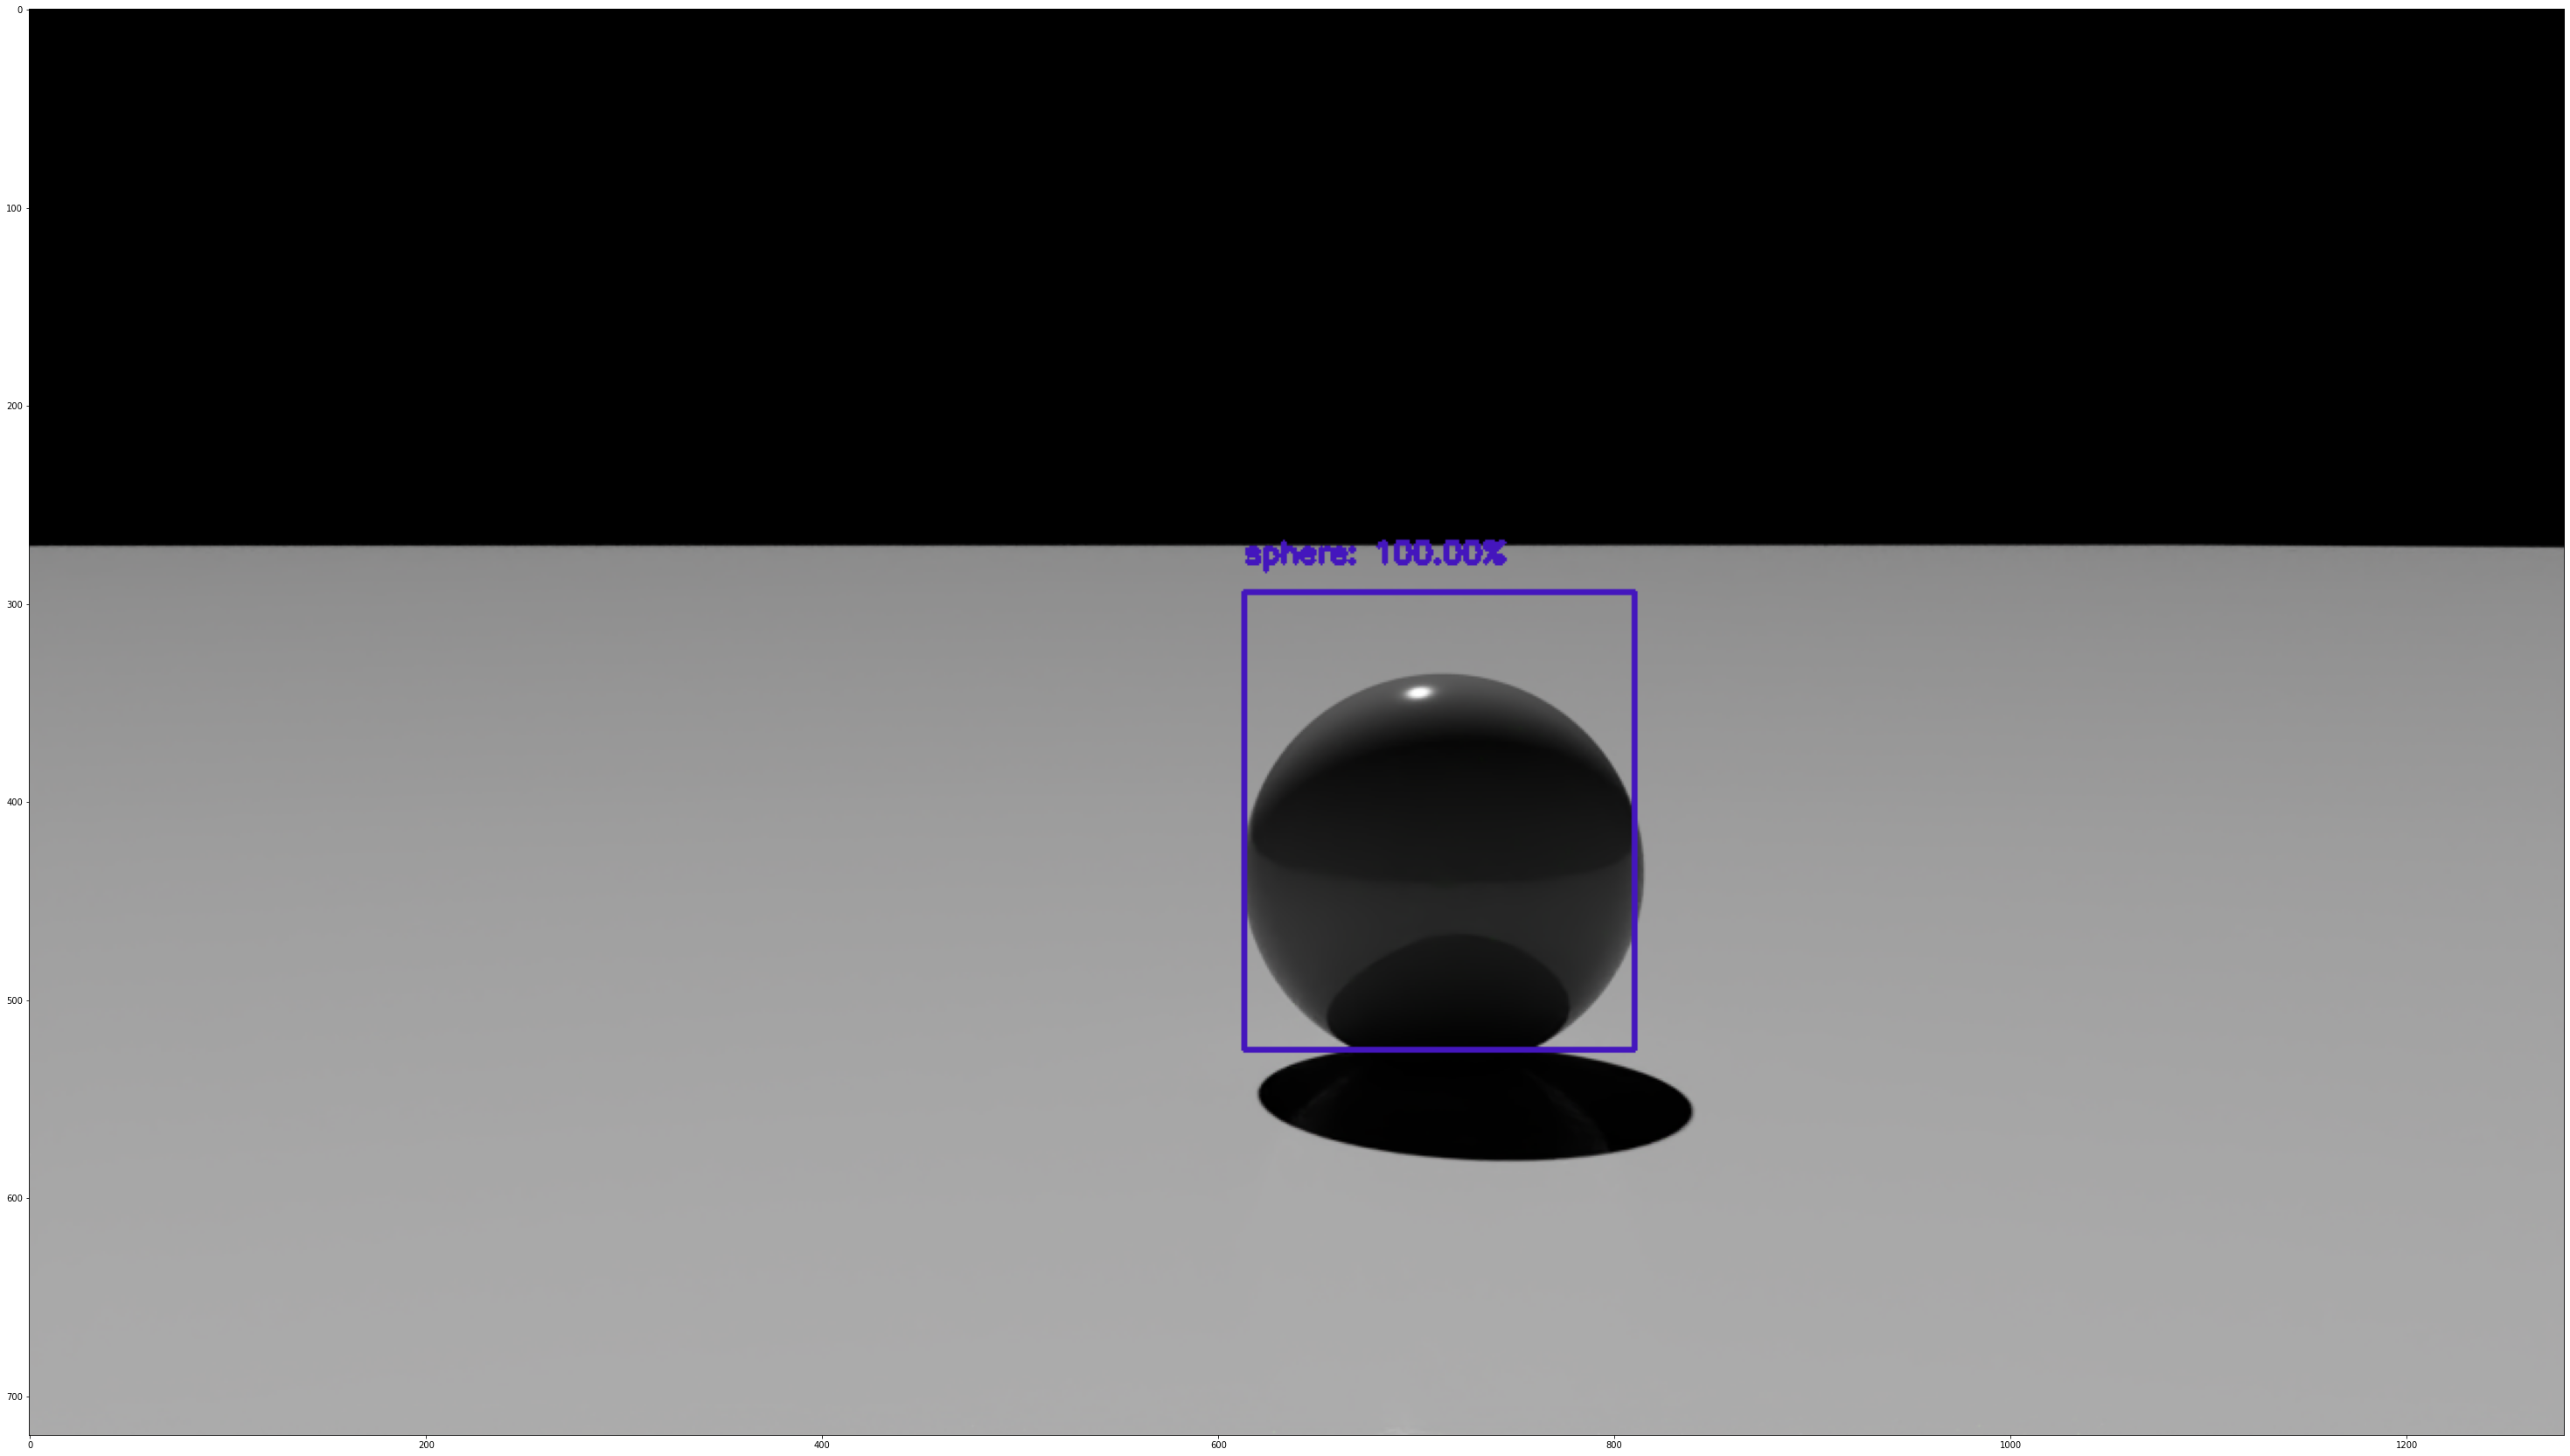

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 635


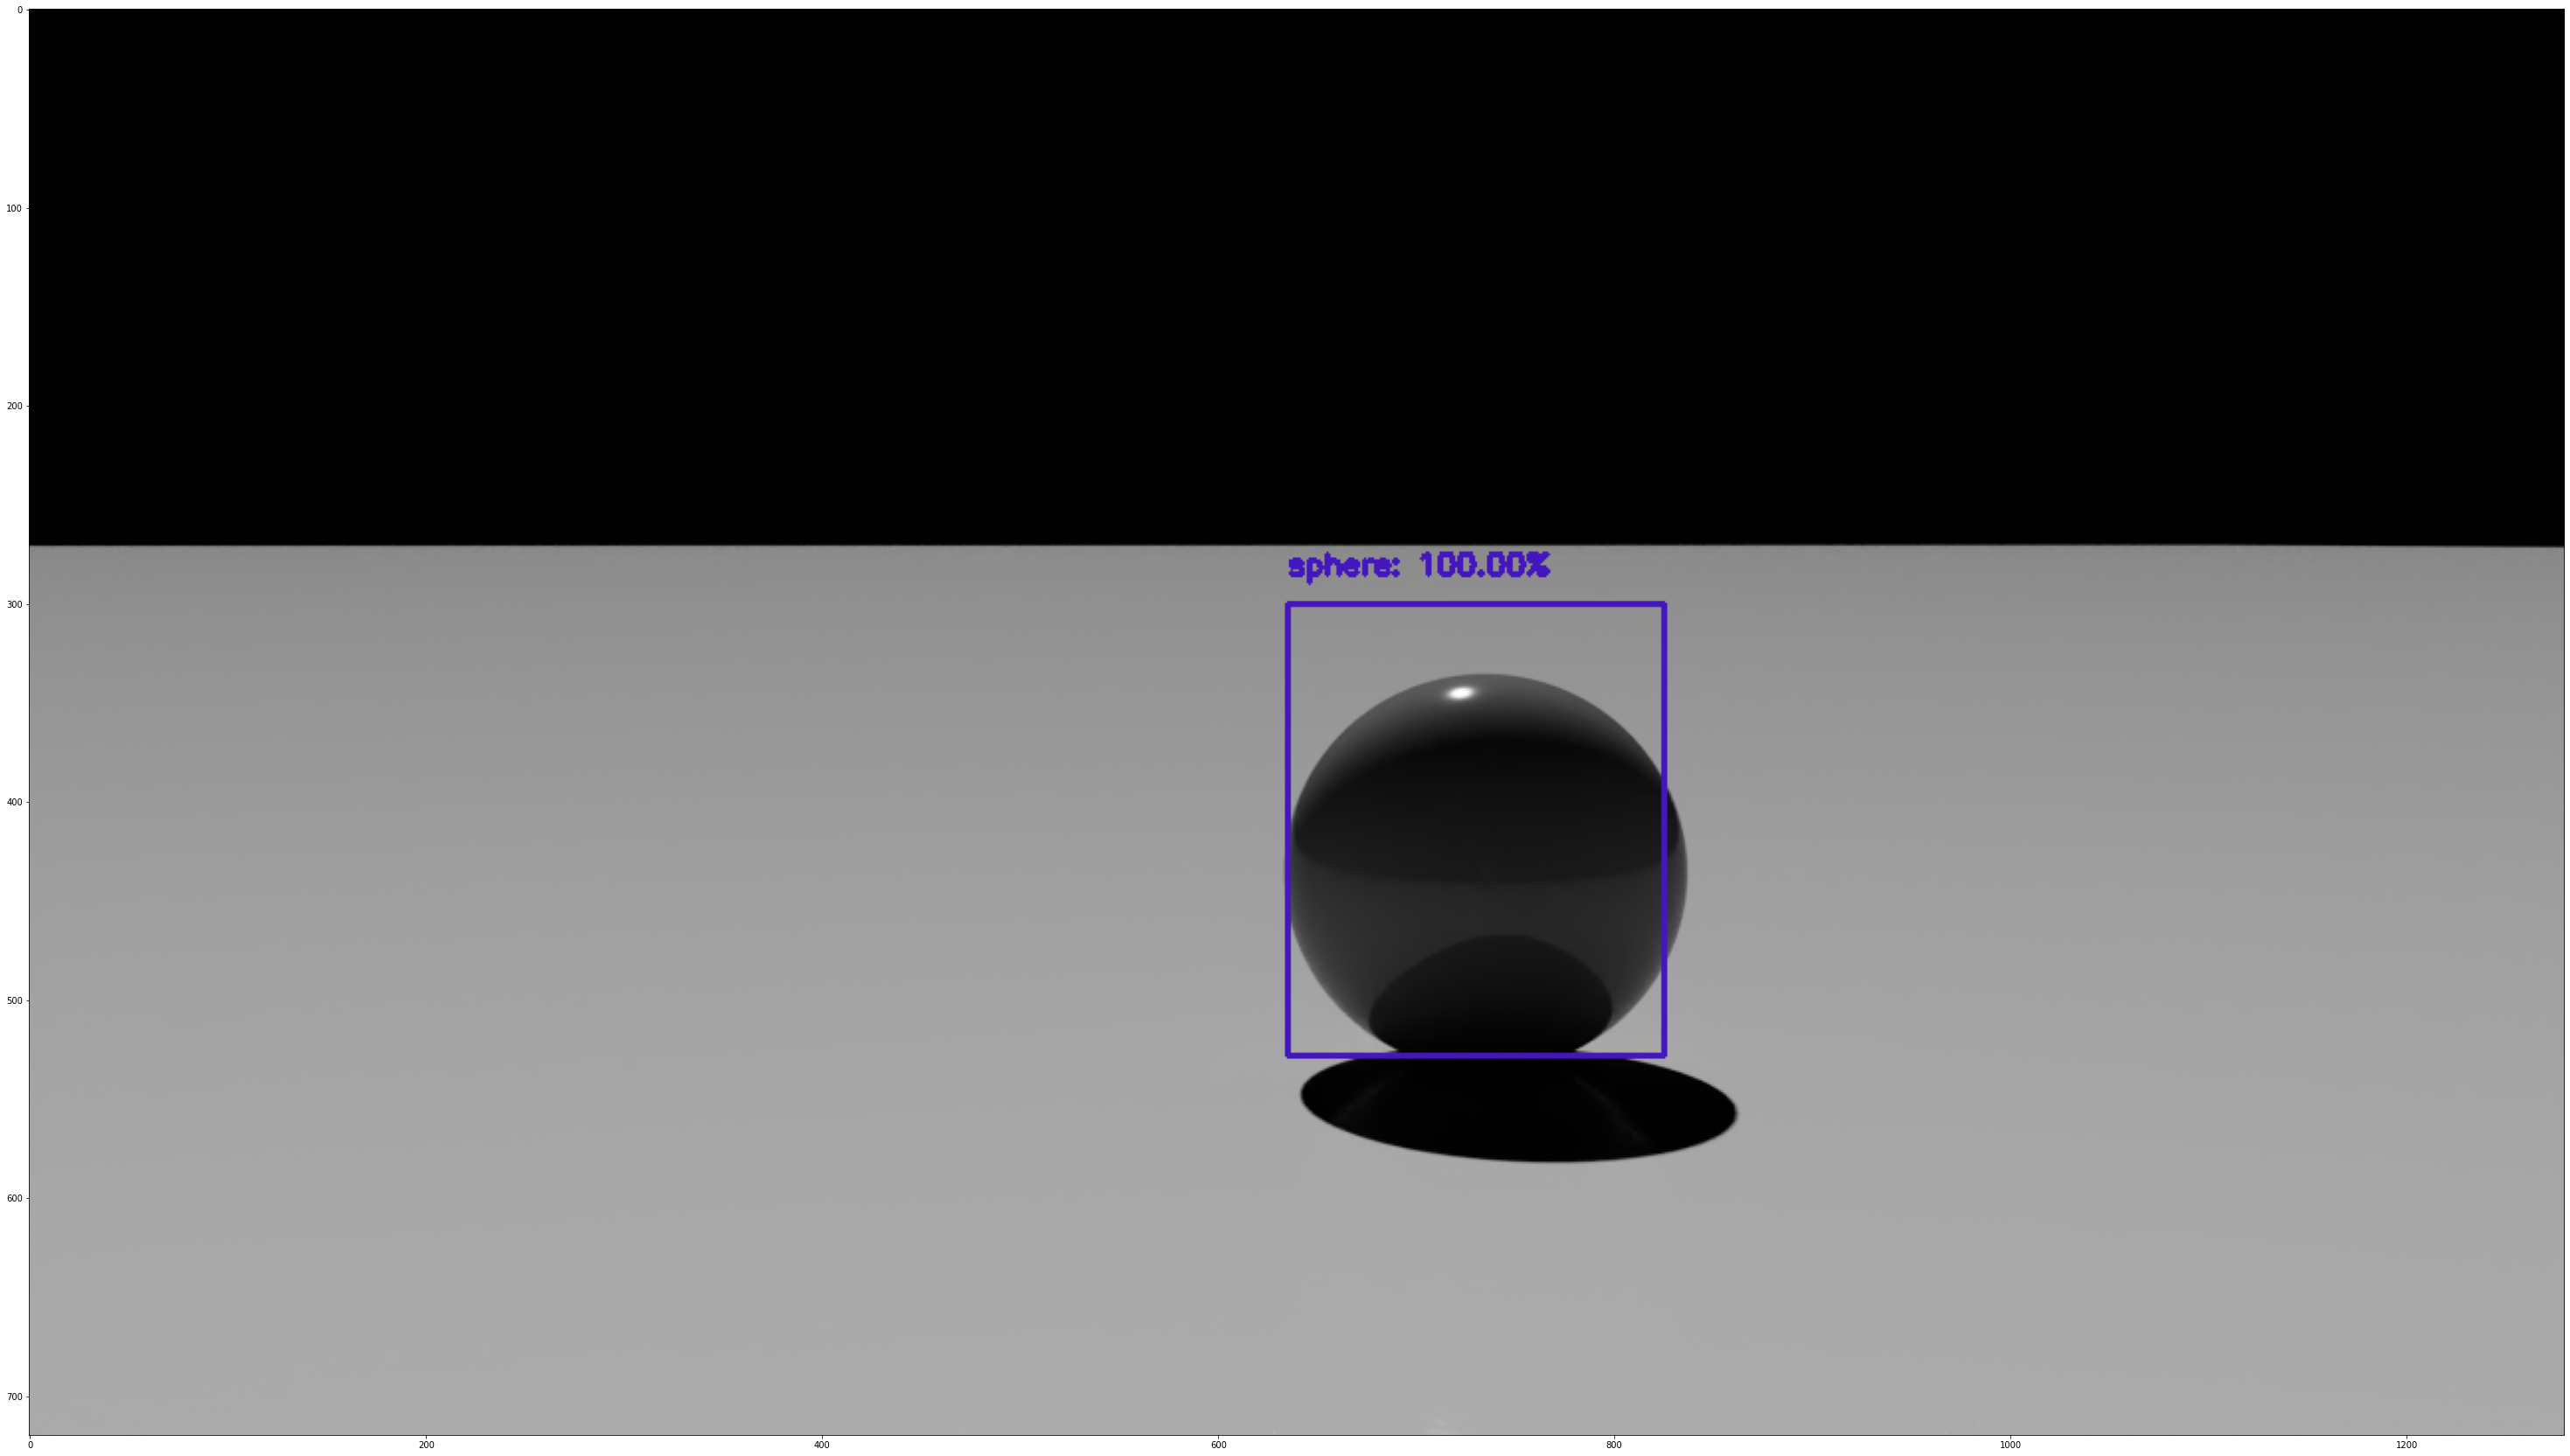

Image input size: 720, 1280
Id: 1
sphere: 100.00%
Detected sphere at X position: 654


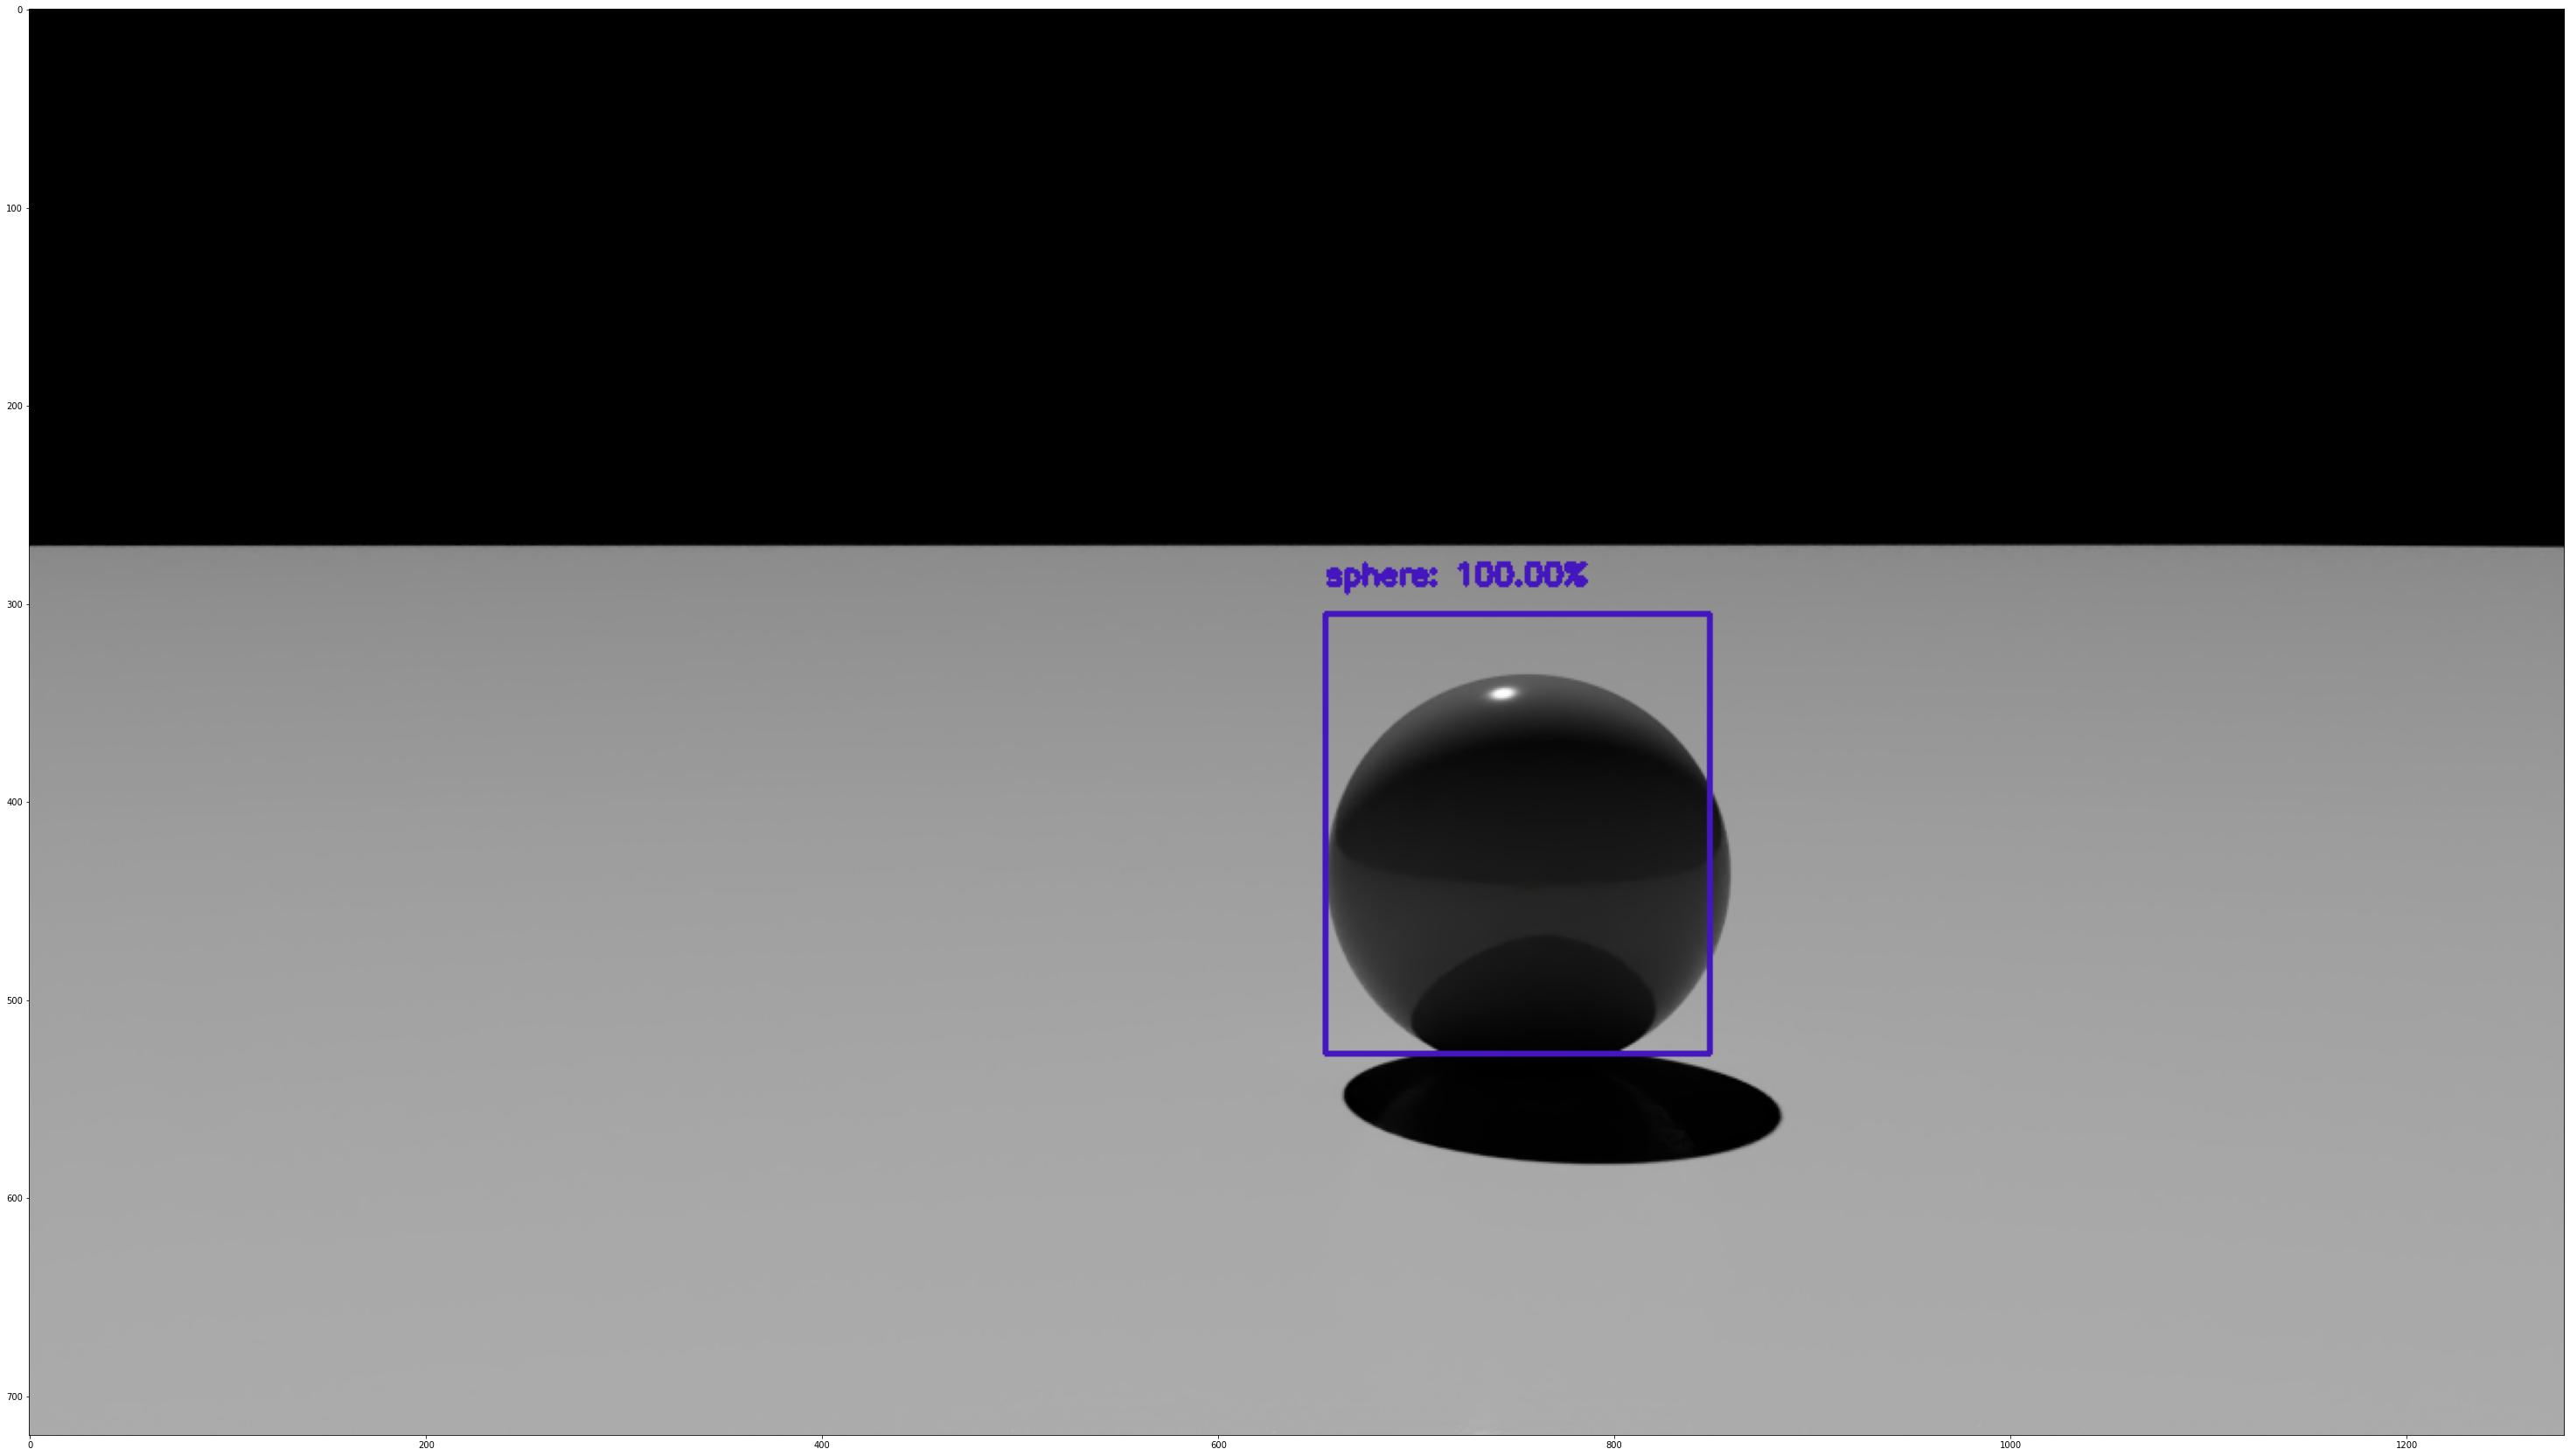

Simulation App Shutting Down
0.0] startup
[2.992s] [ext: omni.kit.widget.stage-2.6.8] startup
[2.995s] [ext: omni.kit.window.content_browser-2.4.10] startup
[3.097s] [ext: omni.kit.window.preferences-1.1.5] startup
[3.123s] [ext: omni.kit.usd_undo-0.1.0] startup
[3.124s] [ext: omni.kit.widget.stage_icons-1.0.2] startup
[3.125s] [ext: omni.kit.property.usd-3.11.4] startup
[3.148s] [ext: omni.debugdraw-0.1.0] startup
[3.151s] [ext: omni.physx.commands-1.3.14-5.1] startup
[3.158s] [ext: omni.kit.window.stage-2.3.4] startup
[3.164s] [ext: omni.physx.ui-1.3.14-5.1] startup
[3.178s] [ext: omni.kit.property.material-1.7.2] startup
[3.183s] [ext: omni.kit.window.toolbar-1.2.1] startup
[3.187s] [ext: omni.physx.demos-1.3.14-5.1] startup
[3.195s] [ext: omni.kit.property.physx-0.1.0] startup
[3.236s] [ext: omni.physx.tests-1.3.14-5.1] startup
[3.346s] [ext: omni.physx.vehicle-1.3.14-5.1] startup
[3.360s] [ext: omni.physx.cct-1.3.14-5.1] startup
[3.370s] [ext: omni.isaac.franka-0.0.0] startup
[3.3

In [9]:
import cv2
from omni.isaac.synthetic_utils import SyntheticDataHelper
import omni.syntheticdata._syntheticdata as gt
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image
import asyncio
import omni
import numpy as np


CLASSES = ["sphere"]

COLORS = np.random.uniform(0,255,size=(len(CLASSES),3))


#Simulation - getting the instance and be able to choose the jetbot camera
viewport_handle = viewport.get_instance('Viewport')
viewport_window = viewport.get_viewport_window(viewport_handle)
jetbot_camera_path = "/World/jetbot/chassis/rgb_camera/jetbot_camera"
viewport_window.set_active_camera(jetbot_camera_path)

# Create the DNN net
net = cv2.dnn.readNetFromTensorflow('data/camera_down_graphs/frozen_inference_graph.pb', 'data/camera_down_graphs/final_graph.pbtxt')
i=0

while kit.is_running() and i<20:
    kit.update()
#     clear_output(wait=True) #clearing the jupyter output for updating the plot with a new image
    #Simulation - getting the rgb image from the viewport window
    gt = sd_helper.get_groundtruth(["rgb"], viewport_window)
    input_image = cv2.cvtColor(gt["rgb"], cv2.COLOR_RGBA2RGB)
    (h,w) = input_image.shape[:2]
    print("Image input size: " + str(h) + ", " + str(w))
    blob = cv2.dnn.blobFromImage(image=cv2.resize(input_image,(w,h)), scalefactor=1.0, size=(300,300), swapRB=True)
    net.setInput(blob)
    detections = net.forward()
    for j in np.arange(0, detections.shape[2]):
        confidence = detections[0,0,j,2]
        if confidence > 0.70:
            idx = int(detections[0,0,j,1])
            box = detections[0,0,j,3:7] * np.array([w,h,w,h])
            (startX, startY, endX, endY) = box.astype("int")
            print("Id: " + str(idx))
            label = "{}: {:.2f}%".format(CLASSES[0], confidence*100)
            print(label)
            cv2.rectangle(input_image, (startX,startY), (endX,endY), COLORS[0],2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
            cv2.putText(input_image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[0],2)
            print("Detected " + str(CLASSES[0]) +  " at X position: " + str(startX))
            #starting x of the detected object on the right side
            if startX > w/2:
                #apply velocity to the left jetbot's joint
                dc.set_dof_velocity_target(left_joint,0.2)
                dc.set_dof_velocity_target(right_joint,0)
            #starting x on the left side
            elif startX < w/2:
                #apply velocity to the right jetbot's joint
                dc.set_dof_velocity_target(right_joint,0.2)
                dc.set_dof_velocity_target(left_joint,0)
    plt.rcParams["figure.figsize"] = (200,30)
    plt.imshow(input_image)
    plt.show()
    i+=1

omni.timeline.get_timeline_interface().stop()
kit.close()